In [1]:
from dataloader import PriceScenarioDataset
from utils import VaR, ES, score
from Discriminator import Discriminator
from Generator import Generator
from Tradining_Strategies import TradingStrategy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# from preprocess.acf import *
# from preprocess.gaussianize import *

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
# from model.torch_tcn import *

In [2]:
num_epochs = 100
# nz = 3
batch_size = 128
#seq_len = 127
# clip= 0.01
lr = 1e-4

noise_size=100
pnl_size=100
market_size=5

if torch.cuda.is_available():  
  dev = "cuda" 
else:  
  dev = "cpu"

device = torch.device(dev) 

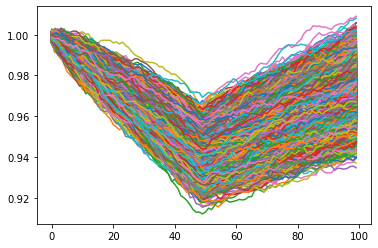

In [3]:
from scipy.stats import norm
def gen_toy_sample(x0,n):
    x0 = np.asarray(x0)
    N = norm.rvs(size=(n), scale=1e-3)
    u = np.concatenate((np.random.uniform(-1.5e-3,-8e-4,int(n/2)),np.random.uniform(4e-4,8e-4,int(n/2))))
    r = N+u
    out = np.empty(r.shape)
    np.cumsum(r, axis=-1, out=out)
    out += np.expand_dims(x0, axis=-1)
    return out
toy_sample_n = 10000
toy_sample = []
for i in range(toy_sample_n):
    toy_sample.append(gen_toy_sample(1,100))
toy_sample = np.array(toy_sample)

toy_sample_price_scenarios = np.empty(toy_sample.shape)
for i in range(toy_sample_n):
    toy_sample_price_scenarios[i,:] = toy_sample[i,:] #np.log(toy_sample[i,:]/toy_sample[i,0])
    plt.plot(list(range(100)),toy_sample_price_scenarios[i,:])

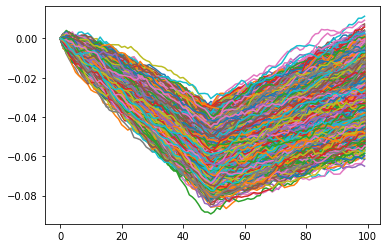

In [4]:
toy_sample_price_scenarios=np.log(toy_sample_price_scenarios[:,:]/toy_sample_price_scenarios[:,0].reshape(-1,1))
for i in range(toy_sample_n):
    plt.plot(list(range(100)),toy_sample_price_scenarios[i,:])

In [5]:
toy_sample_tensor = torch.tensor(toy_sample_price_scenarios).cuda()
dataloader = torch.utils.data.DataLoader(toy_sample_tensor, batch_size=batch_size,drop_last=True,shuffle=True)

In [6]:
data_df = pd.read_csv("./data/Portfolios_Formed_on_ME_daily.csv", error_bad_lines=False)

C:\Users\ytc19\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
data_df["Lo 30"].apply(lambda x:x.split()[-1] if type(x)==str else x)[0]

'0.39'

In [7]:
# lo30_df=data_df["Lo 30"].apply(lambda x:x.split()[-1] if type(x)==str else x).apply(float)
# lo30_df=lo30_df.fillna(lo30_df.mean())
# lo30_data=lo30_df.to_numpy(dtype=np.float32).reshape(1,-1)
# lo30_data = torch.tensor(lo30_data,).cuda()
# dataset = PriceScenarioDataset(lo30_data,pnl_size, 1,True)
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,drop_last=True,shuffle=True)
# for i in dataloader:
#     print(i[0].shape,i[-1].shape)
#     break
# len(dataset)

In [15]:
torch.ones_like(torch.tensor((2,1)))+0

tensor([1, 1])

In [6]:
import torch.optim as optim
from tqdm import tqdm
generator = Generator(noise_size=noise_size,
                      pnl_size=pnl_size,market_size=batch_size
                     ).to(device)
discriminator = Discriminator(pnl_size=pnl_size).to(device)
disc_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
scheduler_disc = torch.optim.lr_scheduler.CosineAnnealingLR(disc_optimizer, T_max=1000, eta_min=0)
gen_optimizer = optim.Adam(generator.parameters(), lr=lr)
scheduler_gen = torch.optim.lr_scheduler.CosineAnnealingLR(gen_optimizer, T_max=1000, eta_min=0)

Discriminator Loss: 0.00035244 Generator Loss: -0.05984788:   1%|▏                    | 9/1000 [00:17<30:48,  1.86s/it]

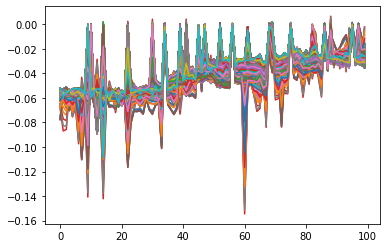

Discriminator Loss: 0.00070772 Generator Loss: -0.03465375:   2%|▍                   | 19/1000 [00:37<30:29,  1.86s/it]

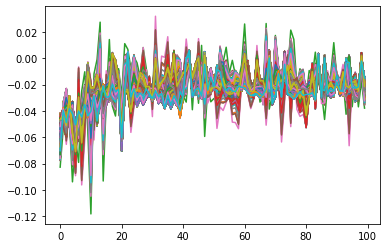

Discriminator Loss: 0.00049573 Generator Loss: -0.01869786:   3%|▌                   | 29/1000 [00:57<30:15,  1.87s/it]

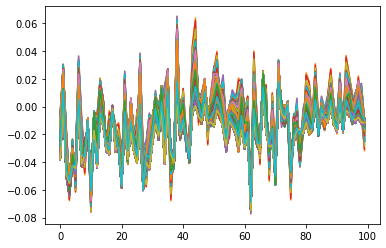

Discriminator Loss: 0.00010054 Generator Loss: -0.01312326:   4%|▊                   | 39/1000 [01:17<30:05,  1.88s/it]

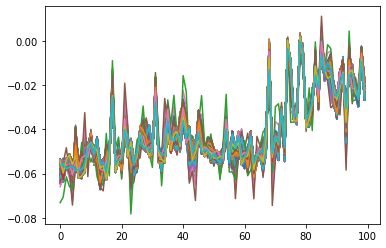

Discriminator Loss: 0.00001692 Generator Loss: -0.01043633:   5%|▉                   | 49/1000 [01:37<29:37,  1.87s/it]

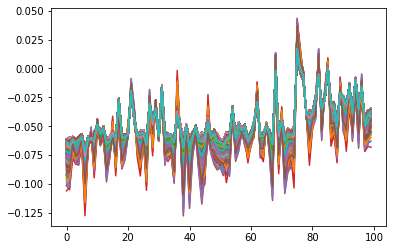

Discriminator Loss: 0.00005068 Generator Loss: -0.00622963:   6%|█▏                  | 59/1000 [01:57<29:48,  1.90s/it]

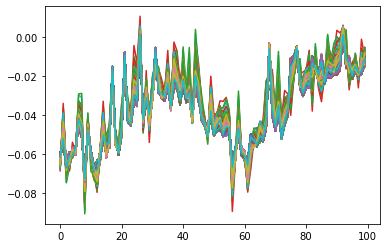

Discriminator Loss: -0.00001428 Generator Loss: -0.00638377:   7%|█▎                 | 69/1000 [02:17<29:04,  1.87s/it]

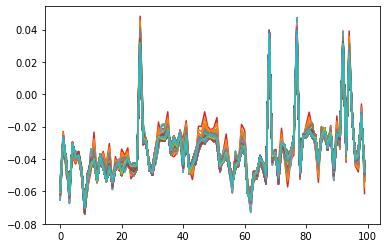

Discriminator Loss: -0.01190304 Generator Loss: -0.06972149:   8%|█▌                 | 79/1000 [02:37<29:38,  1.93s/it]

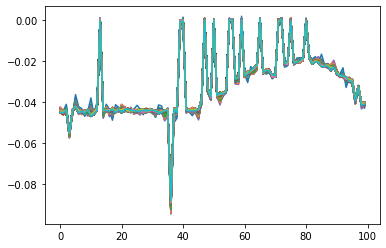

Discriminator Loss: 0.00781937 Generator Loss: -0.30991456:   9%|█▊                  | 89/1000 [02:57<28:48,  1.90s/it]

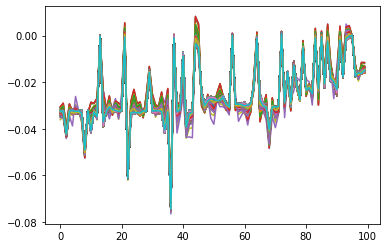

Discriminator Loss: -0.00826900 Generator Loss: -0.50528854:  10%|█▉                 | 99/1000 [03:17<28:08,  1.87s/it]

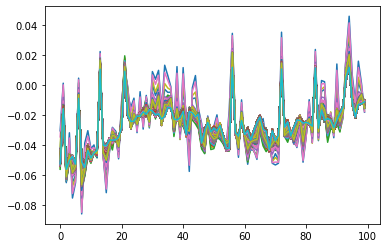

Discriminator Loss: 0.00373816 Generator Loss: -0.24741086:  11%|██                 | 109/1000 [03:37<27:46,  1.87s/it]

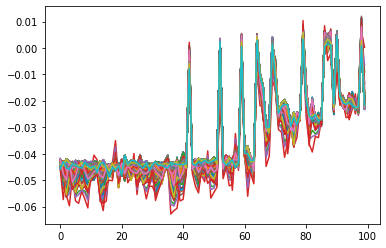

Discriminator Loss: -0.00375374 Generator Loss: -0.26712999:  12%|██▏               | 119/1000 [04:07<53:52,  3.67s/it]

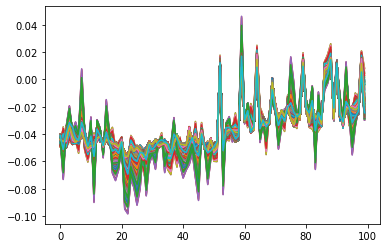

Discriminator Loss: -2.36184263 Generator Loss: 22.23884201:  13%|██▎               | 129/1000 [04:35<33:33,  2.31s/it]

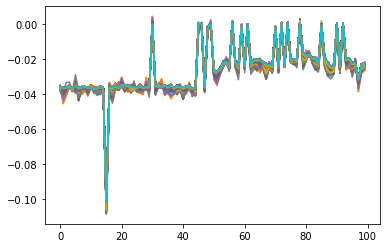

Discriminator Loss: -272.65734863 Generator Loss: 977.90673828:  14%|██             | 139/1000 [04:55<27:20,  1.91s/it]

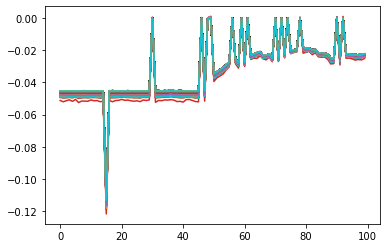

Discriminator Loss: -532.54492188 Generator Loss: 1818.59057617:  15%|██            | 149/1000 [05:15<26:53,  1.90s/it]

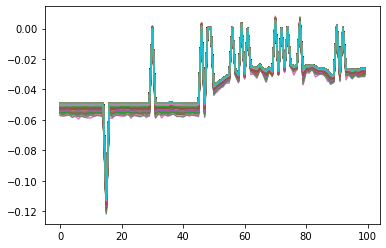

Discriminator Loss: 2323.67138672 Generator Loss: 6598.36621094:  16%|██▏           | 159/1000 [05:35<26:50,  1.92s/it]

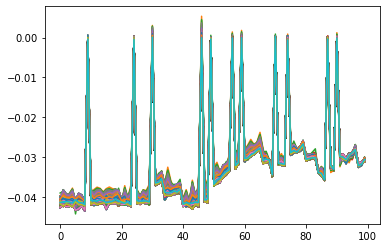

Discriminator Loss: 1851.60876465 Generator Loss: 5741.83496094:  17%|██▎           | 169/1000 [05:56<26:59,  1.95s/it]

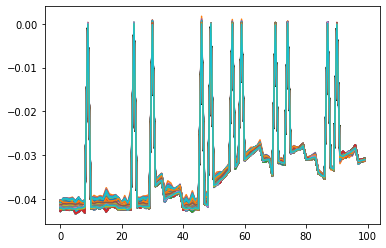

Discriminator Loss: 147.29704285 Generator Loss: 4819.29248047:  18%|██▋            | 179/1000 [06:16<26:11,  1.91s/it]

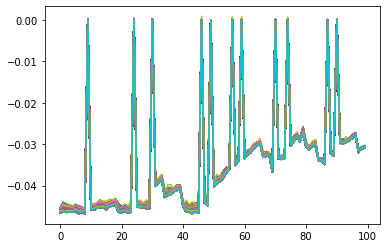

Discriminator Loss: 655.57147217 Generator Loss: 3439.72216797:  19%|██▊            | 189/1000 [06:37<25:44,  1.90s/it]

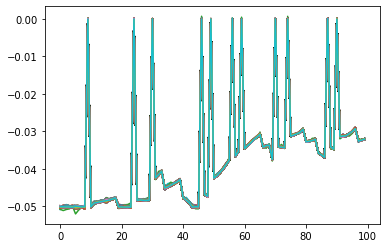

Discriminator Loss: 948.75207520 Generator Loss: 3065.42382812:  20%|██▉            | 199/1000 [06:57<25:16,  1.89s/it]

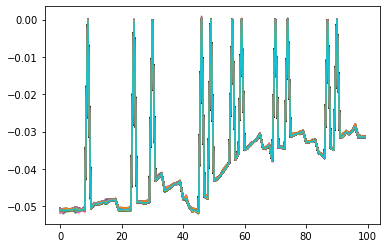

Discriminator Loss: 150.00048828 Generator Loss: 2692.44873047:  21%|███▏           | 209/1000 [07:17<25:03,  1.90s/it]

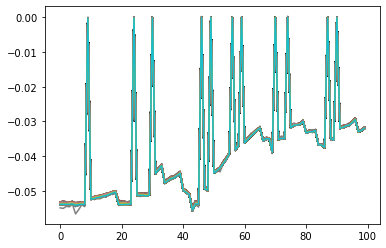

Discriminator Loss: 417.96087646 Generator Loss: 2153.53491211:  22%|███▎           | 219/1000 [07:38<24:58,  1.92s/it]

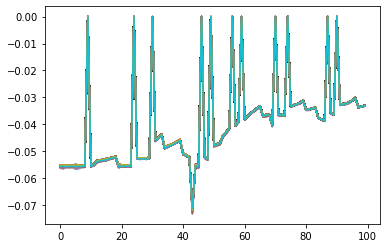

Discriminator Loss: 453.25982666 Generator Loss: 1387.71582031:  23%|███▍           | 229/1000 [07:58<24:49,  1.93s/it]

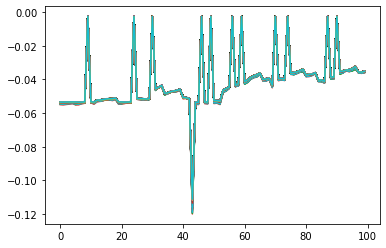

Discriminator Loss: 183.85771179 Generator Loss: 637.05078125:  24%|███▊            | 239/1000 [08:19<24:10,  1.91s/it]

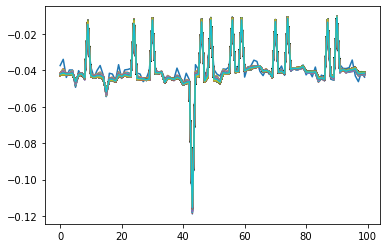

Discriminator Loss: 161.96096802 Generator Loss: 422.65649414:  25%|███▉            | 249/1000 [08:44<38:34,  3.08s/it]

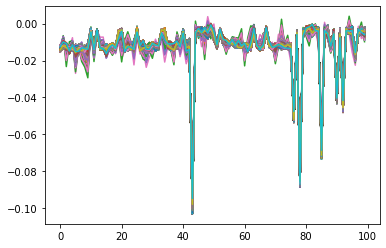

Discriminator Loss: 178.29556274 Generator Loss: 478.99505615:  26%|████▏           | 259/1000 [09:21<31:56,  2.59s/it]

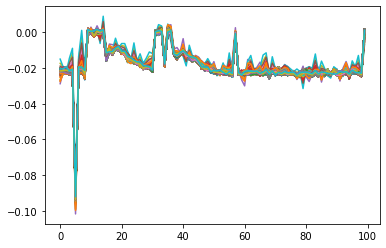

Discriminator Loss: 85.37819672 Generator Loss: 410.73251343:  27%|████▌            | 269/1000 [09:41<23:12,  1.90s/it]

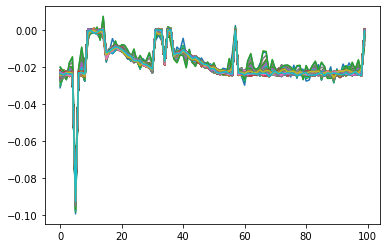

Discriminator Loss: 68.65460205 Generator Loss: 319.70480347:  28%|████▋            | 279/1000 [10:01<22:46,  1.89s/it]

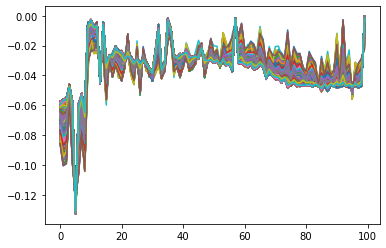

Discriminator Loss: 4.39999676 Generator Loss: 303.17846680:  29%|█████▏            | 289/1000 [10:21<22:16,  1.88s/it]

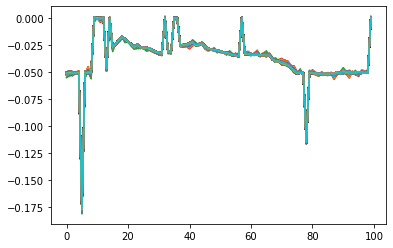

Discriminator Loss: 1.07680511 Generator Loss: 301.14093018:  30%|█████▍            | 299/1000 [10:41<21:55,  1.88s/it]

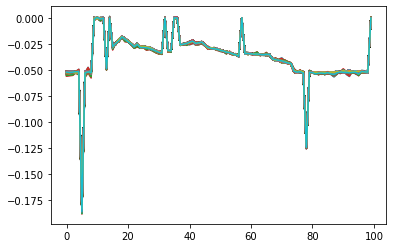

Discriminator Loss: -2.53711319 Generator Loss: 360.51193237:  31%|█████▎           | 309/1000 [11:01<21:37,  1.88s/it]

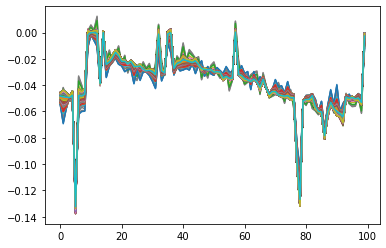

Discriminator Loss: -5.74658966 Generator Loss: 398.13787842:  32%|█████▍           | 319/1000 [11:21<21:18,  1.88s/it]

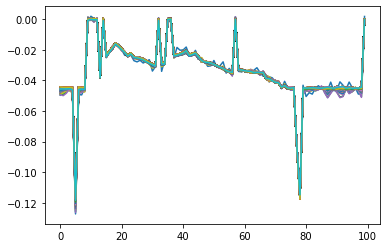

Discriminator Loss: -18.97602654 Generator Loss: 541.33801270:  33%|█████▎          | 329/1000 [11:41<21:06,  1.89s/it]

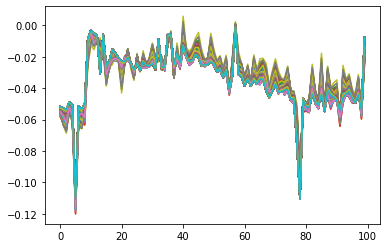

Discriminator Loss: -67.60914612 Generator Loss: 820.83190918:  34%|█████▍          | 339/1000 [12:01<20:48,  1.89s/it]

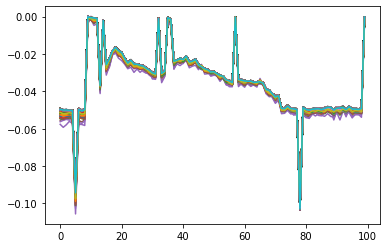

Discriminator Loss: -134.91116333 Generator Loss: 998.07287598:  35%|█████▏         | 349/1000 [12:21<20:26,  1.88s/it]

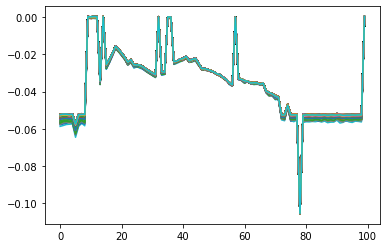

Discriminator Loss: -512.35113525 Generator Loss: 2372.37280273:  36%|█████         | 359/1000 [12:41<20:06,  1.88s/it]

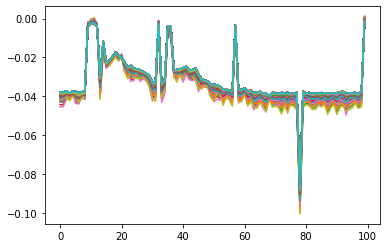

Discriminator Loss: -100.21812439 Generator Loss: 777.26574707:  37%|█████▌         | 369/1000 [13:01<19:48,  1.88s/it]

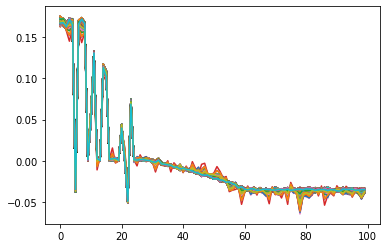

Discriminator Loss: -734.71337891 Generator Loss: 945.09619141:  38%|█████▋         | 379/1000 [13:21<19:28,  1.88s/it]

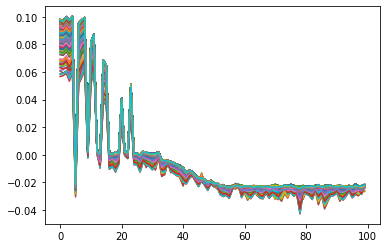

Discriminator Loss: -21.10453415 Generator Loss: 2829.19824219:  39%|█████▊         | 389/1000 [14:05<42:25,  4.17s/it]

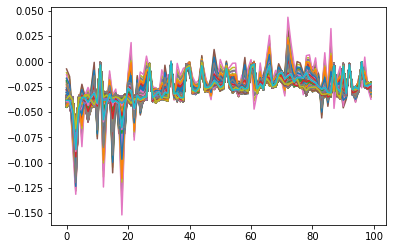

Discriminator Loss: 443.82299805 Generator Loss: 2455.46044922:  40%|█████▉         | 399/1000 [14:41<25:58,  2.59s/it]

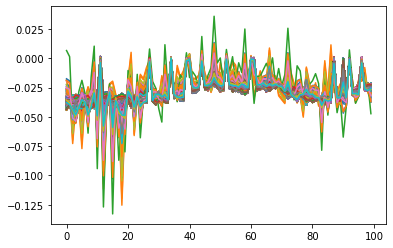

Discriminator Loss: 286.88977051 Generator Loss: 2527.09472656:  41%|██████▏        | 409/1000 [15:14<37:48,  3.84s/it]

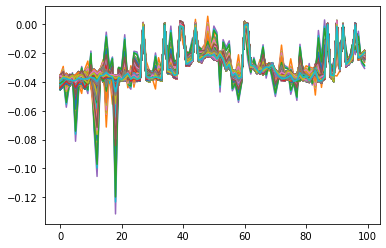

Discriminator Loss: 491.78491211 Generator Loss: 2178.15673828:  42%|██████▎        | 419/1000 [15:58<38:36,  3.99s/it]

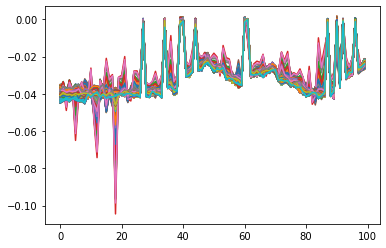

Discriminator Loss: 463.35955811 Generator Loss: 2144.88061523:  43%|██████▍        | 429/1000 [16:44<39:37,  4.16s/it]

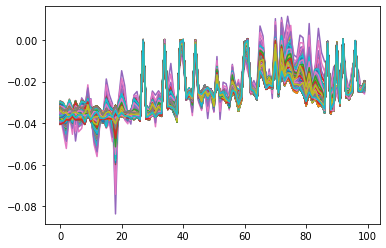

Discriminator Loss: 439.61944580 Generator Loss: 1931.99243164:  44%|██████▌        | 439/1000 [17:30<40:18,  4.31s/it]

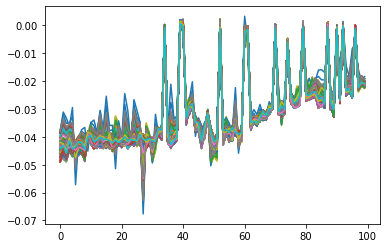

Discriminator Loss: 296.58209229 Generator Loss: 1877.98144531:  45%|██████▋        | 449/1000 [18:14<38:59,  4.25s/it]

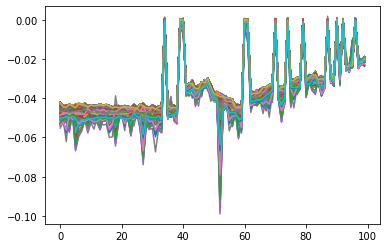

Discriminator Loss: 463.60595703 Generator Loss: 1679.68933105:  46%|██████▉        | 459/1000 [19:01<38:44,  4.30s/it]

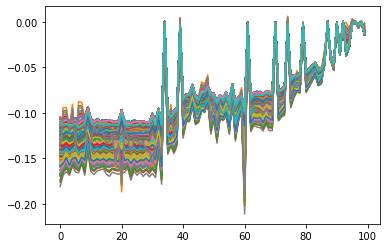

Discriminator Loss: 422.03369141 Generator Loss: 1319.58850098:  47%|███████        | 469/1000 [19:47<38:25,  4.34s/it]

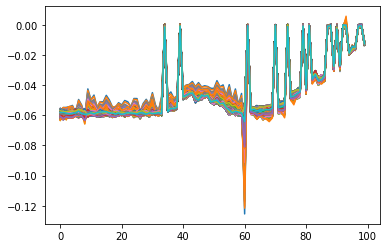

Discriminator Loss: 385.06124878 Generator Loss: 1207.54711914:  48%|███████▏       | 479/1000 [20:31<36:31,  4.21s/it]

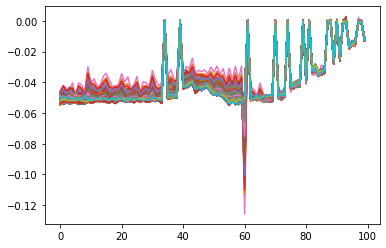

Discriminator Loss: 338.73785400 Generator Loss: 630.28924561:  49%|███████▊        | 489/1000 [21:16<35:17,  4.14s/it]

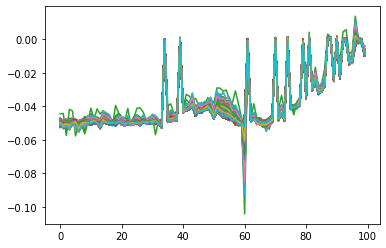

Discriminator Loss: 239.15026855 Generator Loss: 472.45428467:  50%|███████▉        | 499/1000 [22:00<34:18,  4.11s/it]

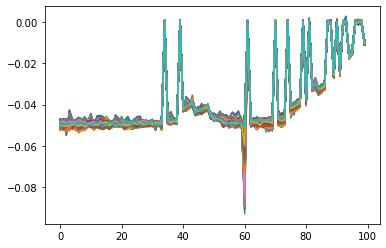

Discriminator Loss: 217.51489258 Generator Loss: 318.87762451:  51%|████████▏       | 509/1000 [22:46<34:35,  4.23s/it]

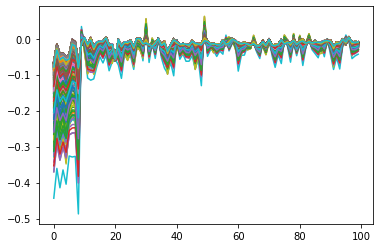

Discriminator Loss: 123.98922729 Generator Loss: 297.18218994:  52%|████████▎       | 519/1000 [23:31<34:34,  4.31s/it]

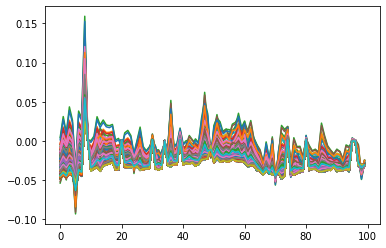

Discriminator Loss: 104.15364838 Generator Loss: 249.46249390:  53%|████████▍       | 529/1000 [24:16<33:18,  4.24s/it]

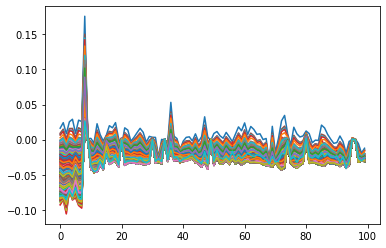

Discriminator Loss: 20.94154930 Generator Loss: 235.43455505:  54%|█████████▏       | 539/1000 [25:02<31:43,  4.13s/it]

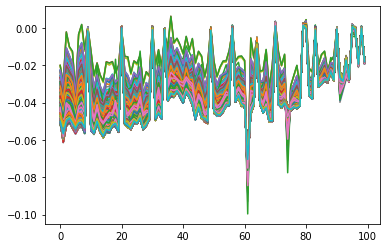

Discriminator Loss: 36.90682602 Generator Loss: 216.16326904:  55%|█████████▎       | 549/1000 [25:25<18:34,  2.47s/it]

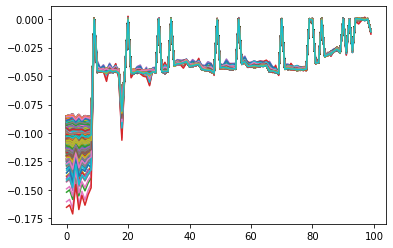

Discriminator Loss: 49.44237900 Generator Loss: 156.97219849:  56%|█████████▌       | 559/1000 [25:59<23:20,  3.18s/it]

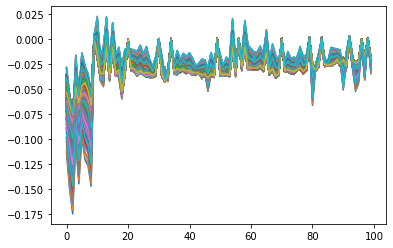

Discriminator Loss: 20.73289490 Generator Loss: 132.31932068:  57%|█████████▋       | 569/1000 [26:32<22:56,  3.19s/it]

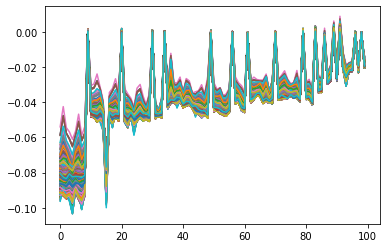

Discriminator Loss: 11.90316772 Generator Loss: 131.98339844:  58%|█████████▊       | 579/1000 [27:05<22:26,  3.20s/it]

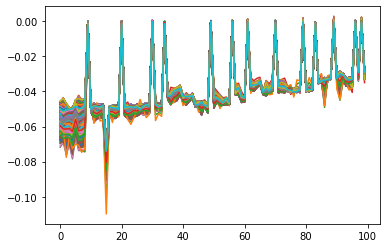

Discriminator Loss: 7.32995892 Generator Loss: 78.74687195:  59%|███████████▏       | 589/1000 [27:38<22:00,  3.21s/it]

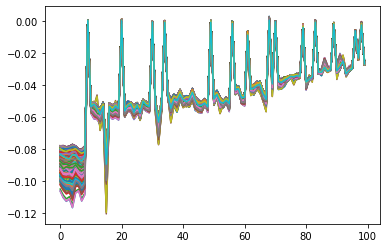

Discriminator Loss: 23.41689873 Generator Loss: 24.68030930:  60%|██████████▊       | 599/1000 [28:11<21:24,  3.20s/it]

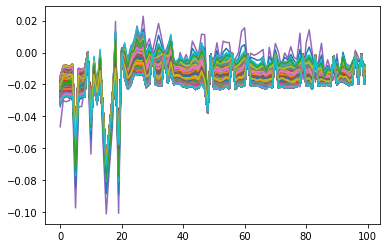

Discriminator Loss: 16.40636826 Generator Loss: 27.55023193:  61%|██████████▉       | 609/1000 [28:45<20:57,  3.22s/it]

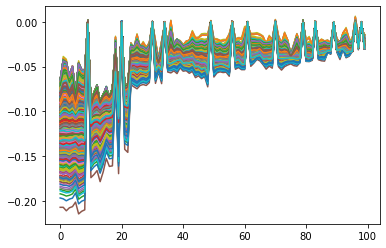

Discriminator Loss: 8.75099945 Generator Loss: 24.76795769:  62%|███████████▊       | 619/1000 [29:18<20:19,  3.20s/it]

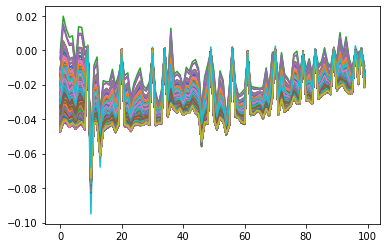

Discriminator Loss: 3.68479156 Generator Loss: 27.94610214:  63%|███████████▉       | 629/1000 [30:02<24:55,  4.03s/it]

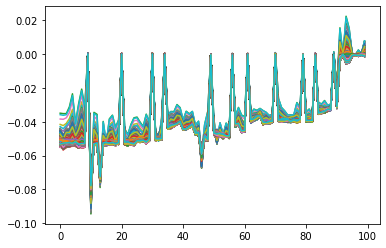

Discriminator Loss: 45.96428680 Generator Loss: 32.84492111:  64%|███████████▌      | 639/1000 [30:51<26:56,  4.48s/it]

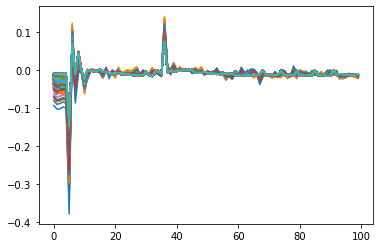

Discriminator Loss: 65.13333893 Generator Loss: -57.87065887:  65%|███████████      | 649/1000 [31:37<24:59,  4.27s/it]

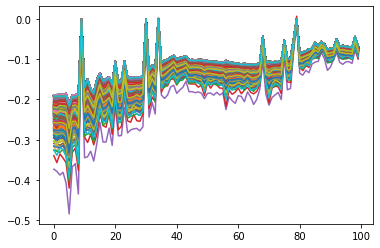

Discriminator Loss: 24.48032761 Generator Loss: 14.13979340:  66%|███████████▊      | 659/1000 [31:57<11:12,  1.97s/it]

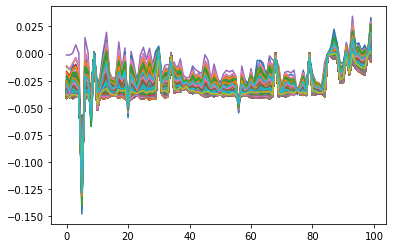

Discriminator Loss: 14.82732677 Generator Loss: -0.78305662:  67%|████████████      | 669/1000 [32:17<10:22,  1.88s/it]

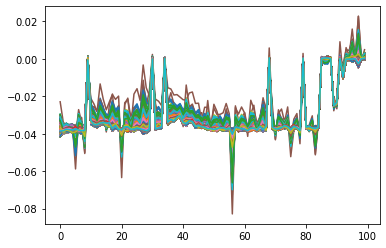

Discriminator Loss: 14.98339844 Generator Loss: 0.90973347:  68%|████████████▉      | 679/1000 [32:38<11:23,  2.13s/it]

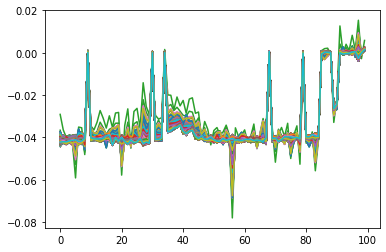

Discriminator Loss: 13.98691559 Generator Loss: -0.29749712:  69%|████████████▍     | 689/1000 [32:59<09:35,  1.85s/it]

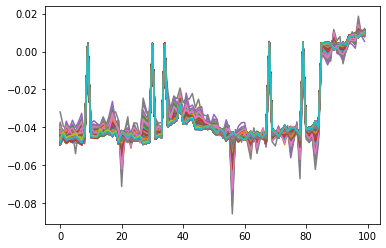

Discriminator Loss: 5.14998055 Generator Loss: 11.40711403:  70%|█████████████▎     | 699/1000 [33:19<09:03,  1.81s/it]

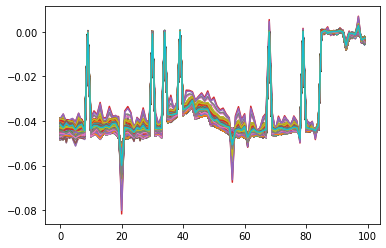

Discriminator Loss: 8.27618217 Generator Loss: 9.30116653:  71%|██████████████▏     | 709/1000 [33:38<08:50,  1.82s/it]

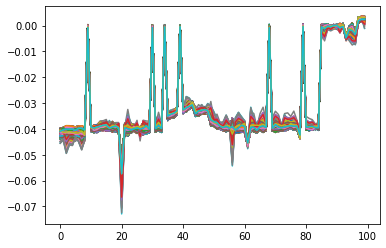

Discriminator Loss: 7.39982700 Generator Loss: 2.61288404:  72%|██████████████▍     | 719/1000 [33:57<08:36,  1.84s/it]

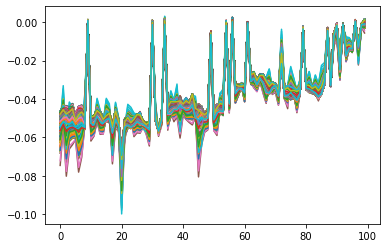

Discriminator Loss: 8.06139278 Generator Loss: 3.01192188:  73%|██████████████▌     | 729/1000 [34:17<08:11,  1.81s/it]

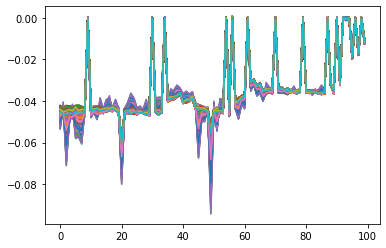

Discriminator Loss: 5.63651276 Generator Loss: 2.32637787:  74%|██████████████▊     | 739/1000 [34:36<07:51,  1.81s/it]

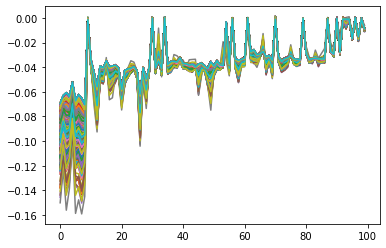

Discriminator Loss: 4.91343498 Generator Loss: -0.79672402:  75%|██████████████▏    | 749/1000 [34:55<07:33,  1.80s/it]

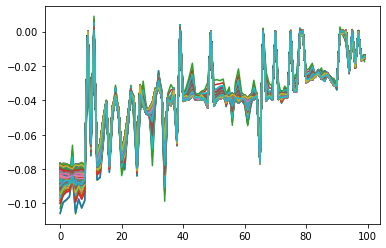

Discriminator Loss: 4.14748144 Generator Loss: 0.19959450:  76%|███████████████▏    | 759/1000 [35:15<07:26,  1.85s/it]

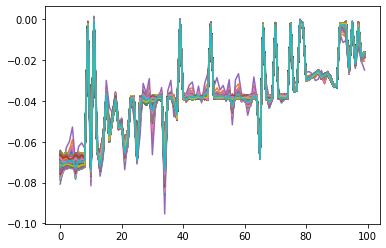

Discriminator Loss: -1.88926888 Generator Loss: -0.86962163:  77%|█████████████▊    | 769/1000 [35:35<07:12,  1.87s/it]

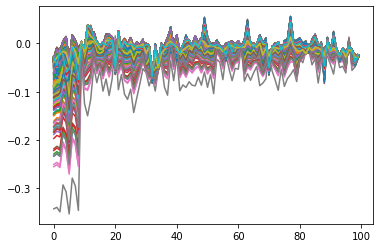

Discriminator Loss: 3.97746325 Generator Loss: -8.04429150:  78%|██████████████▊    | 779/1000 [36:12<14:45,  4.01s/it]

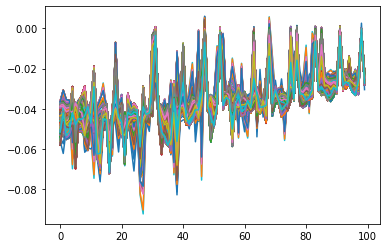

Discriminator Loss: 3.74246693 Generator Loss: -8.31064510:  79%|██████████████▉    | 789/1000 [36:58<15:05,  4.29s/it]

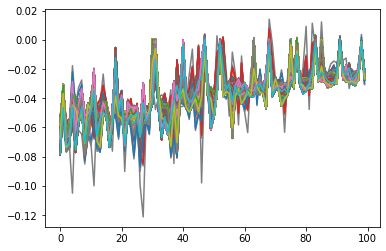

Discriminator Loss: 3.61702037 Generator Loss: -8.35496426:  80%|███████████████▏   | 799/1000 [37:43<14:13,  4.25s/it]

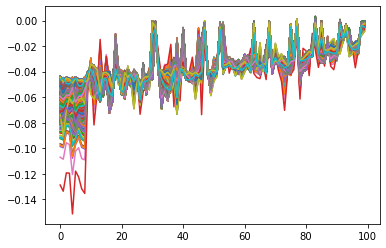

Discriminator Loss: 3.92576933 Generator Loss: -7.54676199:  81%|███████████████▎   | 809/1000 [38:27<13:41,  4.30s/it]

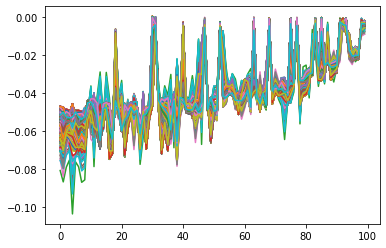

Discriminator Loss: 4.35080004 Generator Loss: -1.09166467:  82%|███████████████▌   | 819/1000 [39:13<12:53,  4.27s/it]

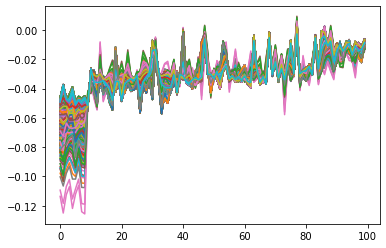

Discriminator Loss: 1.94476700 Generator Loss: -6.53715467:  83%|███████████████▊   | 829/1000 [39:58<11:35,  4.07s/it]

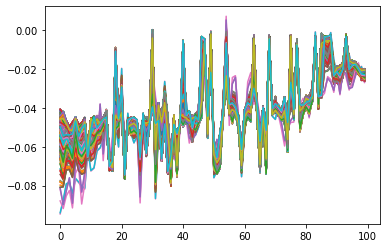

Discriminator Loss: 1.34705544 Generator Loss: -5.17902470:  84%|███████████████▉   | 839/1000 [40:43<11:24,  4.25s/it]

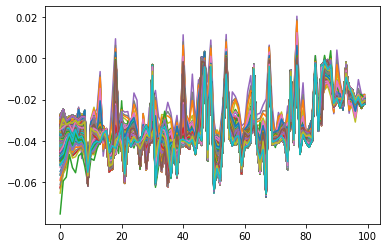

Discriminator Loss: 2.76279736 Generator Loss: -10.18840599:  85%|███████████████▎  | 849/1000 [41:27<10:30,  4.18s/it]

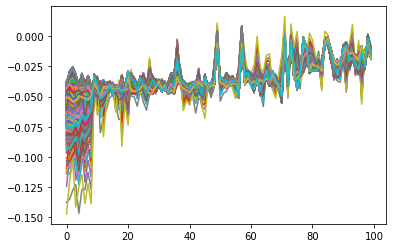

Discriminator Loss: 1.44639730 Generator Loss: -5.36376524:  86%|████████████████▎  | 859/1000 [42:12<10:00,  4.26s/it]

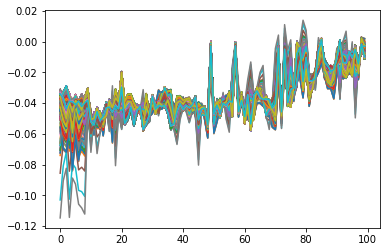

Discriminator Loss: 1.15587616 Generator Loss: 1.14595926:  87%|█████████████████▍  | 869/1000 [42:57<09:04,  4.15s/it]

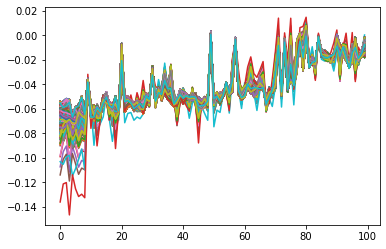

Discriminator Loss: 1.83534217 Generator Loss: -5.55218220:  88%|████████████████▋  | 879/1000 [43:41<08:24,  4.17s/it]

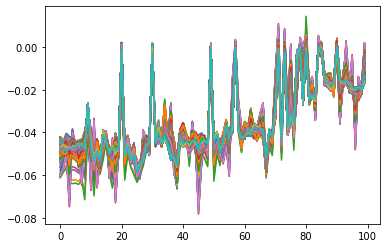

Discriminator Loss: 1.08107138 Generator Loss: -4.08727980:  89%|████████████████▉  | 889/1000 [44:25<07:54,  4.27s/it]

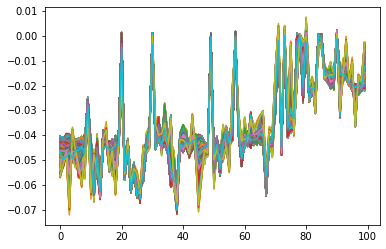

Discriminator Loss: 1.13701081 Generator Loss: -4.71289730:  90%|█████████████████  | 899/1000 [45:11<07:14,  4.31s/it]

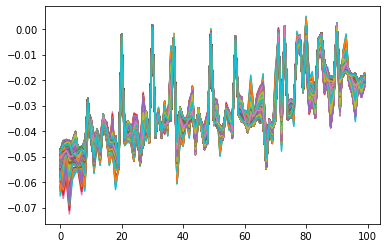

Discriminator Loss: 0.26691151 Generator Loss: -3.78280330:  91%|█████████████████▎ | 909/1000 [45:57<06:14,  4.12s/it]

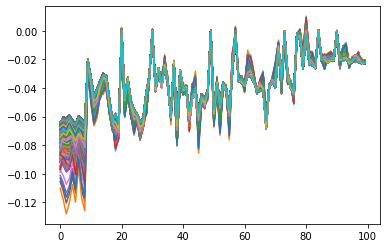

Discriminator Loss: 0.58424920 Generator Loss: -3.29211617:  92%|█████████████████▍ | 919/1000 [46:38<05:26,  4.03s/it]

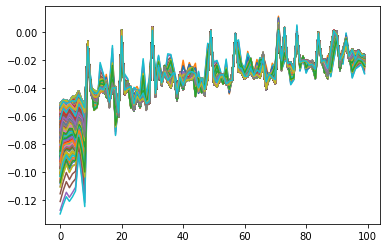

Discriminator Loss: 1.28732002 Generator Loss: -6.76682806:  93%|█████████████████▋ | 929/1000 [47:27<05:25,  4.58s/it]

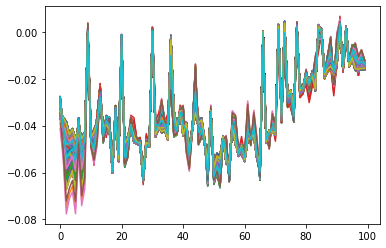

Discriminator Loss: 1.49464178 Generator Loss: -4.00397205:  94%|█████████████████▊ | 939/1000 [48:15<04:36,  4.54s/it]

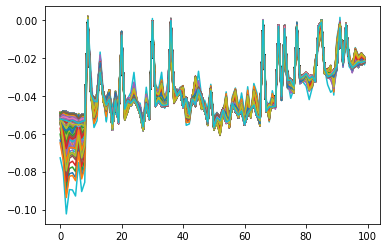

Discriminator Loss: 0.24347512 Generator Loss: -4.51802158:  95%|██████████████████ | 949/1000 [49:05<03:57,  4.65s/it]

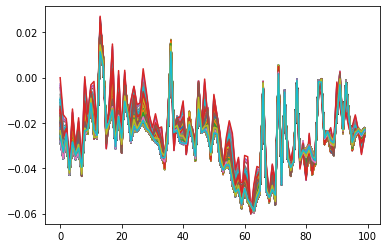

Discriminator Loss: 1.51814067 Generator Loss: -5.03750801:  96%|██████████████████▏| 959/1000 [49:54<03:03,  4.47s/it]

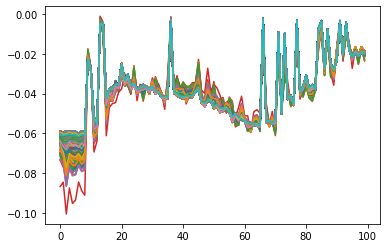

Discriminator Loss: -0.51731938 Generator Loss: 0.20466900:  97%|██████████████████▍| 969/1000 [50:43<02:24,  4.65s/it]

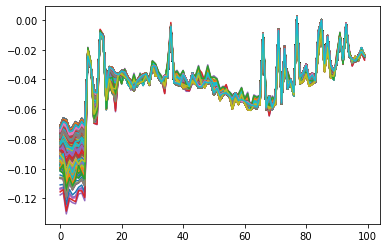

Discriminator Loss: 0.97208309 Generator Loss: -0.85130787:  98%|██████████████████▌| 979/1000 [51:30<01:34,  4.50s/it]

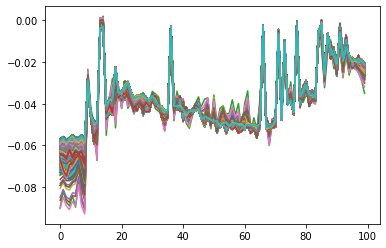

Discriminator Loss: 0.62807769 Generator Loss: -0.30999169:  99%|██████████████████▊| 989/1000 [52:19<00:50,  4.62s/it]

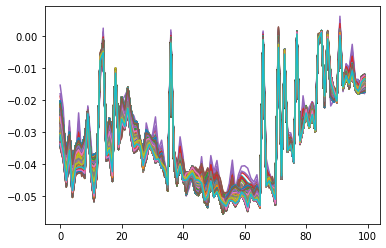

Discriminator Loss: 0.45916924 Generator Loss: -1.24989414: 100%|██████████████████▉| 999/1000 [53:09<00:04,  4.64s/it]

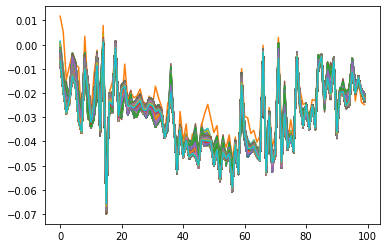

Discriminator Loss: 0.88040638 Generator Loss: 0.77044439: 100%|███████████████████| 1000/1000 [53:17<00:00,  3.20s/it]


In [7]:
train = True
# batch*pnl
signal = 4e-3
trade_strategy_1 = TradingStrategy("buy-hold",10,(0,0),(signal,signal))
trade_strategy_2 = TradingStrategy("MA",10,(0,0),(signal,signal))
trade_strategy_3 = TradingStrategy("MOM",10,(0,0),(signal,signal))
trade_strategy_lst = [trade_strategy_1,trade_strategy_2,trade_strategy_3]
if train:

#     dataset = PriceScenarioDataset(lo30_data,pnl_size, 1,True)
#     dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
#     dataset = Loader32(log_returns_preprocessed, 1)
#     dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    c=0
    t = tqdm(range(1000))
    generator.train()
    discriminator.train()
    for epoch in t:
        for idx, data in enumerate(dataloader, 0):
#             print(data.shape)
            c+=1
#             print(idx,epoch)
            if True: #(idx<=10 and epoch ==0):
                discriminator.zero_grad()
#                 print(data)
                ps_real = data#.permute(0,2,1).squeeze(-1)
    #             score_real = data[-1].reshape(batch_size,-1)

                ps_fake = generator(mean=0, std=1).reshape(batch_size,-1).detach()
                
                disc_loss = 0
                for trade_strategy in trade_strategy_lst:

                    ts_real = trade_strategy.get_strategy_PnL(ps_real)#,torch.ones_like(ps_real))
                    ts_fake = trade_strategy.get_strategy_PnL(ps_fake)#,torch.ones_like(ps_fake))

                    fake_ve = discriminator(ts_fake)
                    fake_v,fake_e = fake_ve[:,0],fake_ve[:,1]
                    real_ve = discriminator(ts_real)
                    real_v,real_e = real_ve[:,0],real_ve[:,1]
#                     if idx % 180 == 0:
#                         print("disc:current fake and real ves: ",fake_ve[0],real_ve[0])


                    disc_loss -= torch.mean(score(fake_v,fake_e,ts_real,0.05)) - \
                                          torch.mean(score(real_v,real_e,ts_real,0.05))

    #             print('Discriminator Loss: %.8f' % (disc_loss.item()))
                disc_loss/=len(trade_strategy_lst)
                disc_loss.backward()

                disc_optimizer.step()
                scheduler_disc.step()
            

#             discriminator.zero_grad()
#             real = data.to(device)
#             batch_size, seq_len = real.size(0), real.size(1)
#             noise = torch.randn(batch_size, nz, seq_len, device=device)
#             fake = generator(noise).detach()
#             disc_loss = -torch.mean(discriminator(real)) + torch.mean(discriminator(fake))
#             disc_loss.backward()
#             disc_optimizer.step()

#             for dp in discriminator.parameters():
#                 dp.data.clamp_(-clip, clip)
    
            if True: #not (idx<=10 and epoch ==0):# or idx % 2 == 0:
                for i in range(1):
                    generator.zero_grad()
                    discriminator.zero_grad()
                    ps_fake = generator(mean=0, std=1).reshape(batch_size,-1)
                    gen_loss = 0
                    for trade_strategy in trade_strategy_lst:
                        ts_real = trade_strategy.get_strategy_PnL(ps_real)
                        ts_fake = trade_strategy.get_strategy_PnL(ps_fake)
                        fake_ve = discriminator(ts_fake)
                        fake_v,fake_e = fake_ve[:,0],fake_ve[:,1]

        #                 print(fake_ve[0],"asdsa")

                        gen_loss += torch.mean(score(fake_v,fake_e,ts_real,0.05))

    #                 gen_loss = -torch.mean(discriminator(generator(noise)))
                    gen_loss/=len(trade_strategy_lst)
                    gen_loss.backward()
                    gen_optimizer.step()
                    scheduler_gen.step()
#                 if idx % 180 == 0:
#                     print("gen:current fake ve: ",fake_ve[0])
                    
        if (epoch+1)%10==0:
            for _ in range(10):
                ps_fake = generator(mean=0, std=1).reshape(batch_size,-1).detach().cpu()
                for i in range(len(ps_fake)):
                    plt.plot(list(range(100)),ps_fake[i])
            plt.show()
            torch.save(generator, f"trained_generator_epoch_{epoch}.pth")
        t.set_description('Discriminator Loss: %.8f Generator Loss: %.8f' % (disc_loss.item(), gen_loss.item()))
            
        # Save

else:
    # Load
    generator = torch.load(f'{generator_path}trained_generator_{file_name}_epoch_{num_epochs-1}.pth')
    generator.eval()

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

disc:current fake and real ves:  tensor([-0.0280,  0.0458], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-0.0208,  0.0488], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-0.0171,  0.0503], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-0.0242,  0.0465], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([-0.0327,  0.0473], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-0.0255,  0.0464], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-0.0750,  0.0487], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -39618.51538706 Generator Loss: 109780.07576593:   0%|            | 1/1000 [00:02<42:40,  2.56s/it]

disc:current fake and real ves:  tensor([ 223.7717, -199.7512], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.4092, -5.8469], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([110.5229, -98.6940], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 163.9985, -146.4181], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 239.1940, -213.5205], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 222.3717, -198.4986], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 265.0601, -237.6570], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -165997344.15323257 Generator Loss: 531397476.41163117:   0%|     | 2/1000 [00:04<31:53,  1.92s/it]

disc:current fake and real ves:  tensor([ 20531.7793, -20142.9238], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-12552.4619,  13037.6357], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 19856.4336, -19479.9961], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 23758.9531, -23308.8066], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 19004.8770, -18646.4355], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 23126.9160, -22691.0078], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 19481.4492, -19118.7852], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -11809816125.58416367 Generator Loss: 37134925382.76610565:   0%| | 3/1000 [00:05<28:40,  1.73s/it]

disc:current fake and real ves:  tensor([ 178214.9531, -176507.4062], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-4333.1230,  7665.3325], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 178116.7812, -176333.0469], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 182125.0625, -180375.3750], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 171635.6094, -169999.5781], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 169097.9375, -167483.4062], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 167697.5000, -166102.7188], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -112052593865.37208557 Generator Loss: 451607828419.89624023:   0%| | 4/1000 [00:07<27:14,  1.64s/i

disc:current fake and real ves:  tensor([ 551369.8750, -547863.5625], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-109942.6406,  119077.0078], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 546853.3125, -543376.3125], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 576491.3750, -572825.6875], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 567865.2500, -564266.1250], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 603692.6875, -599872.2500], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 575678.3125, -572020.2500], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -480269846968.78552246 Generator Loss: 1952479352284.71386719:   0%| | 5/1000 [00:08<26:55,  1.62s/

disc:current fake and real ves:  tensor([ 1211165.3750, -1204995.0000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-385373.7500,  412306.0000], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1170012.7500, -1164028.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 1253013.3750, -1246604.0000], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1183737.7500, -1177712.1250], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 1239993.8750, -1233691.7500], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1194867.6250, -1188809.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -1619049289075.97607422 Generator Loss: 4905760049079.96582031:   1%| | 6/1000 [00:10<26:23,  1.59s

disc:current fake and real ves:  tensor([ 1888791.1250, -1880446.0000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 468170.8438, -439363.0625], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1932727.6250, -1924188.6250], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 1890521.7500, -1882170.7500], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1873393.5000, -1865137.8750], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 1887994.8750, -1879661.7500], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1880531.7500, -1872194.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -2773731285278.86914062 Generator Loss: 9783726541059.12304688:   1%| | 7/1000 [00:11<26:17,  1.59s

disc:current fake and real ves:  tensor([ 2678109.5000, -2667364.7500], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-43563.2695, 101108.9297], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2639174.2500, -2628560.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 2674569., -2663823.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2655396.2500, -2644757.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 2660668.5000, -2650001.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2661810.7500, -2651363.0000], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -4417347881770.46386719 Generator Loss: 14275249750528.06054688:   1%| | 8/1000 [00:13<26:14,  1.59

disc:current fake and real ves:  tensor([ 3207123.5000, -3194914.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 172121.0312, -100141.2812], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3198826.5000, -3186650.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 3237935.2500, -3225603.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3197172.7500, -3185011.0000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 3213650.2500, -3201447.7500], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3203971.5000, -3191602.2500], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -8058544029589.97851562 Generator Loss: 17199789956448.67968750:   1%| | 9/1000 [00:14<25:49,  1.56

disc:current fake and real ves:  tensor([ 3990920.5000, -3976454.2500], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-147591.9375,  247583.3750], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4106620.0000, -4091632.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 3694140.2500, -3680717.2500], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3502464.5000, -3489966.0000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 3672274.7500, -3658962.7500], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3515531.0000, -3502941.2500], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -6019426606849.41601562 Generator Loss: 21712595079974.58984375:   1%| | 10/1000 [00:16<25:54,  1.5

disc:current fake and real ves:  tensor([ 3963515.2500, -3949423.2500], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 454764.4688, -358155.8125], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3940289., -3926272.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4012941.7500, -3998659.2500], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3941232.2500, -3927233.7500], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 3975920.7500, -3961818.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3942034.0000, -3928085.2500], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -6418601747439.15722656 Generator Loss: 22761969963745.54687500:   1%| | 11/1000 [00:17<25:34,  1.5

disc:current fake and real ves:  tensor([ 4052754.0000, -4038505.2500], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-202160.0625,  318181.7812], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4036444.0000, -4022262.2500], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 4214252.0000, -4199409.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4036667.5000, -4022484.2500], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 4140226.5000, -4125754.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4037470.0000, -4023448.7500], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -6527789981663.43164062 Generator Loss: 23148638079051.78515625:   1%| | 12/1000 [00:19<25:23,  1.5

disc:current fake and real ves:  tensor([ 4085445.2500, -4071116.0000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([20021.3594, 90279.7500], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4070663.0000, -4056393.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 4183424.2500, -4168744.7500], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4070885.0000, -4056615.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 4136155.5000, -4121697.0000], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4071221.0000, -4056950.7500], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -6524858766566.16015625 Generator Loss: 23185322907945.86718750:   1%| | 13/1000 [00:20<24:55,  1.5

disc:current fake and real ves:  tensor([ 4088939.5000, -4074657.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-2301816.7500,  2470202.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4074200.5000, -4059978.0000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 4347009.0000, -4331779.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4074063.7500, -4059842.7500], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 4205277., -4190715.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4075400., -4061176.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -6612812538481.82910156 Generator Loss: 23285986545632.10156250:   1%| | 14/1000 [00:22<24:37,  1.5

disc:current fake and real ves:  tensor([ 4098348.2500, -4084043.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 701693.1875, -606513.5625], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4083012.2500, -4068770.0000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 4273932.5000, -4259011.0000], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4082920.2500, -4068678.2500], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 4224640.0000, -4209964.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4083225.2500, -4068927.2500], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -6779730472900.08691406 Generator Loss: 23828319167073.10156250:   2%| | 15/1000 [00:23<24:51,  1.5

disc:current fake and real ves:  tensor([ 4143943.2500, -4129418.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([183714.5469, -74760.4297], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4130085.5000, -4115618.2500], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 4232049.0000, -4217221.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4130173.7500, -4115705.2500], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 4195954.5000, -4181283.7500], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4131649.5000, -4116954.2500], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -7393942503466.13281250 Generator Loss: 25223946260959.78125000:   2%| | 16/1000 [00:25<24:41,  1.5

disc:current fake and real ves:  tensor([ 4260563.0000, -4245761.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([-1956299.1250,  2119159.7500], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4249403.0000, -4234646.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 4412291.5000, -4396934.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4249401.0000, -4234645.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 4291764.5000, -4276936.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4251747.5000, -4236985.0000], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -8700411275551.21875000 Generator Loss: 28104895837177.63671875:   2%| | 17/1000 [00:26<24:27,  1.4

disc:current fake and real ves:  tensor([ 4492510.5000, -4476924.0000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 348023.2812, -234877.2031], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4485372., -4469821.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4576368.5000, -4560483.0000], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4485508.0000, -4469955.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 4509905.5000, -4494321.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4489640.5000, -4474372.0000], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -7955417970718.02148438 Generator Loss: 29851251278475.44140625:   2%| | 18/1000 [00:28<24:09,  1.4

disc:current fake and real ves:  tensor([ 4982106., -4965677.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2006793.7500,  2189671.2500], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3780304.7500, -3727576.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 4967062.0000, -4950564.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4789576.5000, -4774113.0000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 4863874.0000, -4847808.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4801468.5000, -4785853.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -12356925766030.26171875 Generator Loss: 44589290243832.42968750:   2%| | 19/1000 [00:29<23:59,  1.

disc:current fake and real ves:  tensor([ 5677975.0000, -5660076.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 742268.9375, -604013.8125], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 5644691.0000, -5626881.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 5919377.5000, -5900705.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 5643658.5000, -5625885.0000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 5852852.5000, -5834471.0000], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 5655376.0000, -5637509.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)


Discriminator Loss: -20710274263229.88281250 Generator Loss: 63079131938139.43750000:   2%| | 20/1000 [00:31<23:51,  1.

disc:current fake and real ves:  tensor([ 6827110.5000, -6806833.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 51845.9648, 121304.5312], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6875869., -6855457.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6893316., -6872854.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6717679.0000, -6697829.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 6758519.5000, -6738560.0000], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 6736342., -6716299.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -30788264466645.85156250 Generator Loss: 107957106711862.43750000:   2%| | 21/1000 [00:32<24:05,  1

disc:current fake and real ves:  tensor([ 8803807., -8779571.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 663914.8750, -465425.7188], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8770905., -8746762.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9020063., -8995248.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8778959., -8754877.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8915947., -8891512.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 8807861., -8783817.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -101539565597606.20312500 Generator Loss: 180873209360561.43750000:   2%| | 22/1000 [00:34<24:45,  

disc:current fake and real ves:  tensor([ 12012410., -11904112.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2009055.5000,  2352268.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 15589174., -15549402.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 12339600., -12308188.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 11351333., -11323091.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 11955162., -11924882.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 11505447., -11477214.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -271124544174129.37500000 Generator Loss: 425392011907157.18750000:   2%| | 23/1000 [00:36<25:44,  

disc:current fake and real ves:  tensor([ 17517810., -17477836.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([427750.8438, -73342.5469], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 16982052., -16943214.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 17690774., -17650340.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 17374938., -17335382.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 17856950., -17816330.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 17488964., -17449218.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -289492649445803.37500000 Generator Loss: 988200714258685.00000000:   2%| | 24/1000 [00:37<25:13,  

disc:current fake and real ves:  tensor([ 26471068., -26416536.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2723526.0000,  3257268.7500], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 24967364., -24915766.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 27007848., -26952108.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 26395512., -26341186.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 28290766., -28232610.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 26450122., -26396958.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -717546039847601.75000000 Generator Loss: 2551599661424399.50000000:   2%| | 25/1000 [00:39<25:31, 

disc:current fake and real ves:  tensor([ 40878784., -40808848.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2286624.2500,  2924672.0000], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 37427924., -37363748.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 40760920., -40691096.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 42173316., -42101324.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 45214272., -45137132.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 45254548., -45176928.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1412458536907346.50000000 Generator Loss: 15958345193109328.00000000:   3%| | 26/1000 [00:41<27:00

disc:current fake and real ves:  tensor([ 59390248., -59301508.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7693228.5000,  8531587.0000], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 52712120., -52633180.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 57482064., -57396076.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 59569760., -59480836.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 60677108., -60586500.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 59856172., -59766200.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1767940584703103.00000000 Generator Loss: 8641396033664476.00000000:   3%| | 27/1000 [00:42<26:50,

disc:current fake and real ves:  tensor([ 70363456., -70261600.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8570003.0000, -7674591.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 71134752., -71031832.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 76723816., -76612920.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 77067984., -76956760.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 78704912., -78591248.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 78375144., -78263840.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3125405169766846.50000000 Generator Loss: 13435414300351228.00000000:   3%| | 28/1000 [00:44<26:26

disc:current fake and real ves:  tensor([ 92742064., -92620448.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-318092.0938, 1579444.1250], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 86078024., -85965000.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 90822016., -90702824.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 95859936., -95734432.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 99751656., -99621080.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 96398800., -96267872.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -4532603648839838.00000000 Generator Loss: 19420606975262048.00000000:   3%| | 29/1000 [00:45<26:31

disc:current fake and real ves:  tensor([ 1.0994e+08, -1.0980e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-20749498.,  22596198.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0140e+08, -1.0128e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1163e+08, -1.1149e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.2106e+08, -1.2091e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1989e+08, -1.1974e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.1926e+08, -1.1910e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -5876644877623932.00000000 Generator Loss: 24320156059077012.00000000:   3%| | 30/1000 [00:47<26:35

disc:current fake and real ves:  tensor([ 1.2117e+08, -1.2102e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 40195796., -38860764.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.2149e+08, -1.2134e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2461e+08, -1.2446e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.3229e+08, -1.3213e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2979e+08, -1.2963e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.3248e+08, -1.3231e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -8392375993915853.00000000 Generator Loss: 31822180333639804.00000000:   3%| | 31/1000 [00:49<26:27

disc:current fake and real ves:  tensor([ 1.3634e+08, -1.3617e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-58519668.,  61762664.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.3588e+08, -1.3571e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3880e+08, -1.3863e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.4637e+08, -1.4619e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4835e+08, -1.4816e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.4741e+08, -1.4724e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -6711992593827526.00000000 Generator Loss: 33272726044729440.00000000:   3%| | 32/1000 [00:50<26:35

disc:current fake and real ves:  tensor([ 1.2861e+08, -1.2821e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-990614.5000, 3631130.7500], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5175e+08, -1.5157e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5327e+08, -1.5309e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5344e+08, -1.5325e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5873e+08, -1.5854e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.5351e+08, -1.5334e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -7959437010555524.00000000 Generator Loss: 34885122509412424.00000000:   3%| | 33/1000 [00:52<26:04

disc:current fake and real ves:  tensor([ 1.4286e+08, -1.4270e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 28723664., -26594398.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5826e+08, -1.5808e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5675e+08, -1.5657e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5793e+08, -1.5775e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6591e+08, -1.6573e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.5799e+08, -1.5782e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -9347429977110612.00000000 Generator Loss: 37551575089025104.00000000:   3%| | 34/1000 [00:53<25:15

disc:current fake and real ves:  tensor([ 1.4878e+08, -1.4861e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 53973264., -52245528.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.6440e+08, -1.6422e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6174e+08, -1.6156e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.6384e+08, -1.6366e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6750e+08, -1.6732e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.6389e+08, -1.6371e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -10288465000005900.00000000 Generator Loss: 39473305222676432.00000000:   4%| | 35/1000 [00:55<24:4

disc:current fake and real ves:  tensor([ 1.5236e+08, -1.5218e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 50572264., -48742504.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.6853e+08, -1.6834e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6407e+08, -1.6388e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.6798e+08, -1.6779e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.7038e+08, -1.7018e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.6802e+08, -1.6782e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -10843054176097756.00000000 Generator Loss: 40632681288806256.00000000:   4%| | 36/1000 [00:57<25:5

disc:current fake and real ves:  tensor([ 1.5474e+08, -1.5457e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-16768591.,  19735516.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.7080e+08, -1.7061e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6393e+08, -1.6375e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.7043e+08, -1.7024e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.7387e+08, -1.7369e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.7044e+08, -1.7025e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -10796998451096702.00000000 Generator Loss: 41118814781179200.00000000:   4%| | 37/1000 [00:58<26:5

disc:current fake and real ves:  tensor([ 1.5540e+08, -1.5521e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3546224.,  6289361.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.7182e+08, -1.7162e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6587e+08, -1.6568e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.7145e+08, -1.7126e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.7396e+08, -1.7376e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.7140e+08, -1.7120e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -10969366695491244.00000000 Generator Loss: 41245287442363768.00000000:   4%| | 38/1000 [01:00<26:3

disc:current fake and real ves:  tensor([ 1.5504e+08, -1.5486e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 44560020., -42591548.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.7204e+08, -1.7185e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6959e+08, -1.6940e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.7177e+08, -1.7158e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.7159e+08, -1.7140e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.7171e+08, -1.7152e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -10900695959203762.00000000 Generator Loss: 41247641326159000.00000000:   4%| | 39/1000 [01:02<26:4

disc:current fake and real ves:  tensor([ 1.5557e+08, -1.5540e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3326102.2500,  6099438.0000], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.7208e+08, -1.7189e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6424e+08, -1.6406e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.7171e+08, -1.7152e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.7305e+08, -1.7286e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.7171e+08, -1.7152e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -11049759606910650.00000000 Generator Loss: 41393496814697792.00000000:   4%| | 40/1000 [01:03<25:3

disc:current fake and real ves:  tensor([ 1.5578e+08, -1.5559e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 14824199., -12350744.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.7231e+08, -1.7210e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6652e+08, -1.6632e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.7205e+08, -1.7184e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.7438e+08, -1.7418e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.7205e+08, -1.7184e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -11373705239403980.00000000 Generator Loss: 41829866419181608.00000000:   4%| | 41/1000 [01:05<25:5

disc:current fake and real ves:  tensor([ 1.5568e+08, -1.5549e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 15310393., -12824667.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.7325e+08, -1.7305e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6982e+08, -1.6962e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.7279e+08, -1.7260e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.7391e+08, -1.7371e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.7297e+08, -1.7277e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -11580318270019794.00000000 Generator Loss: 42780041317534648.00000000:   4%| | 42/1000 [01:06<25:3

disc:current fake and real ves:  tensor([ 1.5759e+08, -1.5740e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8279901.5000, -5682577.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.7509e+08, -1.7488e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6518e+08, -1.6499e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.7490e+08, -1.7470e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.7673e+08, -1.7653e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.7493e+08, -1.7473e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -11721616222240120.00000000 Generator Loss: 44391621515377416.00000000:   4%| | 43/1000 [01:08<25:1

disc:current fake and real ves:  tensor([ 1.5803e+08, -1.5785e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 43445000., -41428072.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.7822e+08, -1.7802e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.7251e+08, -1.7231e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.7819e+08, -1.7799e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.7826e+08, -1.7806e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.7817e+08, -1.7798e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -962035030945936.00000000 Generator Loss: 45665761741929168.00000000:   4%| | 44/1000 [01:10<25:31,

disc:current fake and real ves:  tensor([ 52180700., -50296736.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 51698984., -49850572.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.8158e+08, -1.8138e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.7571e+08, -1.7551e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.8171e+08, -1.8151e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.8263e+08, -1.8243e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.8159e+08, -1.8139e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1997955807056686.50000000 Generator Loss: 48252860857638752.00000000:   4%| | 45/1000 [01:11<24:52

disc:current fake and real ves:  tensor([ 1.2141e+08, -1.2126e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 62156468., -60681624.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.4210e+08, -1.4193e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.7298e+08, -1.7277e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.8578e+08, -1.8556e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.7672e+08, -1.7651e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.8692e+08, -1.8669e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -16588485181644236.00000000 Generator Loss: 48419754835268536.00000000:   5%| | 46/1000 [01:13<24:3

disc:current fake and real ves:  tensor([ 1.9736e+08, -1.9711e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 63137628., -61677708.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.8256e+08, -1.8233e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.8062e+08, -1.8038e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.8623e+08, -1.8599e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.8753e+08, -1.8729e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.8739e+08, -1.8716e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -17520436628210964.00000000 Generator Loss: 55766541847521960.00000000:   5%| | 47/1000 [01:14<25:1

disc:current fake and real ves:  tensor([ 2.0168e+08, -2.0146e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 57227144., -55825300.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.8859e+08, -1.8838e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.9120e+08, -1.9099e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.0356e+08, -2.0334e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.9700e+08, -1.9678e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.0341e+08, -2.0317e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -12236500115251524.00000000 Generator Loss: 57201062518747776.00000000:   5%| | 48/1000 [01:16<25:4

disc:current fake and real ves:  tensor([ 1.8249e+08, -1.8229e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 97328056., -96417000.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.0253e+08, -2.0231e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.0218e+08, -2.0196e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.0227e+08, -2.0205e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.0434e+08, -2.0412e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.0242e+08, -2.0217e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -14244113874552660.00000000 Generator Loss: 63943317239220296.00000000:   5%| | 49/1000 [01:18<26:0

disc:current fake and real ves:  tensor([ 1.9368e+08, -1.9345e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1033e+08, -1.0965e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.1433e+08, -2.1408e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.1506e+08, -2.1481e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.1379e+08, -2.1354e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.1888e+08, -2.1863e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.1395e+08, -2.1368e+08], device='cuda:0', grad_fn=<SelectBackward0>)


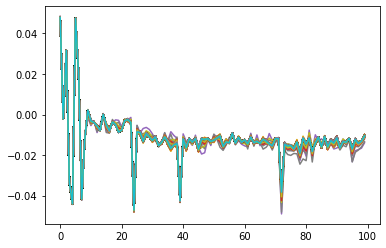

Discriminator Loss: -16716360284060060.00000000 Generator Loss: 72957251565504288.00000000:   5%| | 50/1000 [01:21<32:0

disc:current fake and real ves:  tensor([ 2.0756e+08, -2.0732e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 79024712., -78550352.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.2896e+08, -2.2870e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.2516e+08, -2.2491e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.2835e+08, -2.2809e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.3398e+08, -2.3371e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.2856e+08, -2.2829e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -19137472457843768.00000000 Generator Loss: 84514051252883440.00000000:   5%| | 51/1000 [01:22<30:1

disc:current fake and real ves:  tensor([ 2.1926e+08, -2.1900e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 55704920., -55787856.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.4610e+08, -2.4581e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.4206e+08, -2.4177e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.4584e+08, -2.4555e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.4946e+08, -2.4917e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.4607e+08, -2.4582e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 10899820852975458.00000000 Generator Loss: 93682463033922032.00000000:   5%| | 52/1000 [01:24<28:25

disc:current fake and real ves:  tensor([-1.2621e+08,  1.2437e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 76923968., -77553328.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.5114e+08, -2.5089e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.5623e+08, -2.5597e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.5421e+08, -2.5396e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.6612e+08, -2.6586e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.5399e+08, -2.5374e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -29283253515386856.00000000 Generator Loss: 115486581936025504.00000000:   5%| | 53/1000 [01:25<27:

disc:current fake and real ves:  tensor([ 2.7773e+08, -2.7747e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2936e+08, -1.3027e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.7677e+08, -2.7651e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.7830e+08, -2.7804e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.8474e+08, -2.8447e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.8313e+08, -2.8287e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.8559e+08, -2.8531e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -44183510606165152.00000000 Generator Loss: 146156721523311360.00000000:   5%| | 54/1000 [01:27<27:

disc:current fake and real ves:  tensor([ 3.2018e+08, -3.1991e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2938874.5000, -6113742.5000], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.0114e+08, -3.0089e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.0704e+08, -3.0679e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.2203e+08, -3.2177e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.1704e+08, -3.1677e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.2190e+08, -3.2161e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -51290489977953448.00000000 Generator Loss: 172170496578975680.00000000:   6%| | 55/1000 [01:29<26:

disc:current fake and real ves:  tensor([ 3.4111e+08, -3.4084e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 93964256., -96909736.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.3496e+08, -3.3468e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.4059e+08, -3.4031e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.4988e+08, -3.4959e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.4935e+08, -3.4906e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.5839e+08, -3.5809e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -56114454254130528.00000000 Generator Loss: 198113729526735904.00000000:   6%| | 56/1000 [01:30<25:

disc:current fake and real ves:  tensor([ 3.6926e+08, -3.6899e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.2022e+08,  1.1322e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.5973e+08, -3.5947e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.7003e+08, -3.6976e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.7910e+08, -3.7882e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.9649e+08, -3.9620e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.7959e+08, -3.7929e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -54287256623690464.00000000 Generator Loss: 222400945404211200.00000000:   6%| | 57/1000 [01:32<24:

disc:current fake and real ves:  tensor([ 3.7211e+08, -3.7197e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-84418656.,  77076520.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.8965e+08, -3.8937e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.0660e+08, -4.0630e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.9851e+08, -3.9823e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.3035e+08, -4.3004e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.9893e+08, -3.9863e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -71815371393840560.00000000 Generator Loss: 249136683251601504.00000000:   6%| | 58/1000 [01:33<26:

disc:current fake and real ves:  tensor([ 4.1214e+08, -4.1185e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 13469249., -19878640.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.0311e+08, -4.0283e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.1350e+08, -4.1321e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.2723e+08, -4.2693e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.3044e+08, -4.3014e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.2771e+08, -4.2740e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -77545148601741264.00000000 Generator Loss: 252519851584159840.00000000:   6%| | 59/1000 [01:35<25:

disc:current fake and real ves:  tensor([ 4.3677e+08, -4.3647e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-22028422.,  14563237.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.2358e+08, -4.2329e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.2268e+08, -4.2240e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.2530e+08, -4.2500e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.3246e+08, -4.3215e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.2483e+08, -4.2452e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -79101291055815552.00000000 Generator Loss: 262874639789035936.00000000:   6%| | 60/1000 [01:37<25:

disc:current fake and real ves:  tensor([ 4.3589e+08, -4.3559e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-51649728.,  43415924.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.3372e+08, -4.3342e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.3335e+08, -4.3308e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.3336e+08, -4.3306e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.5223e+08, -4.5192e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.3351e+08, -4.3318e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -80962556358523472.00000000 Generator Loss: 270767941652085696.00000000:   6%| | 61/1000 [01:38<24:

disc:current fake and real ves:  tensor([ 4.4075e+08, -4.4044e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-72920408.,  64209840.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.3971e+08, -4.3940e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.3603e+08, -4.3575e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.3988e+08, -4.3957e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.5507e+08, -4.5475e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.3993e+08, -4.3962e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -83299987002920048.00000000 Generator Loss: 274849537025788032.00000000:   6%| | 62/1000 [01:40<24:

disc:current fake and real ves:  tensor([ 4.4328e+08, -4.4298e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 39407120., -46220828.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.4301e+08, -4.4271e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.4207e+08, -4.4179e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.4318e+08, -4.4288e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.5108e+08, -4.5077e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.4318e+08, -4.4288e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -83457235772742912.00000000 Generator Loss: 276423409659048320.00000000:   6%| | 63/1000 [01:41<24:

disc:current fake and real ves:  tensor([ 4.4491e+08, -4.4461e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 15687847., -22930850.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.4429e+08, -4.4399e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.4042e+08, -4.4015e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.4444e+08, -4.4414e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.6590e+08, -4.6558e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.4446e+08, -4.4416e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -82686552266416256.00000000 Generator Loss: 276738231456746624.00000000:   6%| | 64/1000 [01:43<23:

disc:current fake and real ves:  tensor([ 4.4475e+08, -4.4443e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.9603e+08, -2.0003e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.4449e+08, -4.4417e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.4702e+08, -4.4670e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.4471e+08, -4.4438e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.5165e+08, -4.5132e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.4471e+08, -4.4438e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -83905003195308704.00000000 Generator Loss: 276793147675122720.00000000:   6%| | 65/1000 [01:44<23:

disc:current fake and real ves:  tensor([ 4.4473e+08, -4.4442e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-33370696.,  25246870.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.4461e+08, -4.4429e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.4443e+08, -4.4412e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.4475e+08, -4.4443e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.6572e+08, -4.6538e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.4475e+08, -4.4443e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -83197036186840944.00000000 Generator Loss: 277844304949548640.00000000:   7%| | 66/1000 [01:46<23:

disc:current fake and real ves:  tensor([ 4.4556e+08, -4.4524e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1212e+08, -1.1767e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.4539e+08, -4.4507e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.4518e+08, -4.4486e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.4558e+08, -4.4526e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.4830e+08, -4.4798e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.4560e+08, -4.4528e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -85090847856753200.00000000 Generator Loss: 280690658073106528.00000000:   7%| | 67/1000 [01:47<23:

disc:current fake and real ves:  tensor([ 4.4765e+08, -4.4731e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.9377e+08,  1.8255e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.4773e+08, -4.4740e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.4281e+08, -4.4252e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.4787e+08, -4.4754e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.7039e+08, -4.7004e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.4790e+08, -4.4758e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -87962390618720176.00000000 Generator Loss: 286286217911620480.00000000:   7%| | 68/1000 [01:49<23:

disc:current fake and real ves:  tensor([ 4.5148e+08, -4.5113e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2063e+08, -1.2610e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.5209e+08, -4.5174e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.4922e+08, -4.4889e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.5232e+08, -4.5197e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.6091e+08, -4.6055e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.5237e+08, -4.5204e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -91593484531703360.00000000 Generator Loss: 295379975760249984.00000000:   7%| | 69/1000 [01:50<23:

disc:current fake and real ves:  tensor([ 4.5798e+08, -4.5765e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.1043e+08, -2.1440e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.5925e+08, -4.5892e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.6200e+08, -4.6167e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.5944e+08, -4.5911e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.6087e+08, -4.6054e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.5954e+08, -4.5922e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -97542192061599424.00000000 Generator Loss: 309053041570599872.00000000:   7%| | 70/1000 [01:52<24:

disc:current fake and real ves:  tensor([ 4.6723e+08, -4.6692e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0911e+08, -1.1510e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.6982e+08, -4.6951e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.6434e+08, -4.6404e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.6994e+08, -4.6963e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.8034e+08, -4.8002e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.7010e+08, -4.6974e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -105780589527096352.00000000 Generator Loss: 328520521787454976.00000000:   7%| | 71/1000 [01:54<25

disc:current fake and real ves:  tensor([ 4.7959e+08, -4.7925e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-22269168.,  13701476.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.8447e+08, -4.8412e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.6999e+08, -4.6966e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.8453e+08, -4.8418e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.9546e+08, -4.9510e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.8471e+08, -4.8434e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -117349344774428384.00000000 Generator Loss: 355033708439711232.00000000:   7%| | 72/1000 [01:55<25

disc:current fake and real ves:  tensor([ 4.9692e+08, -4.9653e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 17992160., -26157776.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 5.0366e+08, -5.0326e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.9555e+08, -4.9516e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 5.0371e+08, -5.0331e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.0319e+08, -5.0280e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 5.0404e+08, -5.0370e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -8115334097271678.00000000 Generator Loss: 437343098824879616.00000000:   7%| | 73/1000 [01:57<25:2

disc:current fake and real ves:  tensor([-4.1171e+08,  3.8768e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 34115332., -42266900.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.1194e+08, -4.1163e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.0665e+08, -5.0627e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.7356e+08, -6.7305e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.3432e+08, -5.3392e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 5.7934e+08, -5.7891e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -139984108723066016.00000000 Generator Loss: 460742205294733056.00000000:   7%| | 74/1000 [01:59<25

disc:current fake and real ves:  tensor([ 5.5695e+08, -5.5656e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 28594394., -37493760.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 5.3832e+08, -5.3794e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.4314e+08, -5.4276e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 5.6894e+08, -5.6854e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.5514e+08, -5.5475e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 5.6851e+08, -5.6807e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -147838423934431104.00000000 Generator Loss: 496579588519727424.00000000:   8%| | 75/1000 [02:00<24

disc:current fake and real ves:  tensor([ 5.8113e+08, -5.8066e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.0399e+07, -6.5891e+03], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 5.4525e+08, -5.4487e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.7377e+08, -5.7332e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.1171e+08, -6.1122e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.0400e+08, -6.0352e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 6.1279e+08, -6.1235e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -80082186486037440.00000000 Generator Loss: 547373516876851264.00000000:   8%| | 76/1000 [02:02<24:

disc:current fake and real ves:  tensor([ 4.6165e+08, -4.6378e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2499e+08, -1.3432e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.1426e+08, -6.1378e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.0834e+08, -6.0786e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.2248e+08, -6.2199e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.2039e+08, -6.1990e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 6.2404e+08, -6.2361e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -194880871243329024.00000000 Generator Loss: 644104069827698560.00000000:   8%| | 77/1000 [02:03<24

disc:current fake and real ves:  tensor([ 6.6561e+08, -6.6516e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 31580480., -44239872.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.3099e+08, -6.3056e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.4181e+08, -6.4138e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.7621e+08, -6.7575e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.5689e+08, -6.5645e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 6.7674e+08, -6.7625e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -233271326064842624.00000000 Generator Loss: 699006890428167168.00000000:   8%| | 78/1000 [02:05<24

disc:current fake and real ves:  tensor([ 7.2633e+08, -7.2583e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.4811e+08,  2.2612e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.8820e+08, -6.8774e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.8700e+08, -6.8654e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 7.0806e+08, -7.0758e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.2973e+08, -7.2923e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 7.0875e+08, -7.0830e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -167901944780735584.00000000 Generator Loss: 736688119345439360.00000000:   8%| | 79/1000 [02:06<23

disc:current fake and real ves:  tensor([ 6.4004e+08, -6.4040e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3219e+08, -1.4600e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 7.2978e+08, -7.2932e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.2412e+08, -7.2365e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 7.2541e+08, -7.2494e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.4367e+08, -7.4319e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 7.2484e+08, -7.2437e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -201781660109094272.00000000 Generator Loss: 806436637554706304.00000000:   8%| | 80/1000 [02:08<23

disc:current fake and real ves:  tensor([ 7.1603e+08, -7.1564e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.3192e+08,  1.0872e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 7.6178e+08, -7.6136e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.5778e+08, -7.5736e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 7.5943e+08, -7.5901e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.0262e+08, -8.0217e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 7.5967e+08, -7.5919e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -228453015524307968.00000000 Generator Loss: 883976806421497856.00000000:   8%| | 81/1000 [02:09<23

disc:current fake and real ves:  tensor([ 7.5312e+08, -7.5270e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.3964e+08,  1.1371e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 7.9664e+08, -7.9619e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.8649e+08, -7.8605e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 7.9473e+08, -7.9428e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.2101e+08, -8.2055e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 7.9520e+08, -7.9471e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -259720677347072256.00000000 Generator Loss: 959857220360045696.00000000:   8%| | 82/1000 [02:11<23

disc:current fake and real ves:  tensor([ 7.8408e+08, -7.8361e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.0892e+08, -3.2277e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.3027e+08, -8.2977e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.2047e+08, -8.1997e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.2818e+08, -8.2768e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.4419e+08, -8.4367e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 8.2860e+08, -8.2806e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -274793925059528896.00000000 Generator Loss: 1029546218625673600.00000000:   8%| | 83/1000 [02:12<2

disc:current fake and real ves:  tensor([ 8.0961e+08, -8.0912e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 68319072., -91364024.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.5967e+08, -8.5914e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.4202e+08, -8.4150e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.5771e+08, -8.5718e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.7576e+08, -8.7521e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 8.5803e+08, -8.5756e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -292042351680478272.00000000 Generator Loss: 1087365343126210688.00000000:   8%| | 84/1000 [02:14<2

disc:current fake and real ves:  tensor([ 8.2816e+08, -8.2782e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.3458e+08, -2.5312e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.8335e+08, -8.8297e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.6960e+08, -8.6923e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.8142e+08, -8.8104e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.8891e+08, -8.8852e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 8.8126e+08, -8.8077e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -309746648795270464.00000000 Generator Loss: 1132054287064984448.00000000:   8%| | 85/1000 [02:16<2

disc:current fake and real ves:  tensor([ 8.4664e+08, -8.4622e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.7425e+08, -2.9182e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.0105e+08, -9.0059e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.8281e+08, -8.8236e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.9937e+08, -8.9892e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.0583e+08, -9.0537e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 8.9966e+08, -8.9912e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -300269905199264832.00000000 Generator Loss: 1161369880975705600.00000000:   9%| | 86/1000 [02:17<2

disc:current fake and real ves:  tensor([ 8.2553e+08, -8.2574e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.3474e+08,  2.0076e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.1260e+08, -9.1228e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.7496e+08, -8.7466e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.1091e+08, -9.1060e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.2447e+08, -9.2414e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 9.1100e+08, -9.1070e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -298140366923327744.00000000 Generator Loss: 1179249818408733696.00000000:   9%| | 87/1000 [02:19<2

disc:current fake and real ves:  tensor([ 8.3470e+08, -8.3443e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5752e+08, -1.7900e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.1921e+08, -9.1869e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.9379e+08, -8.9328e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.1795e+08, -9.1743e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.2753e+08, -9.2700e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 9.1802e+08, -9.1749e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -294844799212553344.00000000 Generator Loss: 1188001976282311680.00000000:   9%| | 88/1000 [02:20<2

disc:current fake and real ves:  tensor([ 8.3385e+08, -8.3371e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.5315e+08, -5.6202e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.2219e+08, -9.2178e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.1670e+08, -9.1630e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.2132e+08, -9.2091e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.2217e+08, -9.2177e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 9.2135e+08, -9.2099e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -295600796824183552.00000000 Generator Loss: 1190232178715349504.00000000:   9%| | 89/1000 [02:22<2

disc:current fake and real ves:  tensor([ 8.3106e+08, -8.3101e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 20051174., -46371496.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.2311e+08, -9.2270e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.8035e+08, -8.7996e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.2222e+08, -9.2181e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.3750e+08, -9.3708e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 9.2220e+08, -9.2180e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -293596997367081664.00000000 Generator Loss: 1190467080287753472.00000000:   9%| | 90/1000 [02:23<2

disc:current fake and real ves:  tensor([ 8.3178e+08, -8.3174e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.7295e+08, -2.9100e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.2318e+08, -9.2280e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.0932e+08, -9.0895e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.2229e+08, -9.2192e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.2540e+08, -9.2502e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 9.2229e+08, -9.2192e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -289951869950723328.00000000 Generator Loss: 1191880688346396160.00000000:   9%| | 91/1000 [02:25<2

disc:current fake and real ves:  tensor([ 8.3049e+08, -8.3032e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.0592e+08, -4.1958e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.2376e+08, -9.2320e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.1082e+08, -9.1026e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.2292e+08, -9.2236e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.2741e+08, -9.2685e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 9.2292e+08, -9.2236e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -284334808122147840.00000000 Generator Loss: 1195692790636879616.00000000:   9%| | 92/1000 [02:26<2

disc:current fake and real ves:  tensor([ 8.2445e+08, -8.2464e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 15211343., -41361516.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.2532e+08, -9.2492e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.8766e+08, -8.8728e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.2443e+08, -9.2403e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.3318e+08, -9.3278e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 9.2444e+08, -9.2403e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -271330640830343936.00000000 Generator Loss: 1206754809224260608.00000000:   9%| | 93/1000 [02:28<2

disc:current fake and real ves:  tensor([ 8.0655e+08, -8.0728e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.6073e+08, -3.7576e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.2948e+08, -9.2900e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.2351e+08, -9.2304e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.2860e+08, -9.2812e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.3140e+08, -9.3092e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 9.2862e+08, -9.2816e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -259559828612035232.00000000 Generator Loss: 1223940053797655040.00000000:   9%| | 94/1000 [02:29<2

disc:current fake and real ves:  tensor([ 7.8275e+08, -7.8439e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.4336e+08, -3.5928e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.3611e+08, -9.3572e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.2304e+08, -9.2266e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.3494e+08, -9.3456e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.3943e+08, -9.3905e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 9.3513e+08, -9.3468e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -170217030694132288.00000000 Generator Loss: 1246396845219750400.00000000:  10%| | 95/1000 [02:31<2

disc:current fake and real ves:  tensor([ 6.1390e+08, -6.2099e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.7276e+08, -1.9407e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.4417e+08, -9.4385e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.9893e+08, -8.9863e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.3283e+08, -9.3251e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.4287e+08, -9.4255e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 9.3405e+08, -9.3371e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -80868119269258480.00000000 Generator Loss: 1395223262702901760.00000000:  10%| | 96/1000 [02:33<23

disc:current fake and real ves:  tensor([ 5.7475e+08, -5.7935e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.6398e+08, -4.7608e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.4838e+08, -8.4801e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.2545e+08, -9.2505e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.9764e+08, -9.9718e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.3726e+08, -9.3685e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 9.9956e+08, -9.9906e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 6973688910697845.00000000 Generator Loss: 1230119010728795904.00000000:  10%| | 97/1000 [02:34<23:2

disc:current fake and real ves:  tensor([ 3.1226e+08, -3.2942e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.7694e+08, -2.9584e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.4573e+08, -9.4527e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.3254e+08, -9.3209e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.5034e+08, -9.4987e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.5046e+08, -9.4999e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 9.5043e+08, -9.4997e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -309473978271538304.00000000 Generator Loss: 1297268330360807680.00000000:  10%| | 98/1000 [02:36<2

disc:current fake and real ves:  tensor([ 9.1542e+08, -9.1503e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.7591e+08, -1.9855e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.4686e+08, -9.4645e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.3969e+08, -9.3929e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.6271e+08, -9.6229e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.7308e+08, -9.7265e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 9.6292e+08, -9.6258e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -392024743176404800.00000000 Generator Loss: 1479036148157005824.00000000:  10%| | 99/1000 [02:37<2

disc:current fake and real ves:  tensor([ 9.8304e+08, -9.8276e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2259e+08, -1.4929e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.6448e+08, -9.6421e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.7651e+08, -9.7624e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0277e+09, -1.0274e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.9958e+08, -9.9929e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0248e+09, -1.0245e+09], device='cuda:0', grad_fn=<SelectBackward0>)


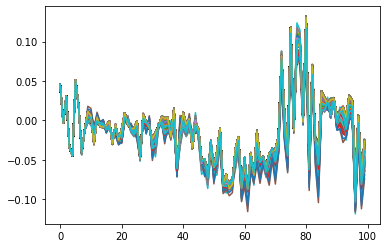

Discriminator Loss: -410989052719284864.00000000 Generator Loss: 1602299990760495616.00000000:  10%| | 100/1000 [02:41<

disc:current fake and real ves:  tensor([ 1.0022e+09, -1.0019e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.9419e+08, -2.2094e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0084e+09, -1.0081e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0195e+09, -1.0192e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0782e+09, -1.0778e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0543e+09, -1.0540e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0803e+09, -1.0800e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -469732610235025152.00000000 Generator Loss: 1694530487132435968.00000000:  10%| | 101/1000 [02:42<

disc:current fake and real ves:  tensor([ 1.0601e+09, -1.0598e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.4637e+08, -3.7069e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0689e+09, -1.0687e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0713e+09, -1.0711e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.1006e+09, -1.1003e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0946e+09, -1.0943e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.1015e+09, -1.1010e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -452766443745120768.00000000 Generator Loss: 1770637689080212992.00000000:  10%| | 102/1000 [02:44<

disc:current fake and real ves:  tensor([ 1.0672e+09, -1.0669e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.0299e+08, -4.2751e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.1260e+09, -1.1256e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1204e+09, -1.1201e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.1231e+09, -1.1228e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1421e+09, -1.1418e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.1238e+09, -1.1235e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -500279887051050240.00000000 Generator Loss: 1923680145493897728.00000000:  10%| | 103/1000 [02:45<

disc:current fake and real ves:  tensor([ 1.0340e+09, -1.0363e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.9146e+08, -4.1931e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.1764e+09, -1.1760e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1853e+09, -1.1849e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.1735e+09, -1.1731e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2025e+09, -1.2020e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.1731e+09, -1.1728e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -567393903006463360.00000000 Generator Loss: 2115806863425700608.00000000:  10%| | 104/1000 [02:47<

disc:current fake and real ves:  tensor([ 1.1812e+09, -1.1810e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.1549e+08, -3.5010e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.2312e+09, -1.2309e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2196e+09, -1.2194e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.2295e+09, -1.2293e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2486e+09, -1.2483e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.2303e+09, -1.2299e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -631103349075780608.00000000 Generator Loss: 2322048419509136896.00000000:  10%| | 105/1000 [02:48<

disc:current fake and real ves:  tensor([ 1.2419e+09, -1.2417e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.8285e+08, -6.1010e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.2900e+09, -1.2897e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2783e+09, -1.2781e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.2879e+09, -1.2877e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3019e+09, -1.3017e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.2886e+09, -1.2884e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -665563172631049600.00000000 Generator Loss: 2535288856398311936.00000000:  11%| | 106/1000 [02:50<

disc:current fake and real ves:  tensor([ 1.2324e+09, -1.2347e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.9258e+08, -4.3054e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.3482e+09, -1.3479e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3340e+09, -1.3337e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.3447e+09, -1.3444e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3555e+09, -1.3552e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.3463e+09, -1.3460e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -684097235798663168.00000000 Generator Loss: 2727811163720514560.00000000:  11%| | 107/1000 [02:51<

disc:current fake and real ves:  tensor([ 1.2997e+09, -1.2994e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.6427e+08, -5.0042e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.3974e+09, -1.3971e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3833e+09, -1.3830e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.3960e+09, -1.3957e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4028e+09, -1.4025e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.3965e+09, -1.3963e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -593989054094312448.00000000 Generator Loss: 2884044884798648832.00000000:  11%| | 108/1000 [02:52<

disc:current fake and real ves:  tensor([ 1.2406e+09, -1.2437e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.2813e+08, -3.7157e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.4375e+09, -1.4374e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3885e+09, -1.3884e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.4358e+09, -1.4356e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4505e+09, -1.4504e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.4365e+09, -1.4361e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -93069893547290656.00000000 Generator Loss: 2941575383814600704.00000000:  11%| | 109/1000 [02:54<2

disc:current fake and real ves:  tensor([ 7.8794e+08, -8.0900e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.9817e+08, -6.2963e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.4379e+09, -1.4377e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4377e+09, -1.4375e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.4433e+09, -1.4431e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4660e+09, -1.4658e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.4453e+09, -1.4450e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -673834605241792000.00000000 Generator Loss: 3040299791611629056.00000000:  11%| | 110/1000 [02:55<

disc:current fake and real ves:  tensor([ 1.0379e+09, -1.0474e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.4574e+08, -4.8600e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.4281e+09, -1.4278e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4399e+09, -1.4396e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5190e+09, -1.5187e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4717e+09, -1.4714e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.4775e+09, -1.4773e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -750823480371553536.00000000 Generator Loss: 3039854637616590848.00000000:  11%| | 111/1000 [02:57<

disc:current fake and real ves:  tensor([ 1.4366e+09, -1.4364e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.3945e+08, -7.6726e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.4665e+09, -1.4664e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4610e+09, -1.4608e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.4737e+09, -1.4735e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4873e+09, -1.4871e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.4739e+09, -1.4737e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -942084579972474880.00000000 Generator Loss: 3076878491377668096.00000000:  11%| | 112/1000 [02:59<

disc:current fake and real ves:  tensor([ 1.5384e+09, -1.5383e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.8290e+08, -6.1867e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.4852e+09, -1.4851e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4663e+09, -1.4662e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.4823e+09, -1.4822e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5116e+09, -1.5115e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.4822e+09, -1.4821e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -936497522386609280.00000000 Generator Loss: 3113266954751624704.00000000:  11%| | 113/1000 [03:00<

disc:current fake and real ves:  tensor([ 1.5437e+09, -1.5436e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.8074e+08, -3.3072e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.4933e+09, -1.4931e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4817e+09, -1.4815e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.4913e+09, -1.4912e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5066e+09, -1.5065e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.4914e+09, -1.4912e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -964844318445824256.00000000 Generator Loss: 3127694475249053184.00000000:  11%| | 114/1000 [03:02<

disc:current fake and real ves:  tensor([ 1.5496e+09, -1.5494e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.8984e+08, -5.3041e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.4973e+09, -1.4972e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4839e+09, -1.4838e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.4946e+09, -1.4945e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5157e+09, -1.5156e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.4950e+09, -1.4949e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -960544948239878784.00000000 Generator Loss: 3131175285993288704.00000000:  12%| | 115/1000 [03:03<

disc:current fake and real ves:  tensor([ 1.5494e+09, -1.5491e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.8834e+08, -5.2891e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.4977e+09, -1.4974e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4847e+09, -1.4844e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.4959e+09, -1.4956e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5167e+09, -1.5163e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.4955e+09, -1.4952e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -950178811404291712.00000000 Generator Loss: 3131226501521083904.00000000:  12%| | 116/1000 [03:05<

disc:current fake and real ves:  tensor([ 1.5602e+09, -1.5599e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.2887e+08, -3.7690e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.4980e+09, -1.4978e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4724e+09, -1.4722e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.4959e+09, -1.4956e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5295e+09, -1.5292e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.4955e+09, -1.4953e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -949687163277394048.00000000 Generator Loss: 3136101266346119168.00000000:  12%| | 117/1000 [03:06<

disc:current fake and real ves:  tensor([ 1.5518e+09, -1.5516e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0400e+09, -1.0556e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.4993e+09, -1.4992e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4993e+09, -1.4992e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.4967e+09, -1.4966e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4999e+09, -1.4997e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.4963e+09, -1.4962e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -983599951170099456.00000000 Generator Loss: 3152707926282889728.00000000:  12%| | 118/1000 [03:08<

disc:current fake and real ves:  tensor([ 1.5563e+09, -1.5562e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0769e+09, -1.0909e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5032e+09, -1.5032e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5009e+09, -1.5008e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5006e+09, -1.5005e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5057e+09, -1.5057e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.5006e+09, -1.5006e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -984912171047094912.00000000 Generator Loss: 3188060292129227264.00000000:  12%| | 119/1000 [03:10<

disc:current fake and real ves:  tensor([ 1.5690e+09, -1.5688e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.6229e+08, -4.0903e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5114e+09, -1.5112e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5001e+09, -1.4999e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5091e+09, -1.5089e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5237e+09, -1.5236e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.5092e+09, -1.5090e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1026290625127243776.00000000 Generator Loss: 3247518046502100480.00000000:  12%| | 120/1000 [03:11

disc:current fake and real ves:  tensor([ 1.5926e+09, -1.5925e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.0818e+08, -5.4884e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5255e+09, -1.5254e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5073e+09, -1.5072e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5231e+09, -1.5230e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5437e+09, -1.5435e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.5232e+09, -1.5231e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1094050215178907136.00000000 Generator Loss: 3335438587629270016.00000000:  12%| | 121/1000 [03:13

disc:current fake and real ves:  tensor([ 1.6273e+09, -1.6272e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.7703e+08, -4.2443e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5471e+09, -1.5470e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5146e+09, -1.5146e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5435e+09, -1.5435e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5762e+09, -1.5762e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.5440e+09, -1.5439e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1190541143817444352.00000000 Generator Loss: 3468054807098958848.00000000:  12%| | 122/1000 [03:14

disc:current fake and real ves:  tensor([ 1.6696e+09, -1.6694e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.5118e+08, -4.9556e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5771e+09, -1.5769e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5333e+09, -1.5331e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5739e+09, -1.5737e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6137e+09, -1.6135e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.5745e+09, -1.5743e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1261166948653408000.00000000 Generator Loss: 3642430506713563136.00000000:  12%| | 123/1000 [03:15

disc:current fake and real ves:  tensor([ 1.7191e+09, -1.7190e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.0072e+08, -3.5288e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.6156e+09, -1.6155e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5800e+09, -1.5799e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.6148e+09, -1.6147e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6463e+09, -1.6463e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.6160e+09, -1.6159e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1366856603032812800.00000000 Generator Loss: 3887251123806217216.00000000:  12%| | 124/1000 [03:17

disc:current fake and real ves:  tensor([ 1.7817e+09, -1.7815e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.7757e+08, -9.0652e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.6638e+09, -1.6636e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6562e+09, -1.6560e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.6660e+09, -1.6657e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6725e+09, -1.6722e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.6666e+09, -1.6665e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1429399318525419008.00000000 Generator Loss: 5509166021356290048.00000000:  12%|▏| 125/1000 [03:18

disc:current fake and real ves:  tensor([ 2.0220e+09, -2.0218e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-54509576., -15610655.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5071e+09, -1.5070e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6752e+09, -1.6751e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.9937e+09, -1.9936e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.7577e+09, -1.7576e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.8510e+09, -1.8508e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1619847330586782720.00000000 Generator Loss: 4860823061843353600.00000000:  13%|▏| 126/1000 [03:20

disc:current fake and real ves:  tensor([ 1.8732e+09, -1.8730e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.6878e+07, -1.6179e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.7224e+09, -1.7221e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.7470e+09, -1.7468e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.8494e+09, -1.8492e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.8560e+09, -1.8558e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.8515e+09, -1.8511e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1158884898631007488.00000000 Generator Loss: 4841864982335978496.00000000:  13%|▏| 127/1000 [03:21

disc:current fake and real ves:  tensor([ 1.6756e+09, -1.6752e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.9210e+08, -3.5024e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.8182e+09, -1.8178e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.8001e+09, -1.7997e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.8883e+09, -1.8878e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.8840e+09, -1.8835e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.8892e+09, -1.8888e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1735260473557229056.00000000 Generator Loss: 5476759372826720256.00000000:  13%|▏| 128/1000 [03:23

disc:current fake and real ves:  tensor([ 2.0067e+09, -2.0063e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.4655e+08, -4.0625e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.8750e+09, -1.8747e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.8724e+09, -1.8720e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.9823e+09, -1.9819e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.9513e+09, -1.9509e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.9860e+09, -1.9855e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1589680876125157376.00000000 Generator Loss: 5864335816625660928.00000000:  13%|▏| 129/1000 [03:24

disc:current fake and real ves:  tensor([ 1.9466e+09, -1.9462e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.1279e+08, -2.8162e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.9589e+09, -1.9584e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.9864e+09, -1.9860e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.0452e+09, -2.0448e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.0612e+09, -2.0607e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.0569e+09, -2.0567e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1477240269438621696.00000000 Generator Loss: 6191469306539854848.00000000:  13%|▏| 130/1000 [03:26

disc:current fake and real ves:  tensor([ 1.8895e+09, -1.8919e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ -2562244.2500, -77653064.0000], device='cuda:0',
       grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.0547e+09, -2.0545e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.0622e+09, -2.0620e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.1054e+09, -2.1051e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.1645e+09, -2.1642e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.1056e+09, -2.1053e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1915926428953889280.00000000 Generator Loss: 6992452575219502080.00000000:  13%|▏| 131/1000 [03:27

disc:current fake and real ves:  tensor([ 2.1042e+09, -2.1039e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.0201e+08, -3.7325e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.1219e+09, -2.1215e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.1740e+09, -2.1736e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.2272e+09, -2.2268e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.1971e+09, -2.1967e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.2268e+09, -2.2262e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1637612000387079168.00000000 Generator Loss: 7002725062125765632.00000000:  13%|▏| 132/1000 [03:29

disc:current fake and real ves:  tensor([ 2.0371e+09, -2.0394e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.5949e+08, -6.2275e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.2281e+09, -2.2276e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.1972e+09, -2.1967e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.2378e+09, -2.2373e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.2751e+09, -2.2746e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.2381e+09, -2.2377e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2150355009667993856.00000000 Generator Loss: 7755774664346782720.00000000:  13%|▏| 133/1000 [03:30

disc:current fake and real ves:  tensor([ 2.2796e+09, -2.2790e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0281e+09, -1.0741e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.2690e+09, -2.2684e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.3135e+09, -2.3130e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.3543e+09, -2.3537e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.3261e+09, -2.3255e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.3549e+09, -2.3543e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2019687774604166144.00000000 Generator Loss: 7642318743660831744.00000000:  13%|▏| 134/1000 [03:32

disc:current fake and real ves:  tensor([ 2.2430e+09, -2.2425e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5123e+08, -2.3569e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.3341e+09, -2.3336e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.3367e+09, -2.3362e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.3367e+09, -2.3362e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.4596e+09, -2.4591e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.3368e+09, -2.3364e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1978010308560478720.00000000 Generator Loss: 7823559498315305984.00000000:  14%|▏| 135/1000 [03:33

disc:current fake and real ves:  tensor([ 2.2289e+09, -2.2286e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.7205e+08, -4.4729e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.3712e+09, -2.3709e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.3530e+09, -2.3526e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.3641e+09, -2.3637e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.4469e+09, -2.4465e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.3649e+09, -2.3645e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2024759282978888704.00000000 Generator Loss: 8034703147097675776.00000000:  14%|▏| 136/1000 [03:35

disc:current fake and real ves:  tensor([ 2.2646e+09, -2.2641e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1522e+09, -1.1971e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.4021e+09, -2.4015e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.4102e+09, -2.4095e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.3959e+09, -2.3953e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.4258e+09, -2.4252e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.3965e+09, -2.3960e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2061554295553674240.00000000 Generator Loss: 8185237055765189632.00000000:  14%|▏| 137/1000 [03:36

disc:current fake and real ves:  tensor([ 2.2902e+09, -2.2898e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.6078e+08, -8.2226e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.4244e+09, -2.4239e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.4119e+09, -2.4114e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.4181e+09, -2.4176e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.4797e+09, -2.4792e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.4183e+09, -2.4180e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2109084520711400960.00000000 Generator Loss: 8283186740468866048.00000000:  14%|▏| 138/1000 [03:38

disc:current fake and real ves:  tensor([ 2.3036e+09, -2.3031e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.2623e+08, -8.8598e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.4386e+09, -2.4380e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.4198e+09, -2.4193e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.4326e+09, -2.4320e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.5012e+09, -2.5006e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.4326e+09, -2.4321e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2150776025235766528.00000000 Generator Loss: 8330864867250585600.00000000:  14%|▏| 139/1000 [03:39

disc:current fake and real ves:  tensor([ 2.3140e+09, -2.3137e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.7459e+08, -8.3641e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.4451e+09, -2.4447e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.4186e+09, -2.4182e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.4398e+09, -2.4394e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.5145e+09, -2.5141e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.4395e+09, -2.4391e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2151217786038468608.00000000 Generator Loss: 8352934901456678912.00000000:  14%|▏| 140/1000 [03:41

disc:current fake and real ves:  tensor([ 2.3131e+09, -2.3127e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.2018e+08, -5.9287e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.4489e+09, -2.4484e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.4522e+09, -2.4517e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.4427e+09, -2.4422e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.5026e+09, -2.5020e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.4428e+09, -2.4423e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2153230027729175552.00000000 Generator Loss: 8355539976219158528.00000000:  14%|▏| 141/1000 [03:43

disc:current fake and real ves:  tensor([ 2.3163e+09, -2.3158e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2608e+09, -1.3031e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.4484e+09, -2.4478e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.4435e+09, -2.4429e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.4435e+09, -2.4429e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.4755e+09, -2.4749e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.4435e+09, -2.4429e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2123469635464348672.00000000 Generator Loss: 8356819703496121344.00000000:  14%|▏| 142/1000 [03:45

disc:current fake and real ves:  tensor([ 2.3131e+09, -2.3126e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.0036e+08,  2.2636e+06], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.4495e+09, -2.4490e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.4239e+09, -2.4233e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.4432e+09, -2.4426e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.5292e+09, -2.5287e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.4432e+09, -2.4427e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2102783622279920640.00000000 Generator Loss: 8373913588015931392.00000000:  14%|▏| 143/1000 [03:46

disc:current fake and real ves:  tensor([ 2.3172e+09, -2.3169e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1667e+09, -1.2132e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.4518e+09, -2.4514e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.4481e+09, -2.4477e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.4456e+09, -2.4453e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.4670e+09, -2.4666e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.4461e+09, -2.4458e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2189564837478918144.00000000 Generator Loss: 8421218599414340608.00000000:  14%|▏| 144/1000 [03:48

disc:current fake and real ves:  tensor([ 2.3248e+09, -2.3243e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.8247e+07, -1.2061e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.4580e+09, -2.4575e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.4412e+09, -2.4407e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.4528e+09, -2.4522e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.5434e+09, -2.5428e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.4529e+09, -2.4523e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2216919223146945536.00000000 Generator Loss: 8505231600922439680.00000000:  14%|▏| 145/1000 [03:49

disc:current fake and real ves:  tensor([ 2.3400e+09, -2.3396e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ -7217079., -87878600.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.4702e+09, -2.4697e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.4328e+09, -2.4323e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.4649e+09, -2.4645e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.5439e+09, -2.5434e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.4651e+09, -2.4646e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2270214522621123072.00000000 Generator Loss: 8644851090523202560.00000000:  15%|▏| 146/1000 [03:51

disc:current fake and real ves:  tensor([ 2.3575e+09, -2.3572e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.8733e+08, -2.7483e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.4901e+09, -2.4897e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.4530e+09, -2.4527e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.4851e+09, -2.4847e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.5893e+09, -2.5889e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.4852e+09, -2.4847e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2383382365893371904.00000000 Generator Loss: 8843505604327663616.00000000:  15%|▏| 147/1000 [03:53

disc:current fake and real ves:  tensor([ 2.3828e+09, -2.3823e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1653e+09, -1.2138e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.5199e+09, -2.5194e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.5244e+09, -2.5238e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.5135e+09, -2.5129e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.5276e+09, -2.5270e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.5136e+09, -2.5130e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2469977982518273024.00000000 Generator Loss: 9113981537886555136.00000000:  15%|▏| 148/1000 [03:54

disc:current fake and real ves:  tensor([ 2.4209e+09, -2.4206e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.0150e+08, -6.7430e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.5583e+09, -2.5580e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.5196e+09, -2.5193e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.5516e+09, -2.5512e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.5966e+09, -2.5963e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.5524e+09, -2.5517e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2593294685679446528.00000000 Generator Loss: 9473074066638608384.00000000:  15%|▏| 149/1000 [03:56

disc:current fake and real ves:  tensor([ 2.4677e+09, -2.4674e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.8219e+08, -5.6165e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.6067e+09, -2.6064e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.5482e+09, -2.5478e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.6013e+09, -2.6010e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.6497e+09, -2.6493e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.6022e+09, -2.6019e+09], device='cuda:0', grad_fn=<SelectBackward0>)


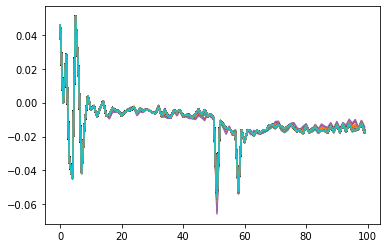

Discriminator Loss: -2727713964540599296.00000000 Generator Loss: 9931784302524270592.00000000:  15%|▏| 150/1000 [04:00

disc:current fake and real ves:  tensor([ 2.5265e+09, -2.5259e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.4190e+08, -1.0049e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.6665e+09, -2.6660e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.6129e+09, -2.6124e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.6637e+09, -2.6631e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.6838e+09, -2.6833e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.6642e+09, -2.6636e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3004416696532205568.00000000 Generator Loss: 10484604026255360000.00000000:  15%|▏| 151/1000 [04:0

disc:current fake and real ves:  tensor([ 2.5916e+09, -2.5909e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.4318e+08, -6.2297e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.7384e+09, -2.7377e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.6575e+09, -2.6568e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.7369e+09, -2.7361e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.7617e+09, -2.7610e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.7379e+09, -2.7373e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3183563555176210432.00000000 Generator Loss: 11136003132229888000.00000000:  15%|▏| 152/1000 [04:0

disc:current fake and real ves:  tensor([ 2.6515e+09, -2.6515e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.1969e+08, -6.0289e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.8214e+09, -2.8211e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.6576e+09, -2.6573e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.8188e+09, -2.8185e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.8037e+09, -2.8034e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.8216e+09, -2.8210e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1183329199085338624.00000000 Generator Loss: 9746338936122478592.00000000:  15%|▏| 153/1000 [04:04

disc:current fake and real ves:  tensor([ 3.9905e+09, -3.9890e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.7039e+08, -5.5452e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.9325e+08, -1.9306e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.7104e+09, -2.7097e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.2837e+09, -1.2831e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.8483e+09, -2.8476e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.4708e+09, -1.4702e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 1296074841382624512.00000000 Generator Loss: 15446586657936381952.00000000:  15%|▏| 154/1000 [04:06

disc:current fake and real ves:  tensor([-5.5228e+08,  4.7657e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.3012e+08,  2.1336e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.1901e+09, -2.1896e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.7419e+09, -2.7414e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.8597e+09, -2.8591e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.9022e+09, -2.9016e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.1000e+09, -3.0993e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -4869536431599681536.00000000 Generator Loss: 14740021258842286080.00000000:  16%|▏| 155/1000 [04:0

disc:current fake and real ves:  tensor([ 2.9019e+09, -2.9015e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.0487e+08, -5.9499e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.7001e+09, -2.6998e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.8273e+09, -2.8270e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.1767e+09, -3.1763e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.9544e+09, -2.9540e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.1927e+09, -3.1922e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -4302358403548416512.00000000 Generator Loss: 13850071419076595712.00000000:  16%|▏| 156/1000 [04:0

disc:current fake and real ves:  tensor([ 3.0405e+09, -3.0403e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.1659e+08, -4.9410e+06], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.8795e+09, -2.8794e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.8961e+09, -2.8959e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.1478e+09, -3.1476e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.0509e+09, -3.0508e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.1521e+09, -3.1519e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3073146412647710720.00000000 Generator Loss: 12627866772625870848.00000000:  16%|▏| 157/1000 [04:1

disc:current fake and real ves:  tensor([ 2.6322e+09, -2.6390e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.1990e+08, -9.0383e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.9858e+09, -2.9855e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.9747e+09, -2.9744e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.0210e+09, -3.0207e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.0545e+09, -3.0542e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.9970e+09, -2.9967e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1647633681294129664.00000000 Generator Loss: 13220196606553382912.00000000:  16%|▏| 158/1000 [04:1

disc:current fake and real ves:  tensor([ 2.1143e+09, -2.1424e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.4782e+08, -4.5188e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.0568e+09, -3.0568e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.0101e+09, -3.0102e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.0762e+09, -3.0763e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.0936e+09, -3.0936e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.0960e+09, -3.0958e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3838147333756385792.00000000 Generator Loss: 14383438523514470400.00000000:  16%|▏| 159/1000 [04:1

disc:current fake and real ves:  tensor([ 2.9159e+09, -2.9157e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5943e+09, -1.6486e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.0875e+09, -3.0873e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.0614e+09, -3.0612e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.2751e+09, -3.2748e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.1037e+09, -3.1035e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.1982e+09, -3.1980e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3850410264293145088.00000000 Generator Loss: 14232454063030738944.00000000:  16%|▏| 160/1000 [04:1

disc:current fake and real ves:  tensor([ 3.0264e+09, -3.0262e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.7910e+08, -6.8149e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.1080e+09, -3.1077e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.1135e+09, -3.1132e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.1917e+09, -3.1915e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.2049e+09, -3.2046e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.1865e+09, -3.1863e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2665523003317580288.00000000 Generator Loss: 14195470829616898048.00000000:  16%|▏| 161/1000 [04:1

disc:current fake and real ves:  tensor([ 2.5144e+09, -2.5331e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.1204e+08, -1.0021e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.1726e+09, -3.1724e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.1284e+09, -3.1282e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.1794e+09, -3.1792e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.2174e+09, -3.2172e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.1853e+09, -3.1851e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3472454777033279488.00000000 Generator Loss: 14035771145742333952.00000000:  16%|▏| 162/1000 [04:1

disc:current fake and real ves:  tensor([ 2.9742e+09, -2.9740e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.8881e+08, -6.9280e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.1734e+09, -3.1732e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.1923e+09, -3.1921e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.1669e+09, -3.1667e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.2228e+09, -3.2226e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.1660e+09, -3.1658e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3540736561752904192.00000000 Generator Loss: 14170547401720088576.00000000:  16%|▏| 163/1000 [04:2

disc:current fake and real ves:  tensor([ 2.9946e+09, -2.9945e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5973e+09, -1.6573e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.1907e+09, -3.1905e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.1901e+09, -3.1899e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.1798e+09, -3.1796e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.2070e+09, -3.2068e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.1810e+09, -3.1808e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3644461043975306240.00000000 Generator Loss: 14252073174231590912.00000000:  16%|▏| 164/1000 [04:2

disc:current fake and real ves:  tensor([ 3.0649e+09, -3.0651e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4577e+08, -2.7146e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.1968e+09, -3.1970e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.1675e+09, -3.1678e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.1909e+09, -3.1912e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.2995e+09, -3.2998e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.1920e+09, -3.1922e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3692645539185021440.00000000 Generator Loss: 14291211020950024192.00000000:  16%|▏| 165/1000 [04:2

disc:current fake and real ves:  tensor([ 2.9821e+09, -2.9821e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2491e+08, -2.5208e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.2031e+09, -3.2030e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.1826e+09, -3.1826e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.1951e+09, -3.1950e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.2639e+09, -3.2639e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.1939e+09, -3.1938e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3701837208486986752.00000000 Generator Loss: 14305841900866822144.00000000:  17%|▏| 166/1000 [04:2

disc:current fake and real ves:  tensor([ 3.0282e+09, -3.0283e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-35742760., -97806136.], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.2032e+09, -3.2033e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.1668e+09, -3.1669e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.1962e+09, -3.1963e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.3083e+09, -3.3084e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.1954e+09, -3.1955e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3720407191461759488.00000000 Generator Loss: 14304784404770414592.00000000:  17%|▏| 167/1000 [04:2

disc:current fake and real ves:  tensor([ 2.9876e+09, -2.9878e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0955e+09, -1.1795e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.2040e+09, -3.2041e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.1890e+09, -3.1891e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.1961e+09, -3.1962e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.2519e+09, -3.2520e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.1940e+09, -3.1941e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3628125655894522368.00000000 Generator Loss: 14318917713348532224.00000000:  17%|▏| 168/1000 [04:2

disc:current fake and real ves:  tensor([ 3.0731e+09, -3.0733e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.7143e+09, -1.7705e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.2033e+09, -3.2035e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.2048e+09, -3.2051e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.1986e+09, -3.1989e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.2380e+09, -3.2383e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.1956e+09, -3.1959e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3705604728024776704.00000000 Generator Loss: 14345468241818032128.00000000:  17%|▏| 169/1000 [04:2

disc:current fake and real ves:  tensor([ 3.0403e+09, -3.0401e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2126e+09, -1.2906e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.2085e+09, -3.2083e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.1963e+09, -3.1961e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.1997e+09, -3.1996e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.2765e+09, -3.2763e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.1988e+09, -3.1986e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3669987977974694912.00000000 Generator Loss: 14415916358422560768.00000000:  17%|▏| 170/1000 [04:3

disc:current fake and real ves:  tensor([ 3.0706e+09, -3.0709e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.7226e+08,  7.0096e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.2159e+09, -3.2162e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.1565e+09, -3.1568e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.2075e+09, -3.2078e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.3452e+09, -3.3455e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.2067e+09, -3.2071e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3776976685427829760.00000000 Generator Loss: 14541114552510322688.00000000:  17%|▏| 171/1000 [04:3

disc:current fake and real ves:  tensor([ 3.0045e+09, -3.0054e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.0678e+09, -2.1096e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.2337e+09, -3.2339e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.2422e+09, -3.2424e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.2240e+09, -3.2243e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.2574e+09, -3.2577e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.2243e+09, -3.2246e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3813768576010369024.00000000 Generator Loss: 14741394720953268224.00000000:  17%|▏| 172/1000 [04:3

disc:current fake and real ves:  tensor([ 2.9979e+09, -2.9997e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.5084e+08, -9.4808e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.2535e+09, -3.2533e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.2297e+09, -3.2296e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.2441e+09, -3.2439e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.2919e+09, -3.2917e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.2471e+09, -3.2470e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3847126550950281728.00000000 Generator Loss: 15019277287392512000.00000000:  17%|▏| 173/1000 [04:3

disc:current fake and real ves:  tensor([ 3.1396e+09, -3.1395e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.9052e+08, -4.1241e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.2812e+09, -3.2810e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.2448e+09, -3.2446e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.2756e+09, -3.2754e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.3672e+09, -3.3670e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.2775e+09, -3.2773e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -4003069215620366848.00000000 Generator Loss: 15379768780394246144.00000000:  17%|▏| 174/1000 [04:3

disc:current fake and real ves:  tensor([ 3.0977e+09, -3.0977e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.1067e+08, -3.1429e+07], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.3244e+09, -3.3243e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.2869e+09, -3.2868e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.3146e+09, -3.3145e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.4256e+09, -3.4255e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.3134e+09, -3.3134e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -4076580568844168192.00000000 Generator Loss: 15846563114836164608.00000000:  18%|▏| 175/1000 [04:3

disc:current fake and real ves:  tensor([ 3.1169e+09, -3.1183e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3018e+09, -1.3837e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.3777e+09, -3.3777e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.3467e+09, -3.3467e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.3627e+09, -3.3627e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.4421e+09, -3.4421e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.3644e+09, -3.3643e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -4219423761906059264.00000000 Generator Loss: 16419558971623098368.00000000:  18%|▏| 176/1000 [04:3

disc:current fake and real ves:  tensor([ 3.1667e+09, -3.1687e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.2694e+08, -8.3725e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.4417e+09, -3.4421e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.3953e+09, -3.3957e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.4202e+09, -3.4206e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.5045e+09, -3.5049e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.4267e+09, -3.4273e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -4080480423009402880.00000000 Generator Loss: 17093960334436157440.00000000:  18%|▏| 177/1000 [04:4

disc:current fake and real ves:  tensor([ 3.2957e+09, -3.2957e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.0576e+08, -5.3097e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.5054e+09, -3.5053e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.4385e+09, -3.4384e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.4937e+09, -3.4937e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.5981e+09, -3.5980e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.4952e+09, -3.4954e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -4431373629378681856.00000000 Generator Loss: 17846307297689956352.00000000:  18%|▏| 178/1000 [04:4

disc:current fake and real ves:  tensor([ 3.3235e+09, -3.3240e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2306e+09, -1.3228e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.5820e+09, -3.5824e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.5207e+09, -3.5212e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.5702e+09, -3.5706e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.6465e+09, -3.6470e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.5727e+09, -3.5728e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -4774991351328132096.00000000 Generator Loss: 18697095179417722880.00000000:  18%|▏| 179/1000 [04:4

disc:current fake and real ves:  tensor([ 3.3894e+09, -3.3905e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.0745e+08, -7.3109e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.6646e+09, -3.6652e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.6104e+09, -3.6111e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.6546e+09, -3.6552e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.7216e+09, -3.7223e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.6541e+09, -3.6545e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -5121868862269538304.00000000 Generator Loss: 19650843101191815168.00000000:  18%|▏| 180/1000 [04:4

disc:current fake and real ves:  tensor([ 3.5714e+09, -3.5716e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.0232e+09, -2.0876e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.7527e+09, -3.7529e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.7294e+09, -3.7296e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.7458e+09, -3.7459e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.7724e+09, -3.7725e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.7490e+09, -3.7495e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -4996181022068332544.00000000 Generator Loss: 20651396611164602368.00000000:  18%|▏| 181/1000 [04:4

disc:current fake and real ves:  tensor([ 3.6168e+09, -3.6170e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.9169e+09, -1.9886e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.8436e+09, -3.8437e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.8054e+09, -3.8056e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.8418e+09, -3.8420e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.8706e+09, -3.8708e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.8399e+09, -3.8402e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -4773386241928763392.00000000 Generator Loss: 21584216150621106176.00000000:  18%|▏| 182/1000 [04:4

disc:current fake and real ves:  tensor([ 3.5401e+09, -3.5422e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6569e+09, -1.7415e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.9311e+09, -3.9320e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.8603e+09, -3.8612e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.9237e+09, -3.9245e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.9832e+09, -3.9841e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.9254e+09, -3.9261e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -5594024935765610496.00000000 Generator Loss: 22514630467694526464.00000000:  18%|▏| 183/1000 [04:5

disc:current fake and real ves:  tensor([ 3.7602e+09, -3.7606e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5060e+09, -1.6019e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.0181e+09, -4.0184e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.9734e+09, -3.9737e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.0064e+09, -4.0068e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.0416e+09, -4.0419e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.0122e+09, -4.0125e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -5820359470612355072.00000000 Generator Loss: 23418829700394930176.00000000:  18%|▏| 184/1000 [04:5

disc:current fake and real ves:  tensor([ 3.7948e+09, -3.7958e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.8103e+09, -1.8979e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.0956e+09, -4.0966e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.0349e+09, -4.0359e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.0866e+09, -4.0876e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.1317e+09, -4.1327e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.0895e+09, -4.0903e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -5672478877358840832.00000000 Generator Loss: 24199510020081352704.00000000:  18%|▏| 185/1000 [04:5

disc:current fake and real ves:  tensor([ 3.8394e+09, -3.8403e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.8094e+09, -1.8998e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.1653e+09, -4.1663e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.0880e+09, -4.0890e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.1538e+09, -4.1548e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.1997e+09, -4.2007e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.1573e+09, -4.1583e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -6204615041628190720.00000000 Generator Loss: 24871593045875712000.00000000:  19%|▏| 186/1000 [04:5

disc:current fake and real ves:  tensor([ 3.8771e+09, -3.8792e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.5300e+08, -6.0412e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.2212e+09, -4.2223e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.1054e+09, -4.1065e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.2140e+09, -4.2151e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.2775e+09, -4.2786e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.2158e+09, -4.2168e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -6159972546920833024.00000000 Generator Loss: 25407178245825904640.00000000:  19%|▏| 187/1000 [04:5

disc:current fake and real ves:  tensor([ 3.7057e+09, -3.7175e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.3739e+08, -6.8777e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.2608e+09, -4.2617e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.1160e+09, -4.1170e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.2592e+09, -4.2602e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.3123e+09, -4.3132e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.2602e+09, -4.2611e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -6212977612293186560.00000000 Generator Loss: 25783654028680785920.00000000:  19%|▏| 188/1000 [04:5

disc:current fake and real ves:  tensor([ 3.9784e+09, -3.9792e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.3720e+08, -9.7775e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.2925e+09, -4.2931e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.2056e+09, -4.2062e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.2940e+09, -4.2946e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.3272e+09, -4.3278e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.2909e+09, -4.2918e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -5889726512216998912.00000000 Generator Loss: 26024253149684432896.00000000:  19%|▏| 189/1000 [04:5

disc:current fake and real ves:  tensor([ 3.9818e+09, -3.9830e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4670e+09, -1.5795e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.3136e+09, -4.3142e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.2102e+09, -4.2107e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.3133e+09, -4.3139e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.3353e+09, -4.3358e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.3134e+09, -4.3141e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -5856294457670641664.00000000 Generator Loss: 26166270059267125248.00000000:  19%|▏| 190/1000 [05:0

disc:current fake and real ves:  tensor([ 3.9536e+09, -3.9559e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.7505e+09, -1.8513e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.3207e+09, -4.3216e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.2674e+09, -4.2683e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.3234e+09, -4.3243e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.3553e+09, -4.3562e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.3225e+09, -4.3234e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -5570588950112460800.00000000 Generator Loss: 26223246319258710016.00000000:  19%|▏| 191/1000 [05:0

disc:current fake and real ves:  tensor([ 3.8789e+09, -3.8844e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.7776e+06, -1.7957e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.3285e+09, -4.3294e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.2276e+09, -4.2286e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.3256e+09, -4.3265e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.3787e+09, -4.3796e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.3233e+09, -4.3243e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -5486944244113102848.00000000 Generator Loss: 26236528149595058176.00000000:  19%|▏| 192/1000 [05:0

disc:current fake and real ves:  tensor([ 3.9375e+09, -3.9408e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.7009e+08, -1.1037e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.3263e+09, -4.3273e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.1864e+09, -4.1874e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.3292e+09, -4.3303e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.3906e+09, -4.3917e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.3280e+09, -4.3291e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -5693284072831156224.00000000 Generator Loss: 26237933467298988032.00000000:  19%|▏| 193/1000 [05:0

disc:current fake and real ves:  tensor([ 3.9246e+09, -3.9286e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.7021e+09, -1.8050e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.3263e+09, -4.3275e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.2733e+09, -4.2744e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.3291e+09, -4.3303e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.3452e+09, -4.3463e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.3284e+09, -4.3295e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -5526410329403258880.00000000 Generator Loss: 26263230045363982336.00000000:  19%|▏| 194/1000 [05:0

disc:current fake and real ves:  tensor([ 3.9185e+09, -3.9223e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.5745e+09, -2.6390e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.3286e+09, -4.3295e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.3114e+09, -4.3122e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.3315e+09, -4.3324e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.3453e+09, -4.3462e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.3300e+09, -4.3309e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -5396885985335496704.00000000 Generator Loss: 26341780233474793472.00000000:  20%|▏| 195/1000 [05:0

disc:current fake and real ves:  tensor([ 3.6920e+09, -3.7057e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.1491e+08, -7.6472e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.3392e+09, -4.3400e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.1861e+09, -4.1870e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.3367e+09, -4.3376e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.4051e+09, -4.4060e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.3367e+09, -4.3376e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -5271693178029236224.00000000 Generator Loss: 26497154386154635264.00000000:  20%|▏| 196/1000 [05:0

disc:current fake and real ves:  tensor([ 3.6808e+09, -3.6955e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0533e+09, -1.1854e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.3522e+09, -4.3533e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.2911e+09, -4.2922e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.3497e+09, -4.3508e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.3824e+09, -4.3835e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.3534e+09, -4.3545e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -4899944206231838720.00000000 Generator Loss: 26752520981833936896.00000000:  20%|▏| 197/1000 [05:1

disc:current fake and real ves:  tensor([ 3.8083e+09, -3.8172e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.0167e+09, -3.0633e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.3657e+09, -4.3666e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.3322e+09, -4.3331e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.3724e+09, -4.3733e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.3855e+09, -4.3865e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.3728e+09, -4.3738e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3099587376170108928.00000000 Generator Loss: 27076230974496342016.00000000:  20%|▏| 198/1000 [05:1

disc:current fake and real ves:  tensor([ 3.2975e+09, -3.3288e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.5122e+09, -2.5820e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.3860e+09, -4.3865e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.3839e+09, -4.3844e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.3962e+09, -4.3967e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.4177e+09, -4.4182e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.3913e+09, -4.3919e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 2227493421959821312.00000000 Generator Loss: 32208736544674861056.00000000:  20%|▏| 199/1000 [05:14

disc:current fake and real ves:  tensor([-2.8639e+09,  2.5032e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.2954e+09, -2.3760e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 3.9336e+09, -3.9346e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.3536e+09, -4.3547e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.7432e+09, -4.7442e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.4253e+09, -4.4264e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.7381e+09, -4.7392e+09], device='cuda:0', grad_fn=<SelectBackward0>)


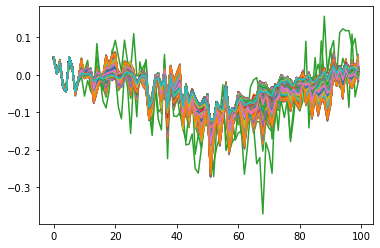

Discriminator Loss: -7650878957287434240.00000000 Generator Loss: 28753225454777516032.00000000:  20%|▏| 200/1000 [05:1

disc:current fake and real ves:  tensor([ 4.2476e+09, -4.2488e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.1365e+09, -2.2274e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.4687e+09, -4.4699e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.4282e+09, -4.4294e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.5202e+09, -4.5214e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.4674e+09, -4.4685e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.4957e+09, -4.4969e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -8229233630008194048.00000000 Generator Loss: 30360130483505606656.00000000:  20%|▏| 201/1000 [05:1

disc:current fake and real ves:  tensor([ 4.5003e+09, -4.5011e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6774e+09, -1.7924e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.4572e+09, -4.4580e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.5090e+09, -4.5098e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.6704e+09, -4.6713e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.5816e+09, -4.5824e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.7196e+09, -4.7206e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -8747488511895971840.00000000 Generator Loss: 33075943172529750016.00000000:  20%|▏| 202/1000 [05:2

disc:current fake and real ves:  tensor([ 4.4995e+09, -4.5007e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3426e+09, -1.4775e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.5823e+09, -4.5835e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.6055e+09, -4.6067e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.8451e+09, -4.8463e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.7328e+09, -4.7340e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.8717e+09, -4.8725e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -8484025700211933184.00000000 Generator Loss: 32686625859842187264.00000000:  20%|▏| 203/1000 [05:2

disc:current fake and real ves:  tensor([ 4.6534e+09, -4.6546e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.0562e+09, -2.1663e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.7551e+09, -4.7563e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.7658e+09, -4.7670e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.8240e+09, -4.8252e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.8266e+09, -4.8278e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.8217e+09, -4.8225e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -9475520670291851264.00000000 Generator Loss: 34931875947145134080.00000000:  20%|▏| 204/1000 [05:2

disc:current fake and real ves:  tensor([ 4.9201e+09, -4.9210e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4792e+09, -1.6201e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.8175e+09, -4.8184e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.9125e+09, -4.9134e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 5.0334e+09, -5.0343e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.0041e+09, -5.0050e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 5.0226e+09, -5.0236e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -10120323791636047872.00000000 Generator Loss: 37498651133150781440.00000000:  20%|▏| 205/1000 [05:

disc:current fake and real ves:  tensor([ 5.1200e+09, -5.1213e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.5678e+08, -6.4791e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 4.9696e+09, -4.9712e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.0360e+09, -5.0373e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 5.3046e+09, -5.3059e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.1521e+09, -5.1533e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 5.1281e+09, -5.1296e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -11827665150699921408.00000000 Generator Loss: 40581895473704009728.00000000:  21%|▏| 206/1000 [05:

disc:current fake and real ves:  tensor([ 5.2767e+09, -5.2776e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.0849e+08, -1.0853e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 5.2334e+09, -5.2344e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.2323e+09, -5.2333e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 5.3781e+09, -5.3790e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.3083e+09, -5.3093e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 5.3546e+09, -5.3559e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -11824742604642463744.00000000 Generator Loss: 41181455775757008896.00000000:  21%|▏| 207/1000 [05:

disc:current fake and real ves:  tensor([ 5.3581e+09, -5.3590e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6463e+09, -1.7985e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 5.3567e+09, -5.3576e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.4456e+09, -5.4465e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 5.4232e+09, -5.4240e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.5901e+09, -5.5910e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 5.4231e+09, -5.4240e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -12715609714052681728.00000000 Generator Loss: 44401883907665584128.00000000:  21%|▏| 208/1000 [05:

disc:current fake and real ves:  tensor([ 5.4581e+09, -5.4601e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.6494e+09, -3.7237e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 5.5773e+09, -5.5786e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.5705e+09, -5.5717e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 5.6204e+09, -5.6216e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.5611e+09, -5.5623e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 5.6438e+09, -5.6447e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -13772074761569478656.00000000 Generator Loss: 48096344457443352576.00000000:  21%|▏| 209/1000 [05:

disc:current fake and real ves:  tensor([ 5.5904e+09, -5.5918e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.8648e+09, -2.9766e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 5.6711e+09, -5.6724e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.6841e+09, -5.6854e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 5.7937e+09, -5.7950e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.8029e+09, -5.8042e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 5.7955e+09, -5.7968e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -14185932284915675136.00000000 Generator Loss: 47938878717161185280.00000000:  21%|▏| 210/1000 [05:

disc:current fake and real ves:  tensor([ 5.8300e+09, -5.8315e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.9018e+07, -2.1463e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 5.7824e+09, -5.7838e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.8324e+09, -5.8339e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 5.8508e+09, -5.8523e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.0052e+09, -6.0066e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 5.8605e+09, -5.8617e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -15097479538362187776.00000000 Generator Loss: 52143593151177793536.00000000:  21%|▏| 211/1000 [05:

disc:current fake and real ves:  tensor([ 5.8906e+09, -5.8912e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.3655e+08, -5.5874e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 5.8962e+09, -5.8969e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.9234e+09, -5.9240e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.0804e+09, -6.0810e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.0352e+09, -6.0358e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 6.0935e+09, -6.0943e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -14684576325884192768.00000000 Generator Loss: 51886160268201672704.00000000:  21%|▏| 212/1000 [05:

disc:current fake and real ves:  tensor([ 5.9657e+09, -5.9670e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5855e+09, -1.7605e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 5.9852e+09, -5.9866e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.0408e+09, -6.0421e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.0865e+09, -6.0879e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.1466e+09, -6.1479e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 6.0746e+09, -6.0760e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -14705070485539244032.00000000 Generator Loss: 51914819430706724864.00000000:  21%|▏| 213/1000 [05:

disc:current fake and real ves:  tensor([ 5.9545e+09, -5.9553e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.8561e+08, -4.1899e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.0397e+09, -6.0405e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.1023e+09, -6.1031e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.0794e+09, -6.0802e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.2564e+09, -6.2572e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 6.0831e+09, -6.0842e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -14394855491854544896.00000000 Generator Loss: 51643164194029109248.00000000:  21%|▏| 214/1000 [05:

disc:current fake and real ves:  tensor([ 5.9710e+09, -5.9721e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.1262e+08, -3.7586e+07], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.0792e+09, -6.0803e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.0904e+09, -6.0915e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.0707e+09, -6.0718e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.1946e+09, -6.1957e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 6.0733e+09, -6.0744e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -14663783843728834560.00000000 Generator Loss: 52085036057828753408.00000000:  22%|▏| 215/1000 [05:

disc:current fake and real ves:  tensor([ 5.9828e+09, -5.9840e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5826e+09, -1.7614e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.1017e+09, -6.1029e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.1914e+09, -6.1925e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.0979e+09, -6.0990e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.2282e+09, -6.2293e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 6.0978e+09, -6.0989e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -14828368718942447616.00000000 Generator Loss: 52296848343241318400.00000000:  22%|▏| 216/1000 [05:

disc:current fake and real ves:  tensor([ 6.0078e+09, -6.0089e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.4667e+08, -7.6795e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.1121e+09, -6.1133e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.1690e+09, -6.1702e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.1117e+09, -6.1129e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.3157e+09, -6.3169e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 6.1118e+09, -6.1129e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -14849570185253163008.00000000 Generator Loss: 52379911368384094208.00000000:  22%|▏| 217/1000 [05:

disc:current fake and real ves:  tensor([ 6.0120e+09, -6.0128e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.5353e+09, -2.6761e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.1170e+09, -6.1179e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.1653e+09, -6.1662e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.1163e+09, -6.1172e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.2658e+09, -6.2667e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 6.1168e+09, -6.1177e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -14704801188396746752.00000000 Generator Loss: 52394824799253643264.00000000:  22%|▏| 218/1000 [05:

disc:current fake and real ves:  tensor([ 6.0009e+09, -6.0019e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.5849e+08,  1.9718e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.1179e+09, -6.1188e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.1414e+09, -6.1424e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.1168e+09, -6.1177e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.2979e+09, -6.2988e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 6.1162e+09, -6.1172e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -14736955836967735296.00000000 Generator Loss: 52405134606071783424.00000000:  22%|▏| 219/1000 [05:

disc:current fake and real ves:  tensor([ 6.0119e+09, -6.0132e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.4534e+09, -2.5980e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.1175e+09, -6.1188e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.1524e+09, -6.1537e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.1183e+09, -6.1196e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.1848e+09, -6.1861e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 6.1183e+09, -6.1196e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -14929577645213280256.00000000 Generator Loss: 52492671410625413120.00000000:  22%|▏| 220/1000 [05:

disc:current fake and real ves:  tensor([ 6.0070e+09, -6.0079e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.1356e+08, -8.3199e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.1259e+09, -6.1268e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.1877e+09, -6.1886e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.1214e+09, -6.1222e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.3343e+09, -6.3351e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 6.1231e+09, -6.1238e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -14906698519614105600.00000000 Generator Loss: 52713384146070675456.00000000:  22%|▏| 221/1000 [05:

disc:current fake and real ves:  tensor([ 6.0356e+09, -6.0365e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.9354e+08, -4.2906e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.1354e+09, -6.1362e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.1816e+09, -6.1825e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.1363e+09, -6.1371e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.3220e+09, -6.3229e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 6.1364e+09, -6.1374e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -14995144848190439424.00000000 Generator Loss: 53127703618069200896.00000000:  22%|▏| 222/1000 [05:

disc:current fake and real ves:  tensor([ 6.0503e+09, -6.0515e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.7232e+09, -3.8174e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.1592e+09, -6.1604e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.1724e+09, -6.1737e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.1598e+09, -6.1611e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.2087e+09, -6.2099e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 6.1605e+09, -6.1614e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -15147027259906623488.00000000 Generator Loss: 53788493898627088384.00000000:  22%|▏| 223/1000 [05:

disc:current fake and real ves:  tensor([ 6.0906e+09, -6.0915e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.2774e+09, -2.4310e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.1975e+09, -6.1985e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.1993e+09, -6.2003e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.1981e+09, -6.1990e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.2517e+09, -6.2526e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 6.1991e+09, -6.1996e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -15455183778416330752.00000000 Generator Loss: 54716652611159007232.00000000:  22%|▏| 224/1000 [05:

disc:current fake and real ves:  tensor([ 6.1343e+09, -6.1355e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.0021e+09, -3.1287e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.2520e+09, -6.2532e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.3114e+09, -6.3126e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.2512e+09, -6.2524e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.3264e+09, -6.3277e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 6.2527e+09, -6.2538e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -16493112847519965184.00000000 Generator Loss: 55992731292495691776.00000000:  22%|▏| 225/1000 [05:

disc:current fake and real ves:  tensor([ 6.2024e+09, -6.2032e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.6472e+08,  3.8995e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.3246e+09, -6.3255e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.3052e+09, -6.3060e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.3239e+09, -6.3247e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.4522e+09, -6.4530e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 6.3249e+09, -6.3259e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -16889160605888481280.00000000 Generator Loss: 57613631660968837120.00000000:  23%|▏| 226/1000 [05:

disc:current fake and real ves:  tensor([ 6.2863e+09, -6.2874e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.5792e+09,  1.2657e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.4141e+09, -6.4152e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.3529e+09, -6.3539e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.4150e+09, -6.4160e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.5793e+09, -6.5803e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 6.4154e+09, -6.4165e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -17847750791261810688.00000000 Generator Loss: 59580992709358018560.00000000:  23%|▏| 227/1000 [05:

disc:current fake and real ves:  tensor([ 6.2667e+09, -6.2705e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.9166e+09, -2.0926e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.5287e+09, -6.5292e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.5001e+09, -6.5006e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.5225e+09, -6.5230e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.5872e+09, -6.5877e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 6.5242e+09, -6.5250e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -17778128682067339264.00000000 Generator Loss: 61939516399747301376.00000000:  23%|▏| 228/1000 [05:

disc:current fake and real ves:  tensor([ 6.4616e+09, -6.4628e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.2787e+08, -1.1471e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.6536e+09, -6.6548e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.6234e+09, -6.6246e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.6515e+09, -6.6526e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.6780e+09, -6.6792e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 6.6534e+09, -6.6543e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -15758504786298220544.00000000 Generator Loss: 64378045186870353920.00000000:  23%|▏| 229/1000 [06:

disc:current fake and real ves:  tensor([ 6.1135e+09, -6.1260e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.1606e+09, -3.2907e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.7887e+09, -6.7893e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.7516e+09, -6.7522e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.7819e+09, -6.7825e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.7999e+09, -6.8005e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 6.7753e+09, -6.7763e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -13317901387670980608.00000000 Generator Loss: 74074042687294275584.00000000:  23%|▏| 230/1000 [06:

disc:current fake and real ves:  tensor([ 5.4406e+09, -5.4812e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.0954e+08,  4.1480e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.7502e+09, -6.7507e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.8135e+09, -6.8141e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 7.1327e+09, -7.1332e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.9330e+09, -6.9336e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 7.0506e+09, -7.0513e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -21501948545446461440.00000000 Generator Loss: 70607614840355667968.00000000:  23%|▏| 231/1000 [06:

disc:current fake and real ves:  tensor([ 7.0716e+09, -7.0723e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6800e+09, -1.8852e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 6.9842e+09, -6.9850e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.0416e+09, -7.0423e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 7.1235e+09, -7.1242e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.1418e+09, -7.1425e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 7.1083e+09, -7.1091e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -21825285071070851072.00000000 Generator Loss: 74252863338700210176.00000000:  23%|▏| 232/1000 [06:

disc:current fake and real ves:  tensor([ 7.2638e+09, -7.2651e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.2896e+09, -2.4757e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 7.1420e+09, -7.1433e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.1461e+09, -7.1474e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 7.3974e+09, -7.3987e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.2233e+09, -7.2246e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 7.2541e+09, -7.2553e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -21917593622846644224.00000000 Generator Loss: 76001625605483216896.00000000:  23%|▏| 233/1000 [06:

disc:current fake and real ves:  tensor([ 7.2049e+09, -7.2063e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.0082e+08, -1.1498e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 7.3059e+09, -7.3072e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.3149e+09, -7.3163e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 7.3531e+09, -7.3544e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.4655e+09, -7.4668e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 7.3649e+09, -7.3663e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -24015692427255345152.00000000 Generator Loss: 80244358709905063936.00000000:  23%|▏| 234/1000 [06:

disc:current fake and real ves:  tensor([ 7.3920e+09, -7.3930e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.7056e+09,  1.3453e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 7.4940e+09, -7.4949e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.4612e+09, -7.4621e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 7.5784e+09, -7.5794e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.6763e+09, -7.6772e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 7.5857e+09, -7.5863e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -24539178864796884992.00000000 Generator Loss: 83425658492648587264.00000000:  24%|▏| 235/1000 [06:

disc:current fake and real ves:  tensor([ 7.5879e+09, -7.5899e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.4249e+09, -4.5446e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 7.5941e+09, -7.5961e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.6087e+09, -7.6106e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 7.7110e+09, -7.7129e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.6128e+09, -7.6148e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 7.6906e+09, -7.6921e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -26313871250115493888.00000000 Generator Loss: 85676543446122119168.00000000:  24%|▏| 236/1000 [06:

disc:current fake and real ves:  tensor([ 7.8500e+09, -7.8520e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.8678e+09, -2.0949e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 7.7392e+09, -7.7412e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.7452e+09, -7.7472e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 7.8685e+09, -7.8705e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.7944e+09, -7.7964e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 7.8200e+09, -7.8214e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -27556514862007914496.00000000 Generator Loss: 87663510804635697152.00000000:  24%|▏| 237/1000 [06:

disc:current fake and real ves:  tensor([ 7.9561e+09, -7.9580e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.0323e+08, -1.0768e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 7.8447e+09, -7.8465e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.8588e+09, -7.8607e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 7.8992e+09, -7.9010e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.9646e+09, -7.9665e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 7.9042e+09, -7.9062e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -25185079943722287104.00000000 Generator Loss: 87605502971152449536.00000000:  24%|▏| 238/1000 [06:

disc:current fake and real ves:  tensor([ 7.7736e+09, -7.7744e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.4840e+08,  2.6825e+07], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 7.9128e+09, -7.9136e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.9699e+09, -7.9706e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 7.9089e+09, -7.9097e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.1661e+09, -8.1668e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 7.9093e+09, -7.9102e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -24893585999903440896.00000000 Generator Loss: 88846540925054091264.00000000:  24%|▏| 239/1000 [06:

disc:current fake and real ves:  tensor([ 7.7580e+09, -7.7586e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.4969e+09, -2.7055e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 7.9659e+09, -7.9665e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.9797e+09, -7.9803e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 7.9666e+09, -7.9672e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.0486e+09, -8.0491e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 7.9664e+09, -7.9669e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -25314883473770831872.00000000 Generator Loss: 89711410656860831744.00000000:  24%|▏| 240/1000 [06:

disc:current fake and real ves:  tensor([ 7.7444e+09, -7.7463e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.2372e+09, -5.3388e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.0048e+09, -8.0064e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.0285e+09, -8.0301e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.0042e+09, -8.0057e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.0611e+09, -8.0627e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 8.0044e+09, -8.0060e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -25578195615355920384.00000000 Generator Loss: 90228569625739182080.00000000:  24%|▏| 241/1000 [06:

disc:current fake and real ves:  tensor([ 7.7827e+09, -7.7839e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.3387e+08, -1.2066e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.0279e+09, -8.0291e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.0402e+09, -8.0414e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.0276e+09, -8.0288e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.1386e+09, -8.1398e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 8.0278e+09, -8.0289e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -26024548110451597312.00000000 Generator Loss: 90481785288519204864.00000000:  24%|▏| 242/1000 [06:

disc:current fake and real ves:  tensor([ 7.8529e+09, -7.8543e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5537e+09, -1.8024e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.0394e+09, -8.0408e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.0670e+09, -8.0684e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.0387e+09, -8.0401e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.2155e+09, -8.2169e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 8.0402e+09, -8.0417e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -25534223803135852544.00000000 Generator Loss: 90562263511596875776.00000000:  24%|▏| 243/1000 [06:

disc:current fake and real ves:  tensor([ 7.8232e+09, -7.8240e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.6188e+08,  5.1765e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.0421e+09, -8.0428e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.0829e+09, -8.0836e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.0433e+09, -8.0441e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.2422e+09, -8.2429e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 8.0433e+09, -8.0441e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -25517856037649473536.00000000 Generator Loss: 90568126527898402816.00000000:  24%|▏| 244/1000 [06:

disc:current fake and real ves:  tensor([ 7.8063e+09, -7.8071e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4672e+09, -1.7192e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.0438e+09, -8.0445e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.0613e+09, -8.0620e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.0425e+09, -8.0432e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.1465e+09, -8.1472e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 8.0435e+09, -8.0442e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -25275787072190173184.00000000 Generator Loss: 90628850589630693376.00000000:  24%|▏| 245/1000 [06:

disc:current fake and real ves:  tensor([ 7.8593e+09, -7.8608e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.2420e+09,  8.8204e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.0462e+09, -8.0476e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.0892e+09, -8.0907e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.0439e+09, -8.0453e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.2257e+09, -8.2271e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 8.0457e+09, -8.0472e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -25570523231595712512.00000000 Generator Loss: 90807898257835737088.00000000:  25%|▏| 246/1000 [06:

disc:current fake and real ves:  tensor([ 7.8997e+09, -7.9005e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4720e+09, -1.7242e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.0537e+09, -8.0545e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.0688e+09, -8.0697e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.0538e+09, -8.0547e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.1102e+09, -8.1111e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 8.0540e+09, -8.0550e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -25882052684812255232.00000000 Generator Loss: 91216152068637884416.00000000:  25%|▏| 247/1000 [06:

disc:current fake and real ves:  tensor([ 7.8452e+09, -7.8468e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.3887e+08,  3.9854e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.0732e+09, -8.0748e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.0763e+09, -8.0779e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.0708e+09, -8.0724e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.1498e+09, -8.1514e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 8.0710e+09, -8.0723e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -26535835752021827584.00000000 Generator Loss: 91998499191973068800.00000000:  25%|▏| 248/1000 [06:

disc:current fake and real ves:  tensor([ 7.9131e+09, -7.9144e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5925e+09, -1.8417e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.1062e+09, -8.1075e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.1673e+09, -8.1686e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.1056e+09, -8.1069e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.2268e+09, -8.2281e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 8.1062e+09, -8.1076e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -26417629591111340032.00000000 Generator Loss: 93139295326473109504.00000000:  25%|▏| 249/1000 [06:

disc:current fake and real ves:  tensor([ 8.0132e+09, -8.0145e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.9417e+08, -7.8820e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.1552e+09, -8.1566e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.1519e+09, -8.1533e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.1561e+09, -8.1574e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.2487e+09, -8.2500e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 8.1567e+09, -8.1583e+09], device='cuda:0', grad_fn=<SelectBackward0>)


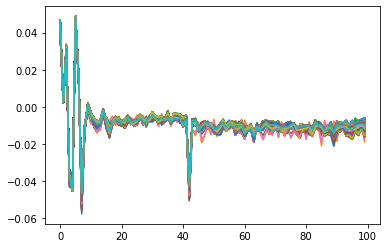

Discriminator Loss: -27502742725602234368.00000000 Generator Loss: 94742396007234093056.00000000:  25%|▎| 250/1000 [06:

disc:current fake and real ves:  tensor([ 7.9775e+09, -7.9793e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.5793e+09, -2.7937e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.2249e+09, -8.2266e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.2218e+09, -8.2235e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.2257e+09, -8.2275e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.2606e+09, -8.2623e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 8.2274e+09, -8.2295e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -26511673529046368256.00000000 Generator Loss: 96785578300851568640.00000000:  25%|▎| 251/1000 [06:

disc:current fake and real ves:  tensor([ 7.9249e+09, -7.9294e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6045e+09, -1.8576e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.3156e+09, -8.3171e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.2972e+09, -8.2986e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.3161e+09, -8.3175e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.3545e+09, -8.3560e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 8.3145e+09, -8.3164e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -21781452623279292416.00000000 Generator Loss: 99075037518267957248.00000000:  25%|▎| 252/1000 [06:

disc:current fake and real ves:  tensor([ 7.2548e+09, -7.2847e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.7340e+09, -2.9413e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.4263e+09, -8.4272e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.3791e+09, -8.3800e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.4085e+09, -8.4094e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.4444e+09, -8.4453e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 8.4152e+09, -8.4157e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 13234114506022414336.00000000 Generator Loss: 97348481112654479360.00000000:  25%|▎| 253/1000 [06:3

disc:current fake and real ves:  tensor([-1.3599e+10,  1.2167e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.8460e+09, -3.0517e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 7.4279e+09, -7.4294e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.4804e+09, -8.4822e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 7.9511e+09, -7.9525e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.5124e+09, -8.5142e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 8.5048e+09, -8.5063e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -30514254477869629440.00000000 Generator Loss: 105506010522361282560.00000000:  25%|▎| 254/1000 [06

disc:current fake and real ves:  tensor([ 8.6422e+09, -8.6442e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.4971e+08, -9.5977e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.5390e+09, -8.5410e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.5661e+09, -8.5681e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.6558e+09, -8.6577e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.6344e+09, -8.6363e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 8.6575e+09, -8.6595e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -31212670216757895168.00000000 Generator Loss: 108140748390717308928.00000000:  26%|▎| 255/1000 [06

disc:current fake and real ves:  tensor([ 8.3671e+09, -8.3678e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.7122e+08, -8.9460e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.7654e+09, -8.7660e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.7196e+09, -8.7202e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.7818e+09, -8.7824e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.8542e+09, -8.8548e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 8.7797e+09, -8.7809e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -34011735623723360256.00000000 Generator Loss: 113719680816523444224.00000000:  26%|▎| 256/1000 [06

disc:current fake and real ves:  tensor([ 8.9995e+09, -9.0009e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4376e+09, -1.7366e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.8991e+09, -8.9005e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.9465e+09, -8.9479e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 8.9826e+09, -8.9839e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.9872e+09, -8.9886e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 8.9864e+09, -8.9876e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -35144338127957282816.00000000 Generator Loss: 117972708577486143488.00000000:  26%|▎| 257/1000 [06

disc:current fake and real ves:  tensor([ 9.0460e+09, -9.0477e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.7174e+07, -4.3461e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.1144e+09, -9.1161e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.1375e+09, -9.1392e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.1738e+09, -9.1755e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.2498e+09, -9.2515e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 9.2092e+09, -9.2103e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -38633710091316084736.00000000 Generator Loss: 123152568387328098304.00000000:  26%|▎| 258/1000 [06

disc:current fake and real ves:  tensor([ 9.3696e+09, -9.3710e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.9699e+09, -2.2681e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.2800e+09, -9.2814e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.3531e+09, -9.3545e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.3801e+09, -9.3815e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.4516e+09, -9.4530e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 9.4712e+09, -9.4730e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -39224076625604755456.00000000 Generator Loss: 128265561940353138688.00000000:  26%|▎| 259/1000 [06

disc:current fake and real ves:  tensor([ 9.4990e+09, -9.5004e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.0529e+08, -2.9034e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.4940e+09, -9.4954e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.5643e+09, -9.5658e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.5509e+09, -9.5524e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.6907e+09, -9.6921e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 9.5622e+09, -9.5636e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -41630784467887513600.00000000 Generator Loss: 133481752188308848640.00000000:  26%|▎| 260/1000 [06

disc:current fake and real ves:  tensor([ 9.8349e+09, -9.8365e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.5611e+09, -3.8102e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.6716e+09, -9.6732e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.6988e+09, -9.7004e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.7673e+09, -9.7690e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.7760e+09, -9.7776e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 9.7513e+09, -9.7526e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -43019131561814138880.00000000 Generator Loss: 137172751905043775488.00000000:  26%|▎| 261/1000 [06

disc:current fake and real ves:  tensor([ 9.8152e+09, -9.8170e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.1669e+09, -3.4403e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.8588e+09, -9.8606e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.8981e+09, -9.8999e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.9476e+09, -9.9494e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.9192e+09, -9.9210e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 9.9569e+09, -9.9585e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -43126380843813740544.00000000 Generator Loss: 140734862550136127488.00000000:  26%|▎| 262/1000 [06

disc:current fake and real ves:  tensor([ 1.0013e+10, -1.0015e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.1991e+09,  7.3386e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 9.9795e+09, -9.9818e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0019e+10, -1.0021e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0019e+10, -1.0021e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0146e+10, -1.0148e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0024e+10, -1.0026e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -43134546932536868864.00000000 Generator Loss: 143184393703016005632.00000000:  26%|▎| 263/1000 [06

disc:current fake and real ves:  tensor([ 1.0030e+10, -1.0031e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.6931e+09,  1.2021e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0092e+10, -1.0093e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0127e+10, -1.0129e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0109e+10, -1.0111e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0258e+10, -1.0260e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0111e+10, -1.0113e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -43753194171910086656.00000000 Generator Loss: 144856520219014660096.00000000:  26%|▎| 264/1000 [06

disc:current fake and real ves:  tensor([ 1.0084e+10, -1.0085e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.4975e+09,  1.9689e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0172e+10, -1.0174e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0187e+10, -1.0189e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0171e+10, -1.0173e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0337e+10, -1.0339e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0171e+10, -1.0173e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -44345312252202565632.00000000 Generator Loss: 146407817714496110592.00000000:  26%|▎| 265/1000 [06

disc:current fake and real ves:  tensor([ 1.0148e+10, -1.0149e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-9.3063e+08,  4.6462e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0230e+10, -1.0232e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0261e+10, -1.0262e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0226e+10, -1.0227e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0352e+10, -1.0353e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0228e+10, -1.0229e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -45332384062354423808.00000000 Generator Loss: 147568878220559597568.00000000:  27%|▎| 266/1000 [06

disc:current fake and real ves:  tensor([ 1.0197e+10, -1.0198e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.7952e+09, -3.1057e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0270e+10, -1.0271e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0286e+10, -1.0288e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0266e+10, -1.0268e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0337e+10, -1.0338e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0266e+10, -1.0268e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -46055701263511126016.00000000 Generator Loss: 148220756008093089792.00000000:  27%|▎| 267/1000 [06

disc:current fake and real ves:  tensor([ 1.0222e+10, -1.0223e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.1292e+09,  2.5669e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0292e+10, -1.0293e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0317e+10, -1.0318e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0289e+10, -1.0290e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0547e+10, -1.0548e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0289e+10, -1.0290e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -45897782453937070080.00000000 Generator Loss: 148456910052586160128.00000000:  27%|▎| 268/1000 [06

disc:current fake and real ves:  tensor([ 1.0220e+10, -1.0221e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.9339e+08, -1.2860e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0300e+10, -1.0302e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0315e+10, -1.0317e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0297e+10, -1.0299e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0381e+10, -1.0383e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0297e+10, -1.0299e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -45001427576722178048.00000000 Generator Loss: 148520731861642477568.00000000:  27%|▎| 269/1000 [07

disc:current fake and real ves:  tensor([ 1.0224e+10, -1.0226e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-9.3326e+08,  4.6282e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0302e+10, -1.0304e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0340e+10, -1.0342e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0299e+10, -1.0301e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0497e+10, -1.0499e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0299e+10, -1.0301e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -45289912856638078976.00000000 Generator Loss: 148527439567522955264.00000000:  27%|▎| 270/1000 [07

disc:current fake and real ves:  tensor([ 1.0230e+10, -1.0231e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.2636e+08, -6.4761e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0303e+10, -1.0304e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0341e+10, -1.0342e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0300e+10, -1.0301e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0478e+10, -1.0479e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0300e+10, -1.0302e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -45473056615960092672.00000000 Generator Loss: 148675171244754698240.00000000:  27%|▎| 271/1000 [07

disc:current fake and real ves:  tensor([ 1.0231e+10, -1.0232e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4742e+08, -5.7194e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0311e+10, -1.0312e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0335e+10, -1.0336e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0305e+10, -1.0306e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0428e+10, -1.0428e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0305e+10, -1.0306e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -46067606387372949504.00000000 Generator Loss: 149071542829599850496.00000000:  27%|▎| 272/1000 [07

disc:current fake and real ves:  tensor([ 1.0238e+10, -1.0240e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.5009e+09, -4.7416e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0323e+10, -1.0325e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0345e+10, -1.0346e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0319e+10, -1.0321e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0374e+10, -1.0376e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0318e+10, -1.0320e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -46453981392924827648.00000000 Generator Loss: 149916341098465525760.00000000:  27%|▎| 273/1000 [07

disc:current fake and real ves:  tensor([ 1.0273e+10, -1.0275e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.8241e+09, -2.1798e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0352e+10, -1.0354e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0356e+10, -1.0358e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0347e+10, -1.0349e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0410e+10, -1.0412e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0348e+10, -1.0350e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -46657615944338104320.00000000 Generator Loss: 151283518452206108672.00000000:  27%|▎| 274/1000 [07

disc:current fake and real ves:  tensor([ 1.0319e+10, -1.0320e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.2633e+09, -5.4748e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0399e+10, -1.0400e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0406e+10, -1.0407e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0395e+10, -1.0396e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0430e+10, -1.0430e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0395e+10, -1.0396e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -48065068824726388736.00000000 Generator Loss: 153285451020842041344.00000000:  28%|▎| 275/1000 [07

disc:current fake and real ves:  tensor([ 1.0386e+10, -1.0387e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.8144e+09,  1.2998e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0467e+10, -1.0468e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0455e+10, -1.0456e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0464e+10, -1.0465e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0544e+10, -1.0545e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0464e+10, -1.0465e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -48480386929933910016.00000000 Generator Loss: 155983601636333158400.00000000:  28%|▎| 276/1000 [07

disc:current fake and real ves:  tensor([ 1.0194e+10, -1.0206e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.0192e+08, -7.3189e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0562e+10, -1.0563e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0534e+10, -1.0535e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0554e+10, -1.0555e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0625e+10, -1.0626e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0556e+10, -1.0558e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -50627104047539683328.00000000 Generator Loss: 159473336636694233088.00000000:  28%|▎| 277/1000 [07

disc:current fake and real ves:  tensor([ 1.0421e+10, -1.0428e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.0687e+09,  1.5339e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0678e+10, -1.0679e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0625e+10, -1.0626e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0672e+10, -1.0673e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0712e+10, -1.0713e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0675e+10, -1.0676e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 23383645282693210112.00000000 Generator Loss: 168879832872051802112.00000000:  28%|▎| 278/1000 [07:

disc:current fake and real ves:  tensor([-1.9508e+10,  1.7312e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3833e+09, -1.7747e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0379e+10, -1.0379e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0749e+10, -1.0750e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0887e+10, -1.0887e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0831e+10, -1.0831e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0963e+10, -1.0963e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -52446058449301749760.00000000 Generator Loss: 168592994004869316608.00000000:  28%|▎| 279/1000 [07

disc:current fake and real ves:  tensor([ 1.0911e+10, -1.0913e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.3135e+09, -2.6762e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0920e+10, -1.0922e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0939e+10, -1.0941e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.0967e+10, -1.0969e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0969e+10, -1.0971e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0963e+10, -1.0965e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -54378154823473938432.00000000 Generator Loss: 174079370986454319104.00000000:  28%|▎| 280/1000 [07

disc:current fake and real ves:  tensor([ 1.1123e+10, -1.1124e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.2405e+09, -2.6162e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.1118e+10, -1.1119e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1128e+10, -1.1129e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.1138e+10, -1.1139e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1179e+10, -1.1180e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.1162e+10, -1.1164e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -57267538476520718336.00000000 Generator Loss: 181908888417535295488.00000000:  28%|▎| 281/1000 [07

disc:current fake and real ves:  tensor([ 1.1320e+10, -1.1322e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.6358e+09, -3.9630e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.1337e+10, -1.1339e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1300e+10, -1.1302e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.1357e+10, -1.1359e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1321e+10, -1.1323e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.1426e+10, -1.1428e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -57469541295117484032.00000000 Generator Loss: 187621184416237912064.00000000:  28%|▎| 282/1000 [07

disc:current fake and real ves:  tensor([ 1.1486e+10, -1.1486e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.5717e+09, -3.9126e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.1512e+10, -1.1513e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1517e+10, -1.1518e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.1580e+10, -1.1581e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1540e+10, -1.1540e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.1588e+10, -1.1590e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -61226217390688174080.00000000 Generator Loss: 194582187251020333056.00000000:  28%|▎| 283/1000 [07

disc:current fake and real ves:  tensor([ 1.1721e+10, -1.1723e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.4261e+09, -3.7891e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.1769e+10, -1.1772e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1756e+10, -1.1759e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.1767e+10, -1.1769e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1794e+10, -1.1796e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.1769e+10, -1.1771e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -61148237730048122880.00000000 Generator Loss: 199807255806352982016.00000000:  28%|▎| 284/1000 [07

disc:current fake and real ves:  tensor([ 1.1892e+10, -1.1894e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.1786e+09, -4.5203e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.1939e+10, -1.1940e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1974e+10, -1.1975e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.1943e+10, -1.1944e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2000e+10, -1.2002e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.1943e+10, -1.1945e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -63754207836373065728.00000000 Generator Loss: 206961185366401089536.00000000:  28%|▎| 285/1000 [07

disc:current fake and real ves:  tensor([ 1.2114e+10, -1.2116e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.6902e+08, -8.9460e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.2152e+10, -1.2153e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2155e+10, -1.2156e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.2161e+10, -1.2162e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2216e+10, -1.2217e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.2162e+10, -1.2164e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -64792615741618126848.00000000 Generator Loss: 212838963615427821568.00000000:  29%|▎| 286/1000 [07

disc:current fake and real ves:  tensor([ 1.2282e+10, -1.2284e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.2114e+09, -5.5312e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.2329e+10, -1.2331e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2350e+10, -1.2352e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.2326e+10, -1.2329e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2359e+10, -1.2361e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.2328e+10, -1.2330e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -67967762153395159040.00000000 Generator Loss: 218351683408789110784.00000000:  29%|▎| 287/1000 [07

disc:current fake and real ves:  tensor([ 1.2356e+10, -1.2358e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.0211e+09,  4.2177e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.2489e+10, -1.2491e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2518e+10, -1.2520e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.2488e+10, -1.2490e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2586e+10, -1.2587e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.2491e+10, -1.2492e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -68459723396040892416.00000000 Generator Loss: 223416923069309288448.00000000:  29%|▎| 288/1000 [07

disc:current fake and real ves:  tensor([ 1.2594e+10, -1.2596e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.5439e+08, -3.4157e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.2634e+10, -1.2635e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2653e+10, -1.2654e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.2632e+10, -1.2634e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2675e+10, -1.2677e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.2633e+10, -1.2635e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -70555045898276970496.00000000 Generator Loss: 227590500646661128192.00000000:  29%|▎| 289/1000 [07

disc:current fake and real ves:  tensor([ 1.2710e+10, -1.2712e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.7774e+09, -5.1466e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.2751e+10, -1.2752e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2759e+10, -1.2761e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.2750e+10, -1.2751e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2765e+10, -1.2767e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.2751e+10, -1.2752e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -69925611460560224256.00000000 Generator Loss: 230743824856423366656.00000000:  29%|▎| 290/1000 [07

disc:current fake and real ves:  tensor([ 1.2672e+10, -1.2674e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.5687e+09,  8.9428e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.2838e+10, -1.2840e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2861e+10, -1.2863e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.2837e+10, -1.2839e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2866e+10, -1.2868e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.2839e+10, -1.2839e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -71994441161703194624.00000000 Generator Loss: 232938320651329863680.00000000:  29%|▎| 291/1000 [07

disc:current fake and real ves:  tensor([ 1.2737e+10, -1.2738e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.8250e+09, -5.2007e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.2900e+10, -1.2901e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2907e+10, -1.2908e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.2899e+10, -1.2901e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2916e+10, -1.2917e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.2900e+10, -1.2901e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -70806192341729411072.00000000 Generator Loss: 234257063735757045760.00000000:  29%|▎| 292/1000 [07

disc:current fake and real ves:  tensor([ 1.2843e+10, -1.2845e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.4068e+09,  1.6860e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.2939e+10, -1.2940e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2904e+10, -1.2905e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.2935e+10, -1.2937e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3003e+10, -1.3004e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.2935e+10, -1.2937e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -69687615419419017216.00000000 Generator Loss: 234884452568166301696.00000000:  29%|▎| 293/1000 [07

disc:current fake and real ves:  tensor([ 1.2627e+10, -1.2635e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.4164e+09, -8.6246e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.2959e+10, -1.2960e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2954e+10, -1.2956e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.2952e+10, -1.2954e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2955e+10, -1.2957e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.2952e+10, -1.2954e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -69164641063167590400.00000000 Generator Loss: 235153138516282277888.00000000:  29%|▎| 294/1000 [07

disc:current fake and real ves:  tensor([ 1.2603e+10, -1.2611e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.0326e+09, -2.5436e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.2965e+10, -1.2966e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2965e+10, -1.2965e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.2960e+10, -1.2961e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2972e+10, -1.2972e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.2960e+10, -1.2961e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -69160234140081799168.00000000 Generator Loss: 235189670800144826368.00000000:  30%|▎| 295/1000 [07

disc:current fake and real ves:  tensor([ 1.2559e+10, -1.2570e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.6238e+09, -5.9643e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.2966e+10, -1.2967e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2967e+10, -1.2968e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.2962e+10, -1.2962e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2968e+10, -1.2969e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.2962e+10, -1.2963e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -69806083947792547840.00000000 Generator Loss: 235250434661129814016.00000000:  30%|▎| 296/1000 [07

disc:current fake and real ves:  tensor([ 1.2589e+10, -1.2599e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.8713e+09, -6.2003e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.2968e+10, -1.2969e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2967e+10, -1.2969e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.2964e+10, -1.2965e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2972e+10, -1.2974e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.2964e+10, -1.2965e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -69207527447431127040.00000000 Generator Loss: 235472661796735975424.00000000:  30%|▎| 297/1000 [07

disc:current fake and real ves:  tensor([ 1.2658e+10, -1.2665e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.0609e+09, -4.4763e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.2976e+10, -1.2978e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2974e+10, -1.2976e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.2969e+10, -1.2970e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2978e+10, -1.2980e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.2968e+10, -1.2970e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -64422842043123933184.00000000 Generator Loss: 236204531162603520000.00000000:  30%|▎| 298/1000 [07

disc:current fake and real ves:  tensor([ 1.2146e+10, -1.2176e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.0713e+09,  1.3632e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.3000e+10, -1.3001e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2978e+10, -1.2978e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.2990e+10, -1.2990e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3017e+10, -1.3018e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.2989e+10, -1.2990e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 6811127295861102592.00000000 Generator Loss: 231649517284206444544.00000000:  30%|▎| 299/1000 [07:4

disc:current fake and real ves:  tensor([-1.2443e+10,  1.0837e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.7257e+09, -3.2070e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.2934e+10, -1.2935e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3008e+10, -1.3009e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.2998e+10, -1.2999e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3039e+10, -1.3040e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.2843e+10, -1.2844e+10], device='cuda:0', grad_fn=<SelectBackward0>)


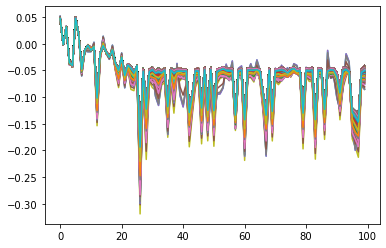

Discriminator Loss: 541721064597763392.00000000 Generator Loss: 238970781654687023104.00000000:  30%|▎| 300/1000 [07:48

disc:current fake and real ves:  tensor([-2.7997e+09,  2.0466e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.3723e+08, -2.9347e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.3476e+10, -1.3477e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3092e+10, -1.3094e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.3059e+10, -1.3060e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3100e+10, -1.3101e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.3059e+10, -1.3060e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -74263097414312296448.00000000 Generator Loss: 239777685039496855552.00000000:  30%|▎| 301/1000 [07

disc:current fake and real ves:  tensor([ 1.3077e+10, -1.3079e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.3489e+08, -9.3698e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.3087e+10, -1.3089e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3133e+10, -1.3135e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.3087e+10, -1.3089e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3129e+10, -1.3131e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.3091e+10, -1.3092e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -75058613833615687680.00000000 Generator Loss: 244056429267406290944.00000000:  30%|▎| 302/1000 [07

disc:current fake and real ves:  tensor([ 1.3184e+10, -1.3186e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.3850e+09,  1.6444e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.3204e+10, -1.3207e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3290e+10, -1.3292e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.3203e+10, -1.3205e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3335e+10, -1.3337e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.3205e+10, -1.3207e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -76744643254747561984.00000000 Generator Loss: 249545983256907776000.00000000:  30%|▎| 303/1000 [07

disc:current fake and real ves:  tensor([ 1.3329e+10, -1.3330e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.6249e+09,  2.8162e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.3351e+10, -1.3353e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3414e+10, -1.3416e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.3351e+10, -1.3352e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3447e+10, -1.3448e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.3352e+10, -1.3354e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -79664888949745893376.00000000 Generator Loss: 256099009382527959040.00000000:  30%|▎| 304/1000 [07

disc:current fake and real ves:  tensor([ 1.3505e+10, -1.3507e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.2986e+09,  2.4939e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.3526e+10, -1.3528e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3582e+10, -1.3584e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.3524e+10, -1.3527e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3582e+10, -1.3584e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.3527e+10, -1.3529e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -82551154904402362368.00000000 Generator Loss: 263787062180187504640.00000000:  30%|▎| 305/1000 [07

disc:current fake and real ves:  tensor([ 1.3705e+10, -1.3708e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.0959e+09, -2.6536e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.3728e+10, -1.3730e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3768e+10, -1.3771e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.3726e+10, -1.3728e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3789e+10, -1.3791e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.3730e+10, -1.3732e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -85582270069923741696.00000000 Generator Loss: 272479534501929779200.00000000:  31%|▎| 306/1000 [07

disc:current fake and real ves:  tensor([ 1.3841e+10, -1.3844e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.9823e+09,  5.0193e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.3951e+10, -1.3953e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3985e+10, -1.3988e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.3950e+10, -1.3953e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3988e+10, -1.3991e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.3955e+10, -1.3957e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -82285004693887778816.00000000 Generator Loss: 281932449020547792896.00000000:  31%|▎| 307/1000 [07

disc:current fake and real ves:  tensor([ 1.3936e+10, -1.3943e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.6597e+08, -1.6048e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.4193e+10, -1.4195e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4210e+10, -1.4212e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.4190e+10, -1.4193e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4213e+10, -1.4215e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.4195e+10, -1.4197e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 14523910382973894656.00000000 Generator Loss: 268118104264489304064.00000000:  31%|▎| 308/1000 [08:

disc:current fake and real ves:  tensor([-4.5532e+10,  3.9365e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.3135e+09,  5.5830e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.7228e+10, -1.7230e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4404e+10, -1.4407e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.3829e+10, -1.3831e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4413e+10, -1.4415e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.3912e+10, -1.3914e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -90386288155658158080.00000000 Generator Loss: 298238157046669115392.00000000:  31%|▎| 309/1000 [08

disc:current fake and real ves:  tensor([ 1.4586e+10, -1.4588e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.8535e+07, -6.2788e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.4538e+10, -1.4540e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4601e+10, -1.4603e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.4577e+10, -1.4579e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4614e+10, -1.4616e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.4674e+10, -1.4675e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -92943523401735094272.00000000 Generator Loss: 308154909734185205760.00000000:  31%|▎| 310/1000 [08

disc:current fake and real ves:  tensor([ 1.4827e+10, -1.4829e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.1159e+08, -1.3860e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.4769e+10, -1.4771e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4864e+10, -1.4866e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.4815e+10, -1.4817e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4889e+10, -1.4892e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.4819e+10, -1.4821e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -97772075205047091200.00000000 Generator Loss: 317014149312396394496.00000000:  31%|▎| 311/1000 [08

disc:current fake and real ves:  tensor([ 1.5086e+10, -1.5089e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.8890e+08, -1.4750e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5007e+10, -1.5010e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5088e+10, -1.5090e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5065e+10, -1.5068e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5130e+10, -1.5133e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.5041e+10, -1.5044e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -100492648939563466752.00000000 Generator Loss: 326249064766133501952.00000000:  31%|▎| 312/1000 [0

disc:current fake and real ves:  tensor([ 1.5273e+10, -1.5275e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.4528e+09, -3.0702e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5224e+10, -1.5226e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5265e+10, -1.5267e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5256e+10, -1.5257e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5283e+10, -1.5285e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.5258e+10, -1.5260e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -101938598247267385344.00000000 Generator Loss: 333620102033529372672.00000000:  31%|▎| 313/1000 [0

disc:current fake and real ves:  tensor([ 1.5457e+10, -1.5459e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.5677e+08, -1.2809e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5402e+10, -1.5405e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5461e+10, -1.5463e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5442e+10, -1.5444e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5482e+10, -1.5485e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.5436e+10, -1.5439e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -105247891767032233984.00000000 Generator Loss: 341259335887865118720.00000000:  31%|▎| 314/1000 [0

disc:current fake and real ves:  tensor([ 1.5594e+10, -1.5596e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.3490e+08, -1.2715e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5589e+10, -1.5591e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5664e+10, -1.5667e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5612e+10, -1.5614e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5748e+10, -1.5750e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.5612e+10, -1.5614e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -106710680984145362944.00000000 Generator Loss: 344874764406290972672.00000000:  32%|▎| 315/1000 [0

disc:current fake and real ves:  tensor([ 1.5675e+10, -1.5678e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.1771e+09, -7.5933e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5685e+10, -1.5687e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5768e+10, -1.5770e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5704e+10, -1.5707e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5810e+10, -1.5813e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.5696e+10, -1.5697e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -106589201816310595584.00000000 Generator Loss: 348114325616205430784.00000000:  32%|▎| 316/1000 [0

disc:current fake and real ves:  tensor([ 1.5738e+10, -1.5740e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.1408e+09, -3.7638e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5765e+10, -1.5768e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5917e+10, -1.5920e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5768e+10, -1.5771e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5939e+10, -1.5942e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.5768e+10, -1.5771e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -107788704508030304256.00000000 Generator Loss: 350951774048755646464.00000000:  32%|▎| 317/1000 [0

disc:current fake and real ves:  tensor([ 1.5803e+10, -1.5806e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.9763e+09, -2.6604e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5831e+10, -1.5834e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5874e+10, -1.5877e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5833e+10, -1.5836e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5899e+10, -1.5902e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.5830e+10, -1.5833e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -107947014111193137152.00000000 Generator Loss: 352057965146148241408.00000000:  32%|▎| 318/1000 [0

disc:current fake and real ves:  tensor([ 1.5821e+10, -1.5824e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.2169e+08, -2.8964e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5860e+10, -1.5862e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5930e+10, -1.5932e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5857e+10, -1.5860e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5979e+10, -1.5982e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.5858e+10, -1.5861e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -108297816900673863680.00000000 Generator Loss: 352737787839225593856.00000000:  32%|▎| 319/1000 [0

disc:current fake and real ves:  tensor([ 1.5834e+10, -1.5838e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1280e+09, -1.8590e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5875e+10, -1.5878e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5997e+10, -1.6000e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5872e+10, -1.5876e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6028e+10, -1.6031e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.5872e+10, -1.5875e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -110086295693660209152.00000000 Generator Loss: 352947567658707255296.00000000:  32%|▎| 320/1000 [0

disc:current fake and real ves:  tensor([ 1.5837e+10, -1.5840e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.6568e+09, -3.3112e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5880e+10, -1.5883e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5934e+10, -1.5937e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5877e+10, -1.5879e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5971e+10, -1.5974e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.5877e+10, -1.5880e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -108269156920495980544.00000000 Generator Loss: 352967496594823118848.00000000:  32%|▎| 321/1000 [0

disc:current fake and real ves:  tensor([ 1.5839e+10, -1.5841e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.2391e+09,  1.3402e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5881e+10, -1.5884e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5980e+10, -1.5982e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5878e+10, -1.5880e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6070e+10, -1.6072e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.5877e+10, -1.5880e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -107657758278276939776.00000000 Generator Loss: 353168934082471329792.00000000:  32%|▎| 322/1000 [0

disc:current fake and real ves:  tensor([ 1.5846e+10, -1.5848e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.5723e+08, -6.3783e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5887e+10, -1.5889e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6005e+10, -1.6006e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5882e+10, -1.5884e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6053e+10, -1.6055e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.5882e+10, -1.5884e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -108240043696162570240.00000000 Generator Loss: 353778001704489385984.00000000:  32%|▎| 323/1000 [0

disc:current fake and real ves:  tensor([ 1.5857e+10, -1.5859e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.9878e+08, -1.1673e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5897e+10, -1.5900e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5983e+10, -1.5986e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5896e+10, -1.5898e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6008e+10, -1.6010e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.5895e+10, -1.5898e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -109571174724249354240.00000000 Generator Loss: 355192378678962421760.00000000:  32%|▎| 324/1000 [0

disc:current fake and real ves:  tensor([ 1.5887e+10, -1.5891e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.1465e+09, -4.7312e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5931e+10, -1.5934e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5987e+10, -1.5991e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5927e+10, -1.5930e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6006e+10, -1.6009e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.5928e+10, -1.5931e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -110789079922464800768.00000000 Generator Loss: 357591867100590505984.00000000:  32%|▎| 325/1000 [0

disc:current fake and real ves:  tensor([ 1.5940e+10, -1.5943e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.6211e+09, -5.1860e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5985e+10, -1.5988e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6028e+10, -1.6031e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.5981e+10, -1.5984e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6050e+10, -1.6053e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.5982e+10, -1.5984e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -110714857917791010816.00000000 Generator Loss: 361263251567241854976.00000000:  33%|▎| 326/1000 [0

disc:current fake and real ves:  tensor([ 1.6024e+10, -1.6026e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.8421e+09, -2.5517e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.6067e+10, -1.6068e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6108e+10, -1.6110e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.6063e+10, -1.6065e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6141e+10, -1.6142e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.6063e+10, -1.6065e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -113099870615011278848.00000000 Generator Loss: 366222786762821599232.00000000:  33%|▎| 327/1000 [0

disc:current fake and real ves:  tensor([ 1.6135e+10, -1.6138e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.4791e+09, -3.1668e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.6176e+10, -1.6179e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6213e+10, -1.6216e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.6174e+10, -1.6176e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6248e+10, -1.6251e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.6175e+10, -1.6177e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -115952900607816302592.00000000 Generator Loss: 372704482659906289664.00000000:  33%|▎| 328/1000 [0

disc:current fake and real ves:  tensor([ 1.6275e+10, -1.6278e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.6760e+09,  2.6664e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.6318e+10, -1.6321e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6363e+10, -1.6366e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.6315e+10, -1.6318e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6433e+10, -1.6436e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.6318e+10, -1.6321e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -117785235319173677056.00000000 Generator Loss: 380812649700177346560.00000000:  33%|▎| 329/1000 [0

disc:current fake and real ves:  tensor([ 1.6445e+10, -1.6447e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.7689e+07, -8.5309e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.6495e+10, -1.6497e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6521e+10, -1.6523e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.6492e+10, -1.6494e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6589e+10, -1.6591e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.6494e+10, -1.6497e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -118152847724265537536.00000000 Generator Loss: 390231312424857501696.00000000:  33%|▎| 330/1000 [0

disc:current fake and real ves:  tensor([ 1.6289e+10, -1.6302e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1606e+09, -1.9446e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.6699e+10, -1.6702e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6702e+10, -1.6704e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.6695e+10, -1.6698e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6739e+10, -1.6742e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.6697e+10, -1.6700e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -8875578408061858816.00000000 Generator Loss: 414413448887500537856.00000000:  33%|▎| 331/1000 [08:

disc:current fake and real ves:  tensor([ 1.1488e+10, -1.1771e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.1525e+08, -1.7217e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.7311e+10, -1.7313e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6901e+10, -1.6903e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.7322e+10, -1.7324e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6942e+10, -1.6944e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.7149e+10, -1.7150e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -127029683691683119104.00000000 Generator Loss: 412674325613747765248.00000000:  33%|▎| 332/1000 [0

disc:current fake and real ves:  tensor([ 1.7188e+10, -1.7191e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.7312e+08, -1.7894e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.7109e+10, -1.7111e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.7144e+10, -1.7146e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.7195e+10, -1.7198e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.7195e+10, -1.7198e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.7174e+10, -1.7177e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -130531203419391426560.00000000 Generator Loss: 427243042656430325760.00000000:  33%|▎| 333/1000 [0

disc:current fake and real ves:  tensor([ 1.7368e+10, -1.7369e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.9251e+08, -7.0808e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.7370e+10, -1.7371e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.7485e+10, -1.7487e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.7418e+10, -1.7420e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.7535e+10, -1.7536e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.7762e+10, -1.7764e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -135695261811450740736.00000000 Generator Loss: 439214583969590870016.00000000:  33%|▎| 334/1000 [0

disc:current fake and real ves:  tensor([ 1.7787e+10, -1.7790e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.9589e+09, -4.6651e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.7656e+10, -1.7659e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.7643e+10, -1.7647e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.7768e+10, -1.7772e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.7652e+10, -1.7655e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.7691e+10, -1.7694e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -138910215194101186560.00000000 Generator Loss: 450345455394223554560.00000000:  34%|▎| 335/1000 [0

disc:current fake and real ves:  tensor([ 1.7879e+10, -1.7882e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6372e+09, -2.4891e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.7912e+10, -1.7915e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.8009e+10, -1.8012e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.7925e+10, -1.7928e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.8046e+10, -1.8049e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.7924e+10, -1.7926e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -143766815114685939712.00000000 Generator Loss: 465096194503335018496.00000000:  34%|▎| 336/1000 [0

disc:current fake and real ves:  tensor([ 1.8194e+10, -1.8196e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.7755e+08, -1.1310e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.8213e+10, -1.8214e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.8272e+10, -1.8274e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.8301e+10, -1.8303e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.8361e+10, -1.8363e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.8236e+10, -1.8238e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -150817764246000074752.00000000 Generator Loss: 478725237302841769984.00000000:  34%|▎| 337/1000 [0

disc:current fake and real ves:  tensor([ 1.8444e+10, -1.8446e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.3386e+09, -3.1942e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.8502e+10, -1.8503e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.8512e+10, -1.8513e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.8492e+10, -1.8494e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.8613e+10, -1.8614e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.8475e+10, -1.8477e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -152884072024327520256.00000000 Generator Loss: 491437617182421221376.00000000:  34%|▎| 338/1000 [0

disc:current fake and real ves:  tensor([ 1.8678e+10, -1.8680e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.1053e+09,  1.9380e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.8696e+10, -1.8698e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.8718e+10, -1.8720e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.8743e+10, -1.8745e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.8800e+10, -1.8802e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.8740e+10, -1.8742e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -153857396624309157888.00000000 Generator Loss: 497217047720957640704.00000000:  34%|▎| 339/1000 [0

disc:current fake and real ves:  tensor([ 1.8813e+10, -1.8815e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.1071e+09, -5.8439e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.8849e+10, -1.8852e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.8891e+10, -1.8894e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.8856e+10, -1.8859e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.8920e+10, -1.8923e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.8843e+10, -1.8846e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -137404157558343352320.00000000 Generator Loss: 505057038270379589632.00000000:  34%|▎| 340/1000 [0

disc:current fake and real ves:  tensor([ 1.7952e+10, -1.7994e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5789e+09, -2.5136e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.9010e+10, -1.9012e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.9049e+10, -1.9052e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.8992e+10, -1.8994e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.9081e+10, -1.9084e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.9004e+10, -1.9007e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -148409354626973466624.00000000 Generator Loss: 510954035605538406400.00000000:  34%|▎| 341/1000 [0

disc:current fake and real ves:  tensor([ 1.8629e+10, -1.8636e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.6360e+08, -6.8349e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.9119e+10, -1.9121e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.9162e+10, -1.9165e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.9104e+10, -1.9106e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.9213e+10, -1.9215e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.9105e+10, -1.9108e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -145641830948464394240.00000000 Generator Loss: 515339626883113156608.00000000:  34%|▎| 342/1000 [0

disc:current fake and real ves:  tensor([ 1.8125e+10, -1.8162e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.8522e+08, -1.9614e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.9207e+10, -1.9210e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.9235e+10, -1.9238e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.9185e+10, -1.9187e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.9260e+10, -1.9263e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.9185e+10, -1.9188e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -147562499767354458112.00000000 Generator Loss: 518263193109086142464.00000000:  34%|▎| 343/1000 [0

disc:current fake and real ves:  tensor([ 1.8601e+10, -1.8612e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.9791e+09, -6.6837e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.9256e+10, -1.9258e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.9275e+10, -1.9277e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.9241e+10, -1.9243e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.9270e+10, -1.9272e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.9240e+10, -1.9242e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -146045827346256166912.00000000 Generator Loss: 519749968580191649792.00000000:  34%|▎| 344/1000 [0

disc:current fake and real ves:  tensor([ 1.7980e+10, -1.8026e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.9351e+09,  7.9532e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.9287e+10, -1.9290e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.9318e+10, -1.9321e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.9267e+10, -1.9270e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.9360e+10, -1.9363e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.9268e+10, -1.9271e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -145554132449815035904.00000000 Generator Loss: 520391555977425780736.00000000:  34%|▎| 345/1000 [0

disc:current fake and real ves:  tensor([ 1.8490e+10, -1.8507e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.4426e+08, -1.7375e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.9300e+10, -1.9302e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.9322e+10, -1.9324e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.9278e+10, -1.9280e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.9335e+10, -1.9337e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.9278e+10, -1.9280e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -143624662609116938240.00000000 Generator Loss: 520549634626620489728.00000000:  35%|▎| 346/1000 [0

disc:current fake and real ves:  tensor([ 1.8377e+10, -1.8400e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.8789e+09, -5.6454e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.9303e+10, -1.9305e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.9364e+10, -1.9365e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.9282e+10, -1.9283e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.9376e+10, -1.9377e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.9283e+10, -1.9284e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -144975063217194811392.00000000 Generator Loss: 520583775120753229824.00000000:  35%|▎| 347/1000 [0

disc:current fake and real ves:  tensor([ 1.8669e+10, -1.8676e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.3487e+09, -4.1990e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.9299e+10, -1.9301e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.9345e+10, -1.9346e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.9284e+10, -1.9286e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.9402e+10, -1.9403e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.9283e+10, -1.9284e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -145088925989029871616.00000000 Generator Loss: 520898691474537775104.00000000:  35%|▎| 348/1000 [0

disc:current fake and real ves:  tensor([ 1.8682e+10, -1.8690e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.7707e+09, -3.6543e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.9305e+10, -1.9308e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.9340e+10, -1.9343e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.9288e+10, -1.9291e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.9356e+10, -1.9359e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.9288e+10, -1.9291e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -145508724984390844416.00000000 Generator Loss: 522115507434421092352.00000000:  35%|▎| 349/1000 [0

disc:current fake and real ves:  tensor([ 1.8350e+10, -1.8376e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.8260e+09, -6.5410e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.9330e+10, -1.9332e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.9341e+10, -1.9343e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.9312e+10, -1.9315e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.9360e+10, -1.9363e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.9311e+10, -1.9314e+10], device='cuda:0', grad_fn=<SelectBackward0>)


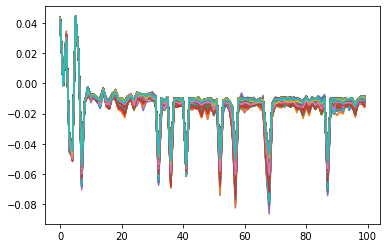

Discriminator Loss: -122197300876541853696.00000000 Generator Loss: 523932300833693171712.00000000:  35%|▎| 350/1000 [0

disc:current fake and real ves:  tensor([ 1.5927e+10, -1.6089e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.0566e+09, -3.9261e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.9411e+10, -1.9414e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.9386e+10, -1.9389e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.9345e+10, -1.9347e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.9406e+10, -1.9408e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.9345e+10, -1.9347e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -14323380001662763008.00000000 Generator Loss: 524407010506121936896.00000000:  35%|▎| 351/1000 [09

disc:current fake and real ves:  tensor([ 6.4005e+09, -7.1186e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1783e+09, -2.1534e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.0109e+10, -2.0111e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.9452e+10, -1.9454e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.9315e+10, -1.9317e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.9457e+10, -1.9459e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.9291e+10, -1.9293e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -161797704077245612032.00000000 Generator Loss: 531185119973770526720.00000000:  35%|▎| 352/1000 [0

disc:current fake and real ves:  tensor([ 1.9493e+10, -1.9495e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.3836e+09, -5.1886e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.9498e+10, -1.9500e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.9609e+10, -1.9611e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.9478e+10, -1.9480e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.9618e+10, -1.9620e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.9474e+10, -1.9476e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -162947715780493148160.00000000 Generator Loss: 538043585819372617728.00000000:  35%|▎| 353/1000 [0

disc:current fake and real ves:  tensor([ 1.9587e+10, -1.9589e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.9663e+09,  3.6378e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.9606e+10, -1.9607e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.9721e+10, -1.9722e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.9604e+10, -1.9606e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.9701e+10, -1.9703e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.9608e+10, -1.9609e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -165645435651102834688.00000000 Generator Loss: 547933868655056715776.00000000:  35%|▎| 354/1000 [0

disc:current fake and real ves:  tensor([ 1.9767e+10, -1.9769e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.9764e+09, -9.5460e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.9787e+10, -1.9789e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.9824e+10, -1.9826e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.9782e+10, -1.9784e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.9816e+10, -1.9818e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.9785e+10, -1.9787e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -172082938163008700416.00000000 Generator Loss: 559826065443462643712.00000000:  36%|▎| 355/1000 [0

disc:current fake and real ves:  tensor([ 1.9687e+10, -1.9688e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.8411e+09, -5.6534e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.0005e+10, -2.0006e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.0032e+10, -2.0033e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 1.9996e+10, -1.9998e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.0034e+10, -2.0035e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.0000e+10, -2.0001e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -707133657411638528.00000000 Generator Loss: 566277931293124067328.00000000:  36%|▎| 356/1000 [09:1

disc:current fake and real ves:  tensor([-1.1911e+10,  9.9573e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.9442e+09, -8.5983e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.1187e+10, -2.1190e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.0231e+10, -2.0235e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.0088e+10, -2.0091e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.0210e+10, -2.0213e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.0128e+10, -2.0131e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -179195836075421171712.00000000 Generator Loss: 582503275836882747392.00000000:  36%|▎| 357/1000 [0

disc:current fake and real ves:  tensor([ 2.0376e+10, -2.0379e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.1948e+09, -3.1852e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.0396e+10, -2.0399e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.0474e+10, -2.0476e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.0395e+10, -2.0397e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.0466e+10, -2.0468e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.0398e+10, -2.0400e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -183396407639462838272.00000000 Generator Loss: 601006591192015699968.00000000:  36%|▎| 358/1000 [0

disc:current fake and real ves:  tensor([ 2.0735e+10, -2.0737e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.9524e+09, -2.9771e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.0768e+10, -2.0771e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.0821e+10, -2.0823e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.0717e+10, -2.0720e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.0860e+10, -2.0863e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.0738e+10, -2.0739e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -193229427803369144320.00000000 Generator Loss: 617712863570953764864.00000000:  36%|▎| 359/1000 [0

disc:current fake and real ves:  tensor([ 2.0841e+10, -2.0845e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.7681e+09, -2.8223e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.1036e+10, -2.1039e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.1057e+10, -2.1060e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.1006e+10, -2.1009e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.1038e+10, -2.1042e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.1007e+10, -2.1010e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3980968040808076288.00000000 Generator Loss: 638542533271539941376.00000000:  36%|▎| 360/1000 [09:

disc:current fake and real ves:  tensor([-1.7906e+10,  1.4968e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.6393e+09, -4.6076e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.2779e+10, -2.2782e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.1366e+10, -2.1370e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.1261e+10, -2.1264e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.1318e+10, -2.1321e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.1433e+10, -2.1435e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -199774096980797030400.00000000 Generator Loss: 649446639444535803904.00000000:  36%|▎| 361/1000 [0

disc:current fake and real ves:  tensor([ 2.1547e+10, -2.1549e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.5475e+09, -9.2580e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.1536e+10, -2.1537e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.1629e+10, -2.1631e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.1538e+10, -2.1540e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.1622e+10, -2.1624e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.1533e+10, -2.1535e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -210585425166948499456.00000000 Generator Loss: 669236124517391007744.00000000:  36%|▎| 362/1000 [0

disc:current fake and real ves:  tensor([ 2.1897e+10, -2.1900e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.9945e+09, -5.9254e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.1881e+10, -2.1884e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.1931e+10, -2.1933e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.1869e+10, -2.1871e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.1911e+10, -2.1914e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.1871e+10, -2.1874e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -211737476210092867584.00000000 Generator Loss: 685053749834725982208.00000000:  36%|▎| 363/1000 [0

disc:current fake and real ves:  tensor([ 2.2124e+10, -2.2127e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.9240e+09,  4.3598e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.2144e+10, -2.2147e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.2287e+10, -2.2290e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.2119e+10, -2.2121e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.2266e+10, -2.2269e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.2124e+10, -2.2126e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -167018828173467877376.00000000 Generator Loss: 699857288764272017408.00000000:  36%|▎| 364/1000 [0

disc:current fake and real ves:  tensor([ 1.9746e+10, -1.9876e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.4435e+09,  2.0059e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.2486e+10, -2.2490e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.2464e+10, -2.2468e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.2359e+10, -2.2362e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.2395e+10, -2.2398e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.2364e+10, -2.2368e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -220653501527142039552.00000000 Generator Loss: 709629375575972511744.00000000:  36%|▎| 365/1000 [0

disc:current fake and real ves:  tensor([ 2.2554e+10, -2.2558e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.3249e+09, -8.1670e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.2517e+10, -2.2521e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.2674e+10, -2.2678e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.2520e+10, -2.2524e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.2676e+10, -2.2680e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.2513e+10, -2.2516e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -223515932066549891072.00000000 Generator Loss: 719895337238087729152.00000000:  37%|▎| 366/1000 [0

disc:current fake and real ves:  tensor([ 2.2680e+10, -2.2683e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.9312e+08, -7.0881e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.2687e+10, -2.2690e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.2842e+10, -2.2844e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.2674e+10, -2.2676e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.2819e+10, -2.2821e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.2675e+10, -2.2679e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -224339762321686528000.00000000 Generator Loss: 727644457730509897728.00000000:  37%|▎| 367/1000 [0

disc:current fake and real ves:  tensor([ 2.2794e+10, -2.2797e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.7299e+09, -7.6229e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.2800e+10, -2.2803e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.2905e+10, -2.2907e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.2797e+10, -2.2800e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.2877e+10, -2.2879e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.2797e+10, -2.2800e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -228571026734766817280.00000000 Generator Loss: 733355455664323297280.00000000:  37%|▎| 368/1000 [0

disc:current fake and real ves:  tensor([ 2.2885e+10, -2.2888e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-6.8516e+09,  5.1812e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.2890e+10, -2.2893e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.3038e+10, -2.3041e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.2886e+10, -2.2888e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.2979e+10, -2.2982e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.2886e+10, -2.2888e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -226599066557273800704.00000000 Generator Loss: 736626816595787251712.00000000:  37%|▎| 369/1000 [0

disc:current fake and real ves:  tensor([ 2.2925e+10, -2.2929e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.2334e+09,  8.2208e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.2944e+10, -2.2948e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.3092e+10, -2.3096e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.2938e+10, -2.2942e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.3066e+10, -2.3070e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.2936e+10, -2.2941e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -229410015172666589184.00000000 Generator Loss: 738229034103057940480.00000000:  37%|▎| 370/1000 [0

disc:current fake and real ves:  tensor([ 2.2955e+10, -2.2958e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.4924e+09, -4.5781e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.2973e+10, -2.2977e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.3033e+10, -2.3036e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.2962e+10, -2.2965e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.2994e+10, -2.2997e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.2962e+10, -2.2965e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -229335531172045422592.00000000 Generator Loss: 739073900593698570240.00000000:  37%|▎| 371/1000 [0

disc:current fake and real ves:  tensor([ 2.2967e+10, -2.2970e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.6908e+09, -3.8243e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.2979e+10, -2.2982e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.3106e+10, -2.3109e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.2975e+10, -2.2978e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.3073e+10, -2.3076e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.2975e+10, -2.2978e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -231984593324211339264.00000000 Generator Loss: 739085983249214603264.00000000:  37%|▎| 372/1000 [0

disc:current fake and real ves:  tensor([ 2.2967e+10, -2.2970e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.5181e+09, -8.3774e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.2981e+10, -2.2984e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.3058e+10, -2.3061e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.2975e+10, -2.2978e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.3040e+10, -2.3043e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.2975e+10, -2.2978e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -229515817304206475264.00000000 Generator Loss: 739197797466697891840.00000000:  37%|▎| 373/1000 [0

disc:current fake and real ves:  tensor([ 2.2968e+10, -2.2971e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.1690e+09, -6.1612e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.2982e+10, -2.2984e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.3063e+10, -2.3065e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.2977e+10, -2.2979e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.3020e+10, -2.3023e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.2976e+10, -2.2979e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -230004075643914321920.00000000 Generator Loss: 739784400923023638528.00000000:  37%|▎| 374/1000 [0

disc:current fake and real ves:  tensor([ 2.2984e+10, -2.2987e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.4234e+09, -3.5737e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.3001e+10, -2.3004e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.3136e+10, -2.3139e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.2986e+10, -2.2989e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.3106e+10, -2.3109e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.2986e+10, -2.2989e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -232781420274966986752.00000000 Generator Loss: 742040878587787608064.00000000:  38%|▍| 375/1000 [0

disc:current fake and real ves:  tensor([ 2.3014e+10, -2.3018e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.2703e+08, -8.8628e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.3034e+10, -2.3037e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.3137e+10, -2.3140e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.3023e+10, -2.3026e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.3087e+10, -2.3090e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.3024e+10, -2.3027e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -233339325297907728384.00000000 Generator Loss: 745975787346654003200.00000000:  38%|▍| 376/1000 [0

disc:current fake and real ves:  tensor([ 2.3076e+10, -2.3079e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.4933e+09, -3.6433e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.3095e+10, -2.3098e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.3175e+10, -2.3178e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.3084e+10, -2.3086e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.3115e+10, -2.3117e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.3086e+10, -2.3088e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -237798037503357943808.00000000 Generator Loss: 751998627487281053696.00000000:  38%|▍| 377/1000 [0

disc:current fake and real ves:  tensor([ 2.3169e+10, -2.3171e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.1517e+08, -2.1605e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.3189e+10, -2.3192e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.3276e+10, -2.3279e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.3175e+10, -2.3178e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.3229e+10, -2.3231e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.3178e+10, -2.3180e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -13039176095356135424.00000000 Generator Loss: 797972873179572600832.00000000:  38%|▍| 378/1000 [09

disc:current fake and real ves:  tensor([-5.4327e+10,  4.5385e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.8657e+09, -4.0094e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.7959e+10, -2.7962e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.3301e+10, -2.3304e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.3750e+10, -2.3753e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.3281e+10, -2.3284e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.4164e+10, -2.4167e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -237448758601886859264.00000000 Generator Loss: 768396532505081675776.00000000:  38%|▍| 379/1000 [0

disc:current fake and real ves:  tensor([ 2.3441e+10, -2.3444e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-7.2441e+08, -6.3822e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.3421e+10, -2.3424e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.3632e+10, -2.3635e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.3425e+10, -2.3428e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.3632e+10, -2.3635e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.3440e+10, -2.3443e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -245969953886196596736.00000000 Generator Loss: 781739069879497523200.00000000:  38%|▍| 380/1000 [0

disc:current fake and real ves:  tensor([ 2.3665e+10, -2.3668e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.2017e+09, -9.0698e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.3641e+10, -2.3644e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.3702e+10, -2.3705e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.3629e+10, -2.3633e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.3664e+10, -2.3667e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.3628e+10, -2.3631e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -249073089904169779200.00000000 Generator Loss: 797612810557103276032.00000000:  38%|▍| 381/1000 [0

disc:current fake and real ves:  tensor([ 2.3893e+10, -2.3897e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.0227e+08, -1.0748e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.3877e+10, -2.3881e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.4013e+10, -2.4017e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.3867e+10, -2.3871e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.3988e+10, -2.3991e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.3870e+10, -2.3873e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -255953580584229175296.00000000 Generator Loss: 816565787223553998848.00000000:  38%|▍| 382/1000 [0

disc:current fake and real ves:  tensor([ 2.4183e+10, -2.4187e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.4994e+09, -3.7386e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.4168e+10, -2.4172e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.4285e+10, -2.4288e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.4150e+10, -2.4154e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.4271e+10, -2.4275e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.4154e+10, -2.4158e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -267047376383387533312.00000000 Generator Loss: 838303607234528935936.00000000:  38%|▍| 383/1000 [0

disc:current fake and real ves:  tensor([ 2.4530e+10, -2.4533e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.6027e+08, -2.2187e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.4537e+10, -2.4540e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.4554e+10, -2.4557e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.4464e+10, -2.4467e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.4616e+10, -2.4620e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.4477e+10, -2.4480e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -183312253346933145600.00000000 Generator Loss: 868224022993773527040.00000000:  38%|▍| 384/1000 [0

disc:current fake and real ves:  tensor([ 2.0134e+10, -2.0402e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1571e+10, -1.2332e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.5004e+10, -2.5008e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.4883e+10, -2.4887e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.4895e+10, -2.4899e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.4881e+10, -2.4885e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.5074e+10, -2.5077e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -252583826090667343872.00000000 Generator Loss: 893192730354902237184.00000000:  38%|▍| 385/1000 [0

disc:current fake and real ves:  tensor([ 2.5014e+10, -2.5017e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-5.5802e+09,  3.8052e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.5250e+10, -2.5251e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.5350e+10, -2.5352e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.5238e+10, -2.5240e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.5372e+10, -2.5374e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.5248e+10, -2.5250e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -285183600216178884608.00000000 Generator Loss: 914433279787843584000.00000000:  39%|▍| 386/1000 [1

disc:current fake and real ves:  tensor([ 2.5523e+10, -2.5526e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.8192e+09, -9.7824e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.5555e+10, -2.5558e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.5610e+10, -2.5613e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.5534e+10, -2.5536e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.5568e+10, -2.5570e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.5537e+10, -2.5541e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -294822555514175258624.00000000 Generator Loss: 937257673122539110400.00000000:  39%|▍| 387/1000 [1

disc:current fake and real ves:  tensor([ 2.5897e+10, -2.5899e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-8.0143e+07, -1.4282e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.5905e+10, -2.5907e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.5982e+10, -2.5984e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.5876e+10, -2.5878e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.5977e+10, -2.5979e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.5880e+10, -2.5883e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -267165422074191314944.00000000 Generator Loss: 958682836201125445632.00000000:  39%|▍| 388/1000 [1

disc:current fake and real ves:  tensor([ 2.3666e+10, -2.3792e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.4754e+09,  1.7440e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.6242e+10, -2.6246e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.6313e+10, -2.6317e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.6167e+10, -2.6171e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.6256e+10, -2.6259e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.6170e+10, -2.6173e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -269333781129301655552.00000000 Generator Loss: 978212684287875219456.00000000:  39%|▍| 389/1000 [1

disc:current fake and real ves:  tensor([ 2.4615e+10, -2.4686e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.9840e+08, -1.2548e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.6519e+10, -2.6521e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.6601e+10, -2.6603e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.6432e+10, -2.6435e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.6602e+10, -2.6604e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.6433e+10, -2.6436e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -7690368818633692160.00000000 Generator Loss: 998272152269991182336.00000000:  39%|▍| 390/1000 [10:

disc:current fake and real ves:  tensor([-1.3855e+10,  1.1390e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0237e+09, -2.5071e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.7857e+10, -2.7860e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.6744e+10, -2.6746e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.6725e+10, -2.6727e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.6684e+10, -2.6687e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.6684e+10, -2.6686e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -311287483773174022144.00000000 Generator Loss: 1000456165818377961472.00000000:  39%|▍| 391/1000 [

disc:current fake and real ves:  tensor([ 2.6732e+10, -2.6736e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.0477e+09, -4.4256e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.6732e+10, -2.6736e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.6906e+10, -2.6910e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.6724e+10, -2.6727e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.6900e+10, -2.6904e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.6722e+10, -2.6726e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -309011285431070949376.00000000 Generator Loss: 1011438689384667938816.00000000:  39%|▍| 392/1000 [

disc:current fake and real ves:  tensor([ 2.6876e+10, -2.6879e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.0492e+09, -7.2584e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.6895e+10, -2.6898e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.6940e+10, -2.6943e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.6877e+10, -2.6880e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.6920e+10, -2.6923e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.6878e+10, -2.6881e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -315453081146787430400.00000000 Generator Loss: 1020687818418917605376.00000000:  39%|▍| 393/1000 [

disc:current fake and real ves:  tensor([ 2.6981e+10, -2.6985e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-4.5466e+09,  2.6870e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.7019e+10, -2.7024e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.7237e+10, -2.7242e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.6999e+10, -2.7003e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.7236e+10, -2.7240e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.7000e+10, -2.7004e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -316085084340371849216.00000000 Generator Loss: 1026464188925209608192.00000000:  39%|▍| 394/1000 [

disc:current fake and real ves:  tensor([ 2.7072e+10, -2.7075e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.0893e+09, -5.6936e+08], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.7095e+10, -2.7099e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.7267e+10, -2.7271e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.7076e+10, -2.7079e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.7252e+10, -2.7256e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.7079e+10, -2.7084e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -320169377353240150016.00000000 Generator Loss: 1030283278744768479232.00000000:  40%|▍| 395/1000 [

disc:current fake and real ves:  tensor([ 2.7117e+10, -2.7119e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.8119e+10, -1.8623e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.7150e+10, -2.7153e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.7190e+10, -2.7193e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.7128e+10, -2.7131e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.7170e+10, -2.7172e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.7126e+10, -2.7129e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -321272251566548713472.00000000 Generator Loss: 1031448380086978609152.00000000:  40%|▍| 396/1000 [

disc:current fake and real ves:  tensor([ 2.7135e+10, -2.7139e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.1963e+09, -1.0240e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.7167e+10, -2.7171e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.7188e+10, -2.7192e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.7142e+10, -2.7146e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.7180e+10, -2.7183e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.7143e+10, -2.7147e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -320156586680451989504.00000000 Generator Loss: 1031976706013166043136.00000000:  40%|▍| 397/1000 [

disc:current fake and real ves:  tensor([ 2.7139e+10, -2.7142e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.6037e+09, -9.2764e+07], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.7174e+10, -2.7178e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.7307e+10, -2.7311e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.7148e+10, -2.7152e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.7248e+10, -2.7252e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.7148e+10, -2.7152e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -318024881093050630144.00000000 Generator Loss: 1031996653909657255936.00000000:  40%|▍| 398/1000 [

disc:current fake and real ves:  tensor([ 2.7148e+10, -2.7152e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.8512e+09, -3.3399e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.7176e+10, -2.7180e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.7372e+10, -2.7376e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.7151e+10, -2.7154e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.7381e+10, -2.7384e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.7149e+10, -2.7153e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -319539508184930910208.00000000 Generator Loss: 1032813671473591222272.00000000:  40%|▍| 399/1000 [

disc:current fake and real ves:  tensor([ 2.7144e+10, -2.7146e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.9973e+09, -5.3555e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.7183e+10, -2.7185e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.7293e+10, -2.7295e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.7161e+10, -2.7163e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.7250e+10, -2.7252e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.7161e+10, -2.7163e+10], device='cuda:0', grad_fn=<SelectBackward0>)


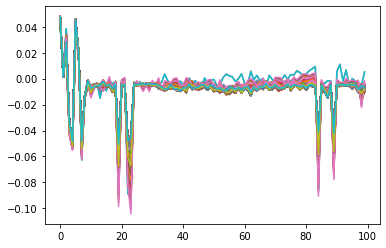

Discriminator Loss: -321185978955416469504.00000000 Generator Loss: 1034182002579346423808.00000000:  40%|▍| 400/1000 [

disc:current fake and real ves:  tensor([ 2.7172e+10, -2.7176e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.9161e+09, -8.0999e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.7206e+10, -2.7210e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.7249e+10, -2.7252e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.7178e+10, -2.7182e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.7216e+10, -2.7220e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.7180e+10, -2.7183e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -321602488253430956032.00000000 Generator Loss: 1037856104039927644160.00000000:  40%|▍| 401/1000 [

disc:current fake and real ves:  tensor([ 2.7163e+10, -2.7166e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.6303e+09, -7.8357e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.7255e+10, -2.7258e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.7389e+10, -2.7392e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.7226e+10, -2.7229e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.7381e+10, -2.7384e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.7227e+10, -2.7230e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -326333729509299453952.00000000 Generator Loss: 1043553828595814498304.00000000:  40%|▍| 402/1000 [

disc:current fake and real ves:  tensor([ 2.7017e+10, -2.7020e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.5780e+09, -8.7315e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.7342e+10, -2.7344e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.7364e+10, -2.7366e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.7301e+10, -2.7303e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.7325e+10, -2.7328e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.7301e+10, -2.7303e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -311825481378589966336.00000000 Generator Loss: 1052515701659937275904.00000000:  40%|▍| 403/1000 [

disc:current fake and real ves:  tensor([ 2.6906e+10, -2.6910e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.9165e+09, -4.3610e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.7464e+10, -2.7467e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.7529e+10, -2.7532e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.7418e+10, -2.7421e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.7507e+10, -2.7510e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.7419e+10, -2.7423e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -404059984675214458880.00000000 Generator Loss: 1068733092927130959872.00000000:  40%|▍| 404/1000 [

disc:current fake and real ves:  tensor([ 2.9158e+10, -2.9160e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.3224e+09, -4.7469e+09], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.9220e+10, -2.9223e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.7735e+10, -2.7738e+10], device='cuda:0', grad_fn=<SelectBackward0>)
disc:current fake and real ves:  tensor([ 2.7555e+10, -2.7557e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.7714e+10, -2.7717e+10], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.7755e+10, -2.7757e+10], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -404059984675214458880.00000000 Generator Loss: 1068733092927130959872.00000000:  40%|▍| 404/1000 [


KeyboardInterrupt: 

In [10]:


train = True
# batch*pnl
signal = 4e-3
trade_strategy_1 = TradingStrategy("buy-hold",10,(0,0),(signal,signal))
trade_strategy_2 = TradingStrategy("MA",10,(0,0),(signal,signal))
trade_strategy_3 = TradingStrategy("MOM",10,(0,0),(signal,signal))
if train:

#     dataset = PriceScenarioDataset(lo30_data,pnl_size, 1,True)
#     dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
#     dataset = Loader32(log_returns_preprocessed, 1)
#     dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    c=0
    t = tqdm(range(1000))
    generator.train()
    discriminator.train()
    for epoch in t:
        for idx, data in enumerate(dataloader, 0):
#             print(data.shape)
            c+=1
#             print(idx,epoch)
            if True: #(idx<=10 and epoch ==0):
                discriminator.zero_grad()
#                 print(data)
                ps_real = data#.permute(0,2,1).squeeze(-1)
    #             score_real = data[-1].reshape(batch_size,-1)

                ps_fake = generator(mean=0, std=1).reshape(batch_size,-1).detach()
                
                disc_loss = 0
                for trade_strategy in [trade_strategy_1,trade_strategy_2,trade_strategy_3]:

                    ts_real = trade_strategy.get_strategy_PnL(ps_real)#,torch.ones_like(ps_real))
                    ts_fake = trade_strategy.get_strategy_PnL(ps_fake)#,torch.ones_like(ps_fake))

                    fake_ve = discriminator(ts_fake)
                    fake_v,fake_e = fake_ve[:,0],fake_ve[:,1]
                    real_ve = discriminator(ts_real)
                    real_v,real_e = real_ve[:,0],real_ve[:,1]
                    if idx % 180 == 0:
                        print("disc:current fake and real ves: ",fake_ve[0],real_ve[0])


                    disc_loss += torch.mean(score(fake_v,fake_e,ps_real,0.05)) - \
                                          torch.mean(score(real_v,real_e,ps_real,0.05))

    #             print('Discriminator Loss: %.8f' % (disc_loss.item()))
                disc_loss/=3
                disc_loss.backward()

                disc_optimizer.step()
                scheduler_disc.step()
            

#             discriminator.zero_grad()
#             real = data.to(device)
#             batch_size, seq_len = real.size(0), real.size(1)
#             noise = torch.randn(batch_size, nz, seq_len, device=device)
#             fake = generator(noise).detach()
#             disc_loss = -torch.mean(discriminator(real)) + torch.mean(discriminator(fake))
#             disc_loss.backward()
#             disc_optimizer.step()

#             for dp in discriminator.parameters():
#                 dp.data.clamp_(-clip, clip)
    
            if True: #not (idx<=10 and epoch ==0):# or idx % 2 == 0:
                for i in range(1):
                    generator.zero_grad()
                    discriminator.zero_grad()
                    ps_fake = generator(mean=0, std=1).reshape(batch_size,-1)
                    ts_fake = trade_strategy.get_strategy_PnL(ps_fake)

                    fake_ve = discriminator(ts_fake)
                    fake_v,fake_e = fake_ve[:,0],fake_ve[:,1]

    #                 print(fake_ve[0],"asdsa")

                    gen_loss = -torch.mean(score(fake_v,fake_e,ps_real,0.05))

    #                 gen_loss = -torch.mean(discriminator(generator(noise)))
                    gen_loss.backward()
                    gen_optimizer.step()
                    scheduler_gen.step()
                if idx % 180 == 0:
                    print("gen:current fake ve: ",fake_ve[0])
                    
        if (epoch+1)%50==0:
            for _ in range(10):
                ps_fake = generator(mean=0, std=1).reshape(batch_size,-1).detach().cpu()
                for i in range(len(ps_fake)):
                    plt.plot(list(range(100)),ps_fake[i])
            plt.show()
        t.set_description('Discriminator Loss: %.8f Generator Loss: %.8f' % (disc_loss.item(), gen_loss.item()))
            
    # Save
    torch.save(generator, f"trained_generator_epoch_{epoch}.pth")

else:
    # Load
    generator = torch.load(f'{generator_path}trained_generator_{file_name}_epoch_{num_epochs-1}.pth')
    generator.eval()

In [12]:
torch.save(generator, f"trained_generator_epoch_{epoch}_sigmoid.pth")

In [13]:
plt.show()

In [14]:
generator = torch.load(f"trained_generator_epoch_14_sigmoid.pth")
generator.eval()

Generator(
  (dense1): Linear(in_features=10, out_features=256, bias=True)
  (dense2): Linear(in_features=256, out_features=256, bias=True)
  (dense3): Linear(in_features=256, out_features=100, bias=True)
  (relu): ReLU()
  (leakyrelu): LeakyReLU(negative_slope=0.01)
  (tanh): Tanh()
)

## Generate

In [1]:
for _ in range(10):
    ps_fake = generator(mean=0, std=1).reshape(batch_size,-1).detach().cpu()
    for i in range(len(ps_fake)):
        plt.plot(list(range(100)),ps_fake[i])
        plt.show()

NameError: name 'generator' is not defined

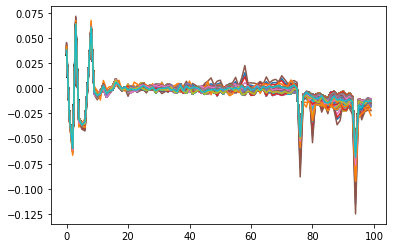

In [10]:
for _ in range(10):
    ps_fake = generator(mean=0, std=1).reshape(batch_size,-1).detach().cpu()
    for i in range(len(ps_fake)):
        plt.plot(list(range(100)),ps_fake[i])

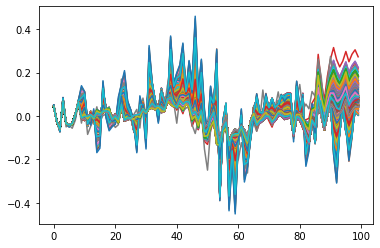

In [8]:
for _ in range(10):
    ps_fake = generator(mean=0, std=1).reshape(batch_size,-1).detach().cpu()
    for i in range(len(ps_fake)):
        plt.plot(list(range(100)),ps_fake[i])

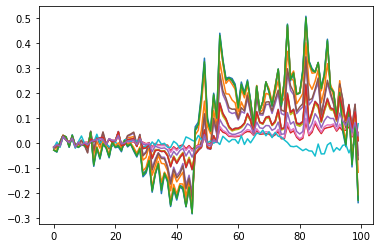

In [26]:
for _ in range(100):
    ps_fake = generator(mean=0, std=1).reshape(batch_size,-1).detach().cpu()
    for i in range(len(ps_fake)):
        if  min(ps_fake[i])<-0.05 and min(ps_fake[i])>-1:
            plt.plot(list(range(100)),ps_fake[i]/2)

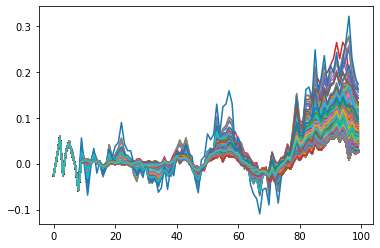

In [7]:
for _ in range(10):
    ps_fake = generator(mean=0, std=1).reshape(batch_size,-1).detach().cpu()
    for i in range(len(ps_fake)):
        plt.plot(list(range(100)),ps_fake[i])

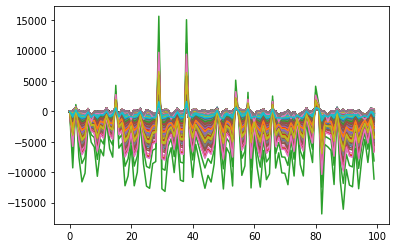

In [6]:
for _ in range(10):
    ps_fake = generator(mean=0, std=1).reshape(batch_size,-1).detach().cpu()
    for i in range(len(ps_fake)):
        plt.plot(list(range(100)),ps_fake[i])

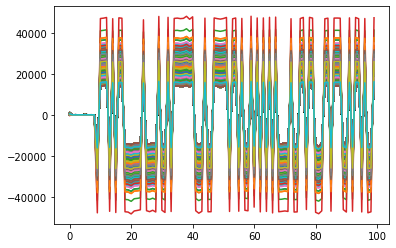

In [6]:
for _ in range(10):
    ps_fake = generator(mean=0, std=1).reshape(batch_size,-1).detach().cpu()
    for i in range(len(ps_fake)):
        plt.plot(list(range(100)),ps_fake[i])

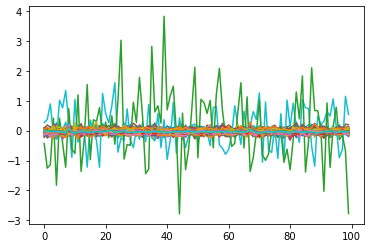

In [7]:
for _ in range(10):
    ps_fake = generator(mean=0, std=1).reshape(batch_size,-1).detach().cpu()
    for i in range(len(ps_fake)):
        plt.plot(list(range(100)),ps_fake[i])

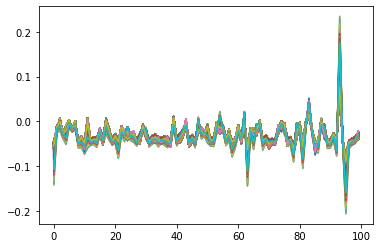

In [7]:
for _ in range(10):
    ps_fake = generator(mean=0, std=1).reshape(batch_size,-1).detach().cpu()
    for i in range(len(ps_fake)):
        plt.plot(list(range(100)),ps_fake[i])

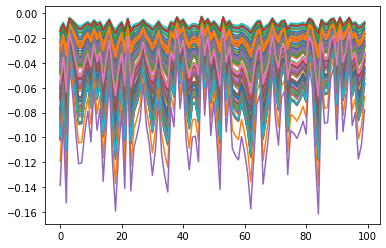

In [8]:
ps_fake = generator(mean=0, std=1).reshape(batch_size,-1).detach().cpu()
for i in range(len(ps_fake)):
    plt.plot(list(range(100)),ps_fake[i])

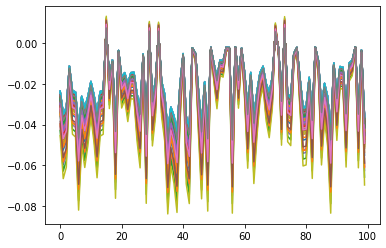

In [13]:
ps_fake = generator(mean=0, std=1).reshape(batch_size,-1).detach().cpu()
for i in range(len(ps_fake)):
    plt.plot(list(range(100)),ps_fake[i]/-1e10)

In [7]:
ps_fake

tensor([[2.9931e+08, 4.3878e+08, 4.0206e+08,  ..., 4.0381e+08, 4.1310e+07,
         4.5880e+08],
        [4.2777e+08, 6.2704e+08, 5.7457e+08,  ..., 5.7697e+08, 5.8824e+07,
         6.5672e+08],
        [3.0092e+08, 4.4114e+08, 4.0422e+08,  ..., 4.0597e+08, 4.1520e+07,
         4.6132e+08],
        ...,
        [3.0171e+08, 4.4229e+08, 4.0528e+08,  ..., 4.0703e+08, 4.1624e+07,
         4.6256e+08],
        [2.8306e+08, 4.1499e+08, 3.8025e+08,  ..., 3.8196e+08, 3.9181e+07,
         4.3336e+08],
        [5.1677e+08, 7.5750e+08, 6.9412e+08,  ..., 6.9701e+08, 7.1061e+07,
         7.9336e+08]])

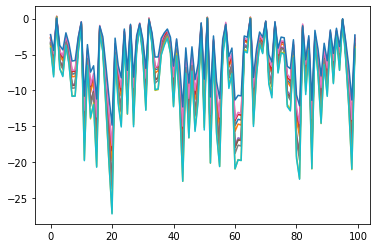

In [20]:
for i in range(len(ps_fake)):
    plt.plot(list(range(100)),ps_fake[i].cpu())
    if i == 10:
        break

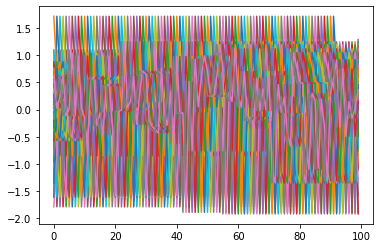

In [47]:
for data in dataloader:
    ps_real = data[0].permute(0,2,1).squeeze(-1)
    for i in range(len(ps_real)):
        plt.plot(list(range(100)),ps_real[i].cpu())

    break

In [43]:
ts_real = trade_strategy.get_strategy_PnL(ps_real).cpu()#,torch.ones_like(ps_real))
ts_fake = trade_strategy.get_strategy_PnL(ps_fake).cpu()#,torch.ones_like(ps_fake))

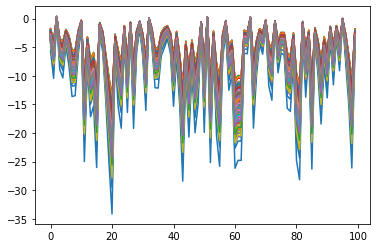

In [46]:
for i in range(len(ps_real)):
#     plt.plot(list(range(100)),ts_real[i])
    plt.plot(list(range(100)),ts_fake[i])

In [ ]:
generator.eval()
noise = torch.randn(80,3,127).to(device)
y = generator(noise).cpu().detach().squeeze();

y = (y - y.mean(axis=0))/y.std(axis=0)
y = standardScaler2.inverse_transform(y)
y = np.array([gaussianize.inverse_transform(np.expand_dims(x, 1)) for x in y]).squeeze()
y = standardScaler1.inverse_transform(y)

# some basic filtering to redue the tendency of GAN to produce extreme returns
y = y[(y.max(axis=1) <= 2 * log_returns.max()) & (y.min(axis=1) >= 2 * log_returns.min())]
y -= y.mean()
len(y)

## Results and visualizing stylized facts

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(np.cumsum(y[0:30], axis=1).T, alpha=0.75)
ax.set_title('30 generated log return paths'.format(len(y)))
ax.set_xlabel('days')
ax.set_ylabel('Cumalative log return');

In [ ]:
n_bins = 50
windows = [1, 5, 20, 100]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))


for i in range(len(windows)):
    row = min(max(0, i-1), 1)
    col = i % 2
    real_dist = rolling_window(log_returns, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist = rolling_window(y.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    axs[row, col].hist(np.array([real_dist, fake_dist], dtype='object'), bins=50, density=True)
    axs[row,col].set_xlim(*np.quantile(fake_dist, [0.001, .999]))
    
    axs[row,col].set_title('{} day return distribution'.format(windows[i]), size=16)
    axs[row,col].yaxis.grid(True, alpha=0.5)
    axs[row,col].set_xlabel('Cumalative log return')
    axs[row,col].set_ylabel('Frequency')

axs[0,0].legend(['Historical returns', 'Synthetic returns'])


In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

axs[0,0].plot(acf(log_returns, 100))
axs[0,0].plot(acf(y.T, 100).mean(axis=1))
axs[0,0].set_ylim(-0.1, 0.1)
axs[0,0].set_title('Identity log returns')
axs[0,1].plot(acf(log_returns**2, 100))
axs[0,1].set_ylim(-0.05, 0.5)
axs[0,1].plot(acf(y.T**2, 100).mean(axis=1))
axs[0,1].set_title('Squared log returns')
axs[1,0].plot(abs(acf(log_returns, 100, le=True)))
axs[1,0].plot(abs(acf(y.T, 100, le=True).mean(axis=1)))
axs[1,0].set_ylim(-0.05, 0.4)
axs[1,0].set_title('Absolute')
axs[1,1].plot(acf(log_returns, 100, le=True))
axs[1,1].plot(acf(y.T, 100, le=True).mean(axis=1))
axs[1,1].set_ylim(-0.2, 0.1)
axs[1,1].set_title('Leverage effect')


for ax in axs.flat: 
  ax.grid(True)
  ax.axhline(y=0, color='k')
  ax.axvline(x=0, color='k')
plt.setp(axs, xlabel='Lag (number of days')

In [56]:
t = torch.tensor([1.,5.,3.],requires_grad = True)
b = torch.tensor([1.,2.,3.]).reshape(-1,1)
result = torch.matmul(torch.sort(t)[0],b)
result.backward()
t.grad

tensor([1., 3., 2.])

In [57]:
result.backward()
t.grad

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [ ]:
result = torch.matmul(torch.sort(t)[0],b)
result.backward()
t.grad

In [25]:
t = torch.tensor([[1.,5.,3.],[1.,5.,3.],[1.,5.,3.]],requires_grad = True)
s =torch.cumsum(t,dim=1)
s

tensor([[1., 6., 9.],
        [1., 6., 9.],
        [1., 6., 9.]], grad_fn=<CumsumBackward0>)

In [12]:
(t>t).long()

tensor([0, 0, 0], device='cuda:0')

In [53]:
t.detach().cpu().cuda().cuda()

tensor([1., 5., 3.], device='cuda:0')

In [11]:
tanh = nn.Tanh()

In [13]:
tanh(t)

tensor([0.7616, 0.9999, 0.9951], device='cuda:0', grad_fn=<TanhBackward0>)

In [12]:
torch.arange(1,10)

tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [17]:
s[:,1:] - s[:,-1].reshape(-1,1)

tensor([[-3.,  0.],
        [-3.,  0.],
        [-3.,  0.]], device='cuda:0', grad_fn=<SubBackward0>)

In [20]:
z = torch.zeros(3).unsqueeze(1)
torch.cat((z,s),dim=1)

tensor([[0., 1., 6., 9.],
        [0., 1., 6., 9.],
        [0., 1., 6., 9.]], grad_fn=<CatBackward0>)

In [33]:
def running_mean(x, N):
    zeros = torch.zeros(x.size()[0]).unsqueeze(1)
    ma = torch.cat((zeros,x),dim=1)
    ma = torch.cumsum(ma,dim=1) 
#     print(ma)
#     print(ma[:,N:] - ma[:,:-N])
    ma = (ma[:,N:] - ma[:,:-N]) / float(N)
    ma = torch.cat((x[:,:N-1],ma),dim=1)
    return ma
running_mean(s,2)

tensor([[ 0.,  1.,  7., 16.],
        [ 0.,  1.,  7., 16.],
        [ 0.,  1.,  7., 16.]], grad_fn=<CumsumBackward0>)
tensor([[ 7., 15.],
        [ 7., 15.],
        [ 7., 15.]], grad_fn=<SubBackward0>)


tensor([[1.0000, 3.5000, 7.5000],
        [1.0000, 3.5000, 7.5000],
        [1.0000, 3.5000, 7.5000]], grad_fn=<CatBackward0>)

In [8]:
torch.linspace(0,0, steps=(1,2))

TypeError: linspace(): argument 'steps' must be int, not tuple

In [7]:
torch.log(torch.tensor([1,2]))

tensor([0.0000, 0.6931])

In [8]:
import torch
5*torch.ones(size=(5,)).cuda().unsqueeze(-1)

tensor([[5.],
        [5.],
        [5.],
        [5.],
        [5.]], device='cuda:0')